In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl
import statsmodels.stats.multicomp as ml

from scipy import stats as spstats
from matplotlib.lines import Line2D

from pipeline.python import utils as putils #.utils import natural_keys, label_figure, convert_range
from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr

from pipeline.python.retinotopy import segment_retinotopy as seg

from pipeline.python.classifications import bootstrap_osi as osi

import matplotlib.patches as mpatches

/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
# 11469876 - 20190512_JC083_fov1, Lm

In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


In [4]:
def outline_boxplot(ax):
    # iterate over boxes to make them outlines only
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('white')
        # iterate over whiskers and median lines
        for j in range(6*i,6*(i+1)):
             ax.lines[j].set_color('black')
    return


# Set metadata info

In [5]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/coxfs01/2p-data'

#### Preprocessing params
responsive_test = 'nstds'
responsive_thr = 10.0
n_stds = 2.5

#### Fit params
response_type = 'dff'
fit_thr=None

n_bootstrap_iters=1000
n_resamples = 20


#### Get fit description
fit_desc = osi.get_fit_desc(response_type=response_type, responsive_test=responsive_test,
                       responsive_thr=responsive_thr, n_stds=n_stds)
print(fit_desc)

fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


In [6]:
#### Set outputdir for current analysis
outdir = os.path.join(aggregate_dir, 'gratings-tuning', '%s-%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("... saving output to base dir:\n%s" % outdir)

#### Create data ID for labeling figures with data-types
data_id = '%s|%s' % (traceid, fit_desc)
print("DATA ID: %s" % data_id)

... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20
DATA ID: traces001|fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


In [7]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

# Aggregate all tuning data

In [8]:
def get_average_tuning_over_iters(fitdf):
    means = {}
    roi = int(fitdf['cell'].unique()[0])
    for param in fitdf.columns:
        if 'theta' in param:
            meanval = np.rad2deg(spstats.circmean(np.deg2rad(fitdf[param].values % 360.)))
        else:
            meanval = fitdf[param].values.mean()
        
        means[param] = meanval
    
    return pd.DataFrame(means, index=[roi])

In [9]:
def add_tuned_cells(responsive_cells, gdata, metric='r2comb', responsive_thr=0.5):

    count_cols = ['visual_area', 'animalid', 'session', 'fov','datakey', 'cell']
    tuned_cells = gdata[gdata[metric]>=responsive_thr][count_cols]\
                        .drop_duplicates().groupby(count_cols[0:-1])\
                        .count().reset_index().rename(columns={'cell': 'tuned_cells'})

    updated_counts = pd.merge(responsive_cells, tuned_cells, how='left')
    #print(updated_counts.shape)
    return updated_counts

def update_gof_cells(updated_counts, gdata, gof_thr=0.5, responsive_name='responsive_cells'):
    '''
    visual_cells : responsive to any of the experients
    responsive_cells : responsive to gratings, specifically (with bootstrap test)
    tuned_cells : pass Goodness-of-Fit thr
    '''
    count_cols = ['visual_area', 'animalid', 'session', 'fov','datakey', 'cell']

    gof_cells = gdata[gdata['gof']>=gof_thr][count_cols]\
                        .drop_duplicates().groupby(count_cols[0:-1])\
                        .count().reset_index().rename(columns={'cell': 'gof_cells'})
            
    cellcounts = pd.merge(updated_counts, gof_cells, how='left')
    cellcounts['tuned_over_responsive'] = cellcounts['tuned_cells'].astype(float) / cellcounts[responsive_name]
    cellcounts['gof_over_responsive'] = cellcounts['gof_cells'].astype(float) / cellcounts[responsive_name]
    cellcounts['gof_over_tuned'] = cellcounts['gof_cells'].astype(float) / cellcounts['tuned_cells']


    #print(cellcounts.shape)
    return cellcounts.dropna()

In [21]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

In [22]:
#### Get metadata
gratings_filter_by = None #'most_cells'
dsets = aggr.get_metadata(stimulus='gratings',  filter_by=gratings_filter_by, 
                          stimulus_only=True,
                          traceid=traceid, fov_type=fov_type, state=state)
dsets.groupby(['visual_area', 'experiment']).count()


Selecting 35 dsets


animalid  datakey  fov  fovnum  session
visual_area experiment                                         
Li          gratings          18       18   18      18       18
Lm          gratings          10       10   10      10       10
V1          gratings           7        7    7       7        7

In [23]:
response_type='dff'
responsive_test='nstds'
responsive_thr=10
trial_epoch = 'stimulus'

# retino
retino_mag_thr=0.01
retino_pass_criterion='max'
verbose=False


# NOTE:  For timecourses, remove 20190517_JC083_fov1
# shorter stim period, tho nice responses (a few cells)

In [24]:
# Get all cells
# -------------------------------------------------------------------------
all_rois = seg.get_cells_by_area(sdata)
all_counts = all_rois[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()\
                .rename(columns={'cell': 'total'})

Segmentation: missing 9 dsets


In [25]:
# Get *all* RESPONSIVE cells (responds to any of the experiments)
# -------------------------------------------------------------------------
aggr_cells, missing_seg = aggr.get_responsive_all_experiments(sdata,
                                    response_type=response_type, traceid=traceid,
                                    responsive_test=responsive_test, responsive_thr=responsive_thr,
                                    trial_epoch=trial_epoch, retino_mag_thr=retino_mag_thr,
                                    retino_pass_criterion=retino_pass_criterion, return_missing=True)

assert len([k for k in aggr_cells['datakey'].unique() if k in missing_seg])==0, \
"There are included dsets w/ missing seg. Fix this."

# Count all responsive cells       
# -------------------------------------------------------------------------
visual_cells = aggr_cells[['visual_area', 'datakey', 'cell']].drop_duplicates()
visual_counts = visual_cells.groupby(['visual_area', 'datakey']).count().reset_index()


...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl
Segmentation: missing 5 dsets
(2006, 8)
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl
Segmentation: missing 4 dsets
(5499, 8)
Segmentation: missing 3 dsets
N dpaths: 70, N unfit: 0
N datasets included: 70, N sessions excluded: 4
[AL] Animalid does not exist: JC080 
[AL] Animalid does not exist: JC099 
[Ll] Animalid does not exist: JC089 
[Ll] Animalid does not exist: JC099 
[PL] Animalid does not exist: JC076 
[V1] Animalid does not exist: JC078 
(39, 7)
Segmentation: missing 9 dsets
(8678, 8)


In [26]:
# Get all cells
gratings_cellcounts = aggr.get_ncells_by_experiment(aggr_cells, all_counts, experiment='gratings')
gratings_cellcounts.groupby(['visual_area']).sum()

visual  total  fraction
visual_area                         
AL                2     17  0.117647
Li              314   2074  2.325936
Ll              134    358  0.771185
Lm              731   2273  2.796292
V1              825   2338  3.207174

In [28]:
# **missing '20190517_JC083_fov1' -- rerun aggr?

experiment='gratings'
trial_epoch = 'stimulus'

#### Check for equal trial counts
gratings_meta, gratings_cells, MEANS_gratings = aggr.get_source_data(experiment, equalize_now=True, 
                                                response_type=response_type,
                                                responsive_test=responsive_test, 
                                                responsive_thr=responsive_thr, 
                                                trial_epoch=trial_epoch) 
gratings_cells = gratings_cells[gratings_cells['visual_area'].isin(visual_areas)]
gratings_cells.groupby(['visual_area']).count()

...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl
---equalizing now---
Segmentation: missing 5 dsets


cell  fov  animalid  session  datakey  fovnum
visual_area                                               
Li            314  314       314      314      314     314
Lm            731  731       731      731      731     731
V1            825  825       825      825      825     825

## Filter fov, debug

In [30]:
# def get_dsets_with_most_gratings(edata, assigned_cells, traceid='traces001', response_type='dff',
#                                 responsive_test='nstds', responsive_thr=10.0, 
#                                 n_bootstrap_iters=1000, n_resamples=20):
    
#     #edata = sdata[sdata['experiment']=='gratings'].copy()
#     exp_cells = pd.concat([g for (visual_area, datakey), g \
#                                 in assigned_cells.groupby(['visual_area', 'datakey']) \
#                                 if datakey in edata['datakey'].values])

#     # Load all gratings data
#     gdata, missing_ = aggr_gratings_fits(exp_cells, traceid=traceid, response_type=response_type, 
#                        responsive_test=responsive_test, responsive_thr=responsive_thr,
#                        n_bootstrap_iters=n_bootstrap_iters, n_resamples=n_resamples)

#     best_dfs = get_dsets_with_most_fits(gdata, exp_cells) 
    
#     return best_dfs

In [31]:
# Get ALL the data
edata = sdata[sdata['experiment']=='gratings'].copy()
exp_cells = pd.concat([g for (visual_area, datakey), g \
                            in all_rois.groupby(['visual_area', 'datakey']) \
                            if datakey in edata['datakey'].values])
# Load all gratings data
gdata, missing_ = aggr.aggr_gratings_fits(exp_cells, traceid=traceid, response_type=response_type, 
                   responsive_test=responsive_test, responsive_thr=responsive_thr,
                   n_bootstrap_iters=n_bootstrap_iters, n_resamples=n_resamples)
gdata = gdata[gdata['visual_area'].isin(visual_areas)]

In [32]:
# Count how many cells fit total per site
countby = ['visual_area', 'datakey', 'cell']
counts_by_fov = gdata[countby].drop_duplicates()\
                    .groupby(['visual_area', 'datakey']).count().reset_index()
counts_by_fov = putils.split_datakey(counts_by_fov)
counts_by_fov.groupby(['visual_area']).sum()

cell
visual_area      
Li            259
Lm            616
V1            581

In [33]:
# Drop repeats
best_dfs = aggr.get_dsets_with_most_fits(gdata, exp_cells) 
#best_dfs = aggr.get_dsets_with_most_gratings(edata, all_rois)

In [35]:
best_dfs.groupby(['visual_area']).sum()

cell
visual_area      
Li            208
Lm            606
V1            646

In [46]:
dict((k, list(v['datakey'].unique())) for k, v in best_dfs[['visual_area', 'datakey']]\
     .drop_duplicates().groupby(['visual_area']))


{u'Li': ['20190319_JC067_fov1',
  '20190314_JC070_fov1',
  '20190315_JC070_fov2',
  '20190522_JC089_fov1',
  '20190602_JC091_fov1',
  '20190614_JC091_fov1',
  '20190527_JC092_fov3',
  '20190612_JC099_fov1',
  '20190617_JC099_fov1',
  '20191018_JC113_fov1',
  '20191111_JC120_fov1'],
 u'Lm': ['20190306_JC061_fov2',
  '20190314_JC070_fov2',
  '20190513_JC078_fov1',
  '20190603_JC080_fov1',
  '20190512_JC083_fov1',
  '20190525_JC084_fov1',
  '20190627_JC091_fov1',
  '20190618_JC097_fov1'],
 u'V1': ['20190511_JC083_fov1',
  '20190512_JC083_fov1',
  '20190517_JC083_fov1',
  '20190522_JC084_fov1',
  '20190622_JC085_fov1',
  '20190613_JC097_fov1',
  '20190617_JC097_fov1',
  '20190616_JC097_fov1',
  '20191006_JC110_fov1']}

In [36]:
# gdata[['visual_area', 'datakey', 'cell']].groupby(['visual_area', 'datakey', 'cell']).count().reset_index()

In [37]:
gdata.groupby(['visual_area']).count().reset_index()

visual_area  asi  cell  dsi  gof   r2  r2comb  response_null  \
0          Li  259   259  259  259  259     259            259   
1          Lm  616   616  616  616  616     616            616   
2          V1  581   581  581  581  581     581            581   

   response_offset  response_pref  sigma  theta_pref  session  fov  datakey  \
0              259            259    259         259      259  259      259   
1              616            616    616         616      616  616      616   
2              581            581    581         581      581  581      581   

   animalid  
0       259  
1       616  
2       581

In [195]:
# gdata[(gdata['datakey']=='20190617_JC099_fov1') & (gdata['visual_area']=='Li') ]

In [232]:
visualany = visual_counts[(visual_counts['visual_area'].isin(visual_areas)) 
                         & (visual_counts['datakey']).isin(edata['datakey'].values)].copy().rename(columns={'cell': 'visual_cells'})
visualany.head()

visual_area              datakey  visual_cells
2           Li  20190314_JC070_fov1           118
4           Li  20190315_JC070_fov2            47
6           Li  20190319_JC067_fov1            46
12          Li  20190522_JC089_fov1            24
13          Li  20190527_JC092_fov3            81

In [249]:
grat = gratings_cells.groupby(['visual_area','datakey']).count()['cell']\
                    .reset_index().rename(columns={'cell': 'responsive_cells'})
grat.head()

visual_area              datakey  responsive_cells
0          Li  20190314_JC070_fov1                37
1          Li  20190315_JC070_fov2                 7
2          Li  20190319_JC067_fov1                 9
3          Li  20190522_JC089_fov1                 8
4          Li  20190527_JC092_fov3                 7

In [250]:
responsive_cells = grat.merge(visualany)
responsive_cells = putils.split_datakey(responsive_cells)

In [254]:

# Add 'tuned' cellss
updated_counts = add_tuned_cells(responsive_cells, gdata, metric='r2comb', responsive_thr=0.5)
updated_counts.groupby(['visual_area']).sum()

responsive_cells  visual_cells  tuned_cells
visual_area                                             
Li                        314          1579        158.0
Lm                        731          1854        321.0
V1                        825          2094        165.0

# Aggregate all gratings data

In [256]:
# # Check cell counts for this gdata, and the one made w/ aggr_gratings_fits

# no_fits = []
# counts_ = []
# g_ = []
# rerun_responsive=[]
# i = 0
# for (visual_area, datakey, animalid, session, fov), g in gratings_cells.groupby(['visual_area', 'datakey', 'animalid', 'session', 'fov']):
    
#     curr_cells = g['cell'].unique()
    
#     # Get all osi results for current dataset
#     exp = util.Gratings(animalid, session, fov, traceid=traceid, rootdir=rootdir)
#     bootresults_tmp, fitparams = exp.get_tuning(response_type=response_type,
#                                            responsive_test=responsive_test,
#                                            responsive_thr=responsive_thr, n_stds=n_stds,
#                                            n_bootstrap_iters=n_bootstrap_iters,
#                                            n_resamples=n_resamples)
    
#     # Get cells responsive to anything (visual cells)
#     visual_cells_any = visual_cells[(visual_cells['visual_area']==visual_area)
#                          & (visual_cells['datakey']==datakey)]['cell']
#     print("[%s] %s - %i (of %i visual) cells responsive" \
#           % (visual_area, datakey, len(curr_cells), len(visual_cells_any)))
    
#     # Get OSI results
#     bootresults = dict((k, v) for k, v in bootresults_tmp.items() if k in curr_cells)

#     # Get fits
#     rmetrics, rmetrics_by_cfg = osi.get_good_fits(bootresults, fitparams, gof_thr=None)
#     if rmetrics is None:
#         no_fits.append('%s_%s' % (visual_area, datakey))
#         continue
    
#     counts_.append(pd.DataFrame({'datakey': datakey,
#                                     'visual_area': visual_area,
#                                     'animalid': animalid,
#                                     'session': session, 
#                                     'fov': fov,
#                                     'visual_cells': len(visual_cells_any),
#                                     'responsive_cells': len(curr_cells)}, index=[i]))
#     meandf = rmetrics.copy()
#     metainfo = {'visual_area': visual_area, 'animalid': animalid, 
#                 'session': session, 'fov': fov, 'datakey': datakey}
#     meandf = putils.add_meta_to_df(meandf, metainfo)
#     g_.append(meandf)
#     i += 1
    
# responsive_cells = pd.concat(counts_, axis=0)
# gdata = pd.concat(g_, axis=0)

# print("Datasets with NO fits found:")
# for s in no_fits:
#     print(s)
    
# # Add 'tuned' cellss
# updated_counts = add_tuned_cells(responsive_cells, gdata, responsive_thr=0.5)

In [255]:
curr_gof=0.5

cellcounts = update_gof_cells(updated_counts, gdata, gof_thr=curr_gof)
cellcounts.groupby(['visual_area']).sum()

responsive_cells  visual_cells  tuned_cells  gof_cells  \
visual_area                                                           
Li                        307          1498        158.0       96.0   
Lm                        731          1854        321.0      191.0   
V1                        825          2094        165.0       53.0   

             tuned_over_responsive  gof_over_responsive  gof_over_tuned  
visual_area                                                              
Li                        7.207069             4.855370        8.635570  
Lm                        4.858546             3.133124        5.374676  
V1                        2.229932             1.035563        3.323560

In [54]:
curr_gof=0.5

cellcounts = update_gof_cells(updated_counts, gdata, gof_thr=curr_gof)
cellcounts.groupby(['visual_area']).sum()

responsive_cells  visual_cells  tuned_cells  gof_cells  \
visual_area                                                           
Li                        286          1346        133.0       66.0   
Lm                        720          1701        375.0      193.0   
V1                        823          2057        413.0      220.0   

             tuned_over_responsive  gof_over_responsive  gof_over_tuned  
visual_area                                                              
Li                        4.959943             2.391583        4.689683  
Lm                        3.995357             1.928490        3.930461  
V1                        4.147129             2.264204        4.315775

In [55]:
cellcounts.groupby(['visual_area']).sum()

responsive_cells  visual_cells  tuned_cells  gof_cells  \
visual_area                                                           
Li                        286          1346        133.0       66.0   
Lm                        720          1701        375.0      193.0   
V1                        823          2057        413.0      220.0   

             tuned_over_responsive  gof_over_responsive  gof_over_tuned  
visual_area                                                              
Li                        4.959943             2.391583        4.689683  
Lm                        3.995357             1.928490        3.930461  
V1                        4.147129             2.264204        4.315775

# Aggregate all data

## Output dir

In [257]:
dstdir = os.path.join(outdir, 'general_stats')
if not os.path.exists(dstdir):
    os.makedirs(dstdir)
print("saving figures to:\n%s" % dstdir)

saving figures to:
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats


## Counts by dataset/visual area

In [288]:
curr_gof=0.5
cellcounts = update_gof_cells(updated_counts, gdata, gof_thr=curr_gof)
cellcounts.groupby(['visual_area']).sum()


responsive_cells  visual_cells  tuned_cells  gof_cells  \
visual_area                                                           
Li                        307          1498        158.0       96.0   
Lm                        731          1854        321.0      191.0   
V1                        825          2094        165.0      130.0   

             tuned_over_responsive  gof_over_responsive  gof_over_tuned  
visual_area                                                              
Li                        7.207069             4.855370        8.635570  
Lm                        4.858546             3.133124        5.374676  
V1                        2.229932             1.915738        7.420619

<IPython.core.display.Javascript object>


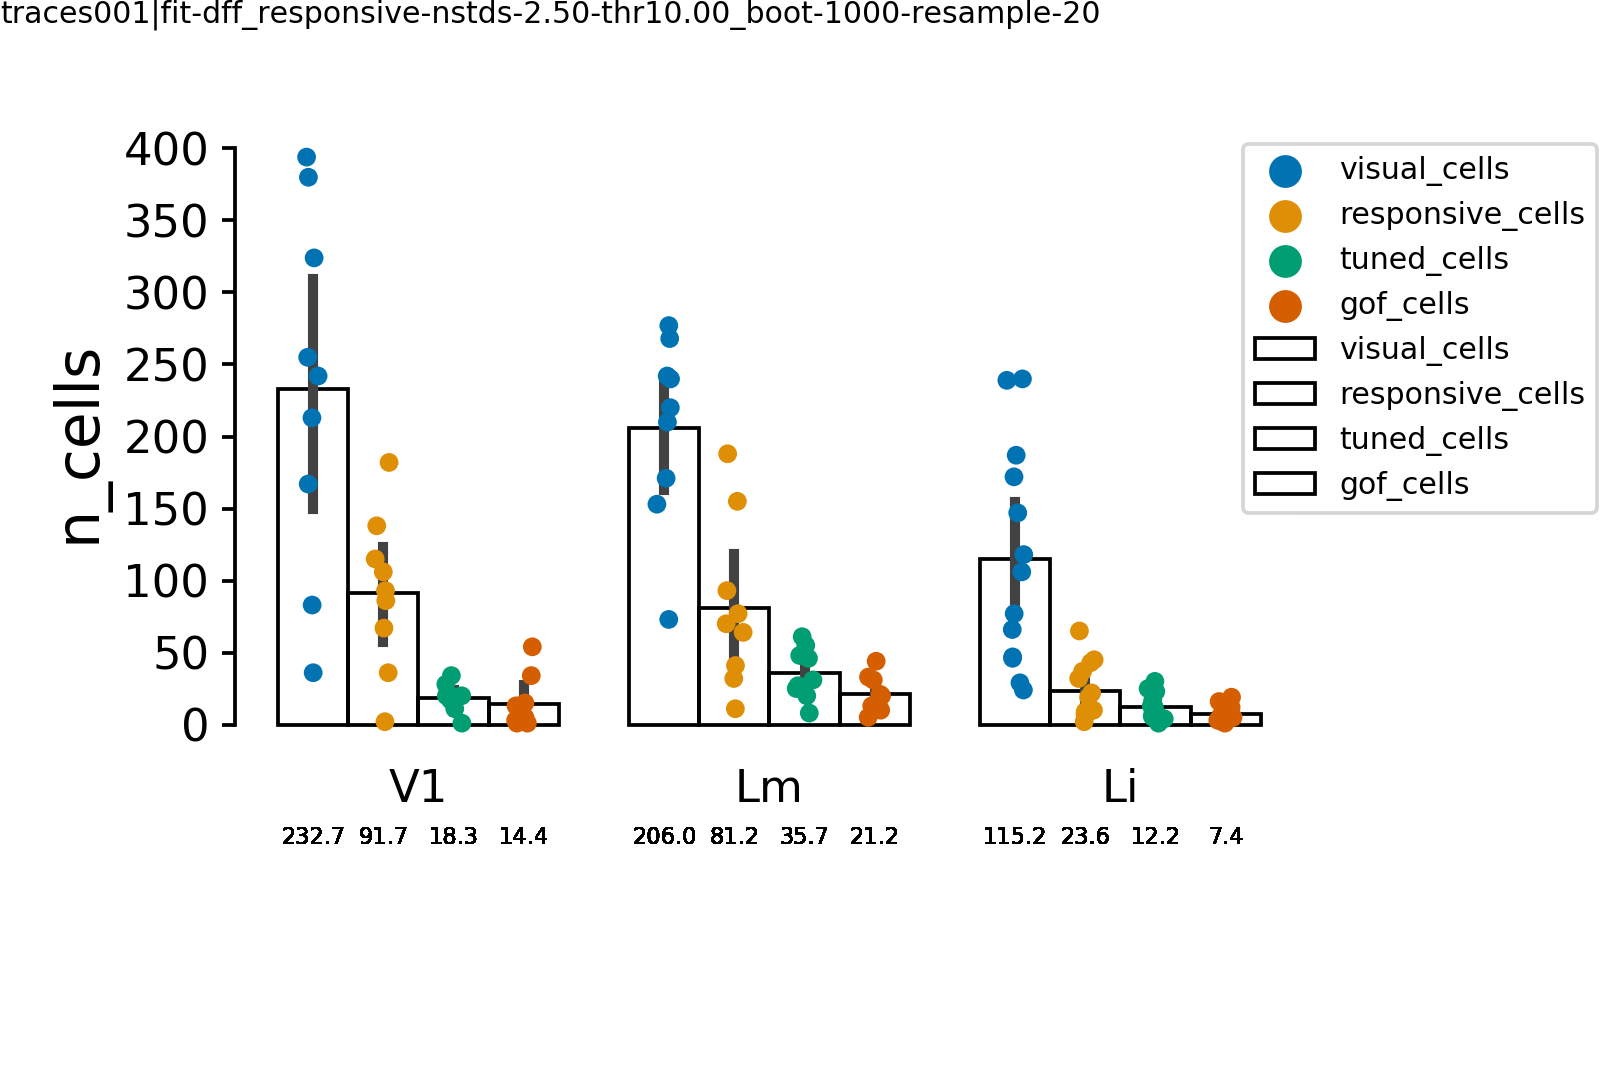

('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'cell_counts_gof-0.50')


In [289]:
cols = [k for k in cellcounts.columns if 'over' not in k and k not in ['animalid', 'session', 'fov']]
grouped_counts = cellcounts[cols]\
                    .melt(id_vars=['visual_area', 'datakey'], var_name='type', value_name='n_cells')

# Plot counts by responsivity
# -------------------------------------------------------------------
fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
sns.stripplot(x='visual_area', y='n_cells', hue='type',data=grouped_counts, ax=ax, 
             palette='colorblind', dodge=True, 
              hue_order=['visual_cells', 'responsive_cells', 'tuned_cells', 'gof_cells'],
              order=visual_areas, marker='o', s=5)

sns.barplot(x='visual_area', y='n_cells', hue='type',data=grouped_counts, ax=ax, 
             dodge=True, 
            hue_order=['visual_cells', 'responsive_cells', 'tuned_cells', 'gof_cells'],
            order=visual_areas, edgecolor=('k', 'k', 'k'), facecolor='none')
ax.set_xlabel('')
grouped_counts.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=6, 
                     fontcolor='k', xytext=(0, -30), fmt='%.1f')
ax.legend(bbox_to_anchor=(1.3, 1), fontsize=8)

# Format
ax.tick_params(which='both', axis='x', size=0)
sns.despine(bottom=True, trim=True, offset=2)
pl.subplots_adjust(left=0.15, right=0.8, bottom=0.3)

# Label and save
putils.label_figure(fig, data_id)

figname = 'cell_counts_gof-%.2f' % (curr_gof)
#pl.savefig(os.path.join(dstdir, '%s.svg' % figname))
print(dstdir, figname)

In [ ]:
cellcounts.groupby(['visual_area']).mean()

# Fraction tuned 

In [295]:
responsive_name='responsive_cells'
filter_gof = True

drop_repeats = True

unique_dkeys = best_dfs['datakey'].unique()
xdata = gdata[gdata['datakey'].isin(unique_dkeys)].copy() if drop_repeats else gdata.copy() 

curr_gof = 0.5 if filter_gof else 0
cellcounts = update_gof_cells(updated_counts, xdata, gof_thr=curr_gof, responsive_name=responsive_name)
if filter_gof:
    currdata = xdata[xdata['gof'] >= curr_gof].copy().dropna()
else:
    currdata = xdata.copy()

<IPython.core.display.Javascript object>


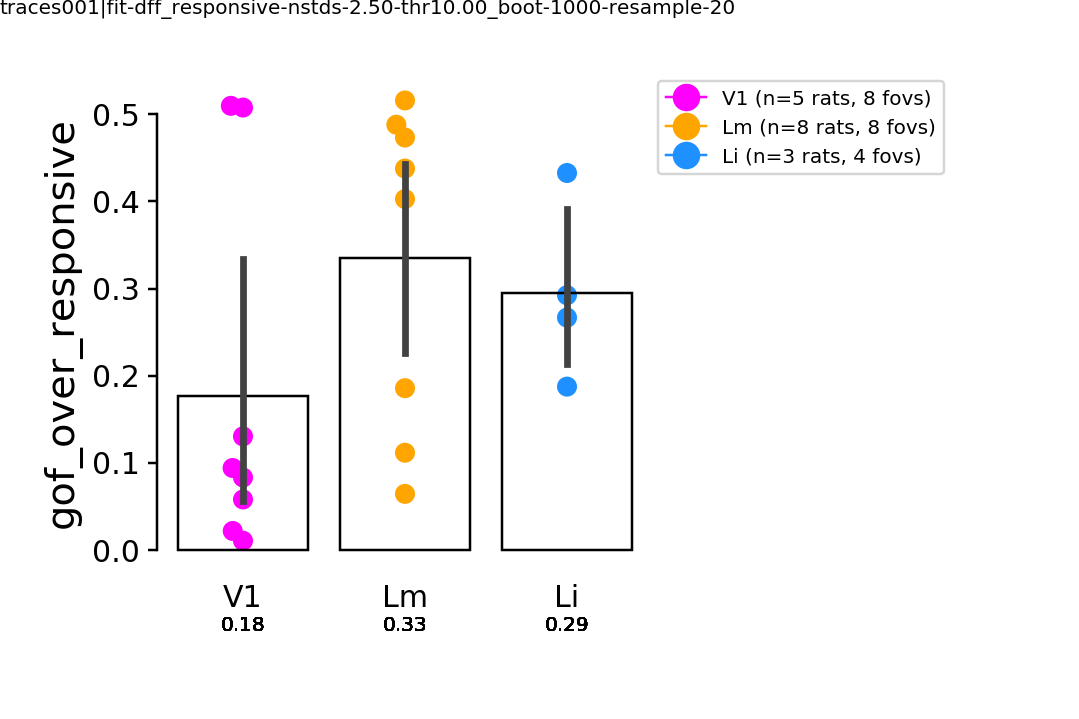

********* [gof_over_responsive] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.152 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.152 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.336 (fdr_bh), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'fraction_gof_over_responsive_gof-0.50_all')


In [298]:
fraction_plot = 'gof_over_responsive'
#fraction_plot = 'tuned_over_responsive'
#fraction_plot = 'gof_over_tuned'

min_ncells=20

plotdf = cellcounts[cellcounts[responsive_name]>=min_ncells].copy().dropna()
multi_comp_test = 'fdr_bh'

ylim = 0.5 if 'gof' in fraction_plot or 'tuned' in fraction_plot else 1.0

# ~~~~~~~~~~ plot ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig, ax = pl.subplots(figsize=(6,4))
sns.swarmplot(x='visual_area', y=fraction_plot, data=plotdf, ax=ax, zorder=-1,
              color='k', s=8, marker='o',order=visual_areas, palette=area_colors)
ax = sns.barplot(x="visual_area", y=fraction_plot, data=plotdf, zorder=0,
              edgecolor=('k', 'k', 'k'), facecolor='none', ax=ax, order=visual_areas) 
plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fontcolor='k', xytext=(0, -30))

# Legend.
leg = aggr.get_counts_for_legend(plotdf, area_colors=area_colors, marker='o')
ax.legend(handles=leg, bbox_to_anchor=(1.,1), fontsize=8)

# Stats
stats_fraction_tuned, ax = aggr.plot_mannwhitney(plotdf, metric=fraction_plot, ax=ax, 
                                    multi_comp_test=multi_comp_test, y_loc=ylim-0.05, offset=0.05)

# Formatting
ax.tick_params(which='both', axis='x', length=0)
ax.set_xlabel('')

sns.despine(bottom=True, trim=True, offset=2)
ax.tick_params(which='both', axis='x', size=0)
pl.subplots_adjust(top=0.9, left=0.15, bottom=0.2, right=0.6)

# Save
putils.label_figure(fig, data_id)
figname = 'fraction_%s_gof-%.2f_all' % (fraction_plot, curr_gof)
#pl.savefig(os.path.join(dstdir, '%s.svg' % figname))
print(dstdir, figname)

#### Stats

In [299]:
c1 = cellcounts[cellcounts['visual_area']=='V1'][fraction_plot].values
c2 = cellcounts[cellcounts['visual_area']=='Lm'][fraction_plot].values
c3 = cellcounts[cellcounts['visual_area']=='Li'][fraction_plot].values

# Shapiro-Wilk normality test 
print("Shapiro-Wilk normality:", spstats.shapiro(c1), spstats.shapiro(c2), spstats.shapiro(c3) )

# Levene variance test  
print(spstats.levene(c1, c2, c3))

F, p = spstats.f_oneway(c1, c2, c3)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                    ['Lm' for _ in range(len(c2))],
                    ['Li' for _ in range(len(c3))]])

# Note that data in sheet have been preformatted in Group and Score columns 
# Boolean values refer to whether we should reject the null hypothesis (H0) that
# the means of the tested pair are statistically similar (non-significant differences)

mcobj = ml.MultiComparison(scores, groups)
out = mcobj.tukeyhsd(0.05) 

print(out)

('Shapiro-Wilk normality:', (0.7445184588432312, 0.004683146718889475), (0.8138042092323303, 0.029320525005459785), (0.8790140151977539, 0.12713280320167542))
LeveneResult(statistic=0.12339132528483776, pvalue=0.8844526614494874)
F statistic = 1.956 and probability p = 0.162
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Li     Lm   -0.0322  -0.2536 0.1891 False 
  Li     V1   -0.1675  -0.3889 0.0539 False 
  Lm     V1   -0.1353  -0.3624 0.0919 False 
--------------------------------------------


# Visualize

In [300]:
def compare_tuning_metric(df, metric='ASI', cdf=False, ax=None, area_colors=None, show_legend=True, alpha=1):
    if ax is None:
        fig, ax = pl.subplots(figsize=(6,4))
        fig.patch.set_alpha(1)
    if area_colors is None:
        visual_areas = sorted(df['visual_area'].unique())
        colors = sns.color_palette(palette='cubehelix', n_colors=len(visual_areas))
        area_colors = dict((k, col) for k, col in zip(visual_areas, colors))

    for visual_area, tmpd in df.groupby(['visual_area']):
        if 'animalid' in tmpd.columns:
            nrats = len(tmpd['animalid'].unique())
        else:
            if 'datakey' in tmpd.columns:
                ratnames = [s.split('_')[1] for s in tmpd['datakey']]
                nrats = len(ratnames)
            
        if 'datakey' in tmpd.columns:
            nfovs = len(tmpd['datakey'].unique())
        if 'cell' in tmpd.columns or 'roi' in tmpd.columns:
            roistr = 'cell' if 'cell' in tmpd.columns else 'roi'
            ncells_total = len(tmpd[roistr].unique()) #.shape[0]
            label='%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells_total)
        else:
            label='%s (n=%i rats, %i fovs)' % (visual_area, nrats, nfovs)
        values = tmpd[metric].values
        weights = np.ones_like(values)/float(len(values))
        ax.hist(values, 
                cumulative=cdf, label=label,
                color=area_colors[visual_area],
                histtype='step', alpha=alpha, lw=3,
                normed=0, weights=weights)
    if show_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
    #sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel(metric)
    if cdf:
        ax.set_ylabel('CDF')
    else:
        ax.set_ylabel('fraction')

In [301]:
def plot_strip_and_bar(metric, df, use_median=False, order=['V1', 'Lm', 'Li'], ax=None,
                       area_colors=None, point_size=10, marker='o', use_bar=False, bar_scale=3,
                      annotate=True, fontsize=12, fontcolor='k', xytext=(0, -30)):
    '''
    Makes super standard plot of visual area (points=fov distributions or cells),
    and barplot shows mean or median.
    '''
    if ax is None:
        fig, ax = pl.subplots()

    sns.stripplot(x='visual_area', y=metric, data=df, ax=ax, zorder=0, 
                  s=point_size, marker=marker, order=visual_areas, palette=area_colors)
    sns.barplot(x="visual_area", y=metric, data=currdata, 
                estimator=np.median if use_median else np.mean,
                edgecolor=('k', 'k', 'k') if use_bar else 'none', 
                facecolor='none', ax=ax, order=visual_areas)
    if not use_bar:
        sns.pointplot(x="visual_area", y=metric, data=df, 
                        ax=ax, order=visual_areas, ci=95,
                        markers='_', join=False, capsize=0., dodge=True,
                        scale=bar_scale, color='k')

    if annotate:
        df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=fontsize, fontcolor=fontcolor, xytext=xytext)

    return ax


In [ ]:
# filter_gof = True

# drop_repeats = True

# unique_dkeys = best_dfs['datakey'].unique()
# xdata = gdata[gdata['datakey'].isin(unique_dkeys)].copy() if drop_repeats else gdata.copy() 

# curr_gof = 0.5 if filter_gof else 0
# cellcounts = update_gof_cells(updated_counts, xdata, gof_thr=curr_gof, responsive_name=responsive_name)
# if filter_gof:
#     currdata = xdata[xdata['gof'] >= curr_gof].copy().dropna()
# else:
#     currdata = xdata.copy()

<IPython.core.display.Javascript object>


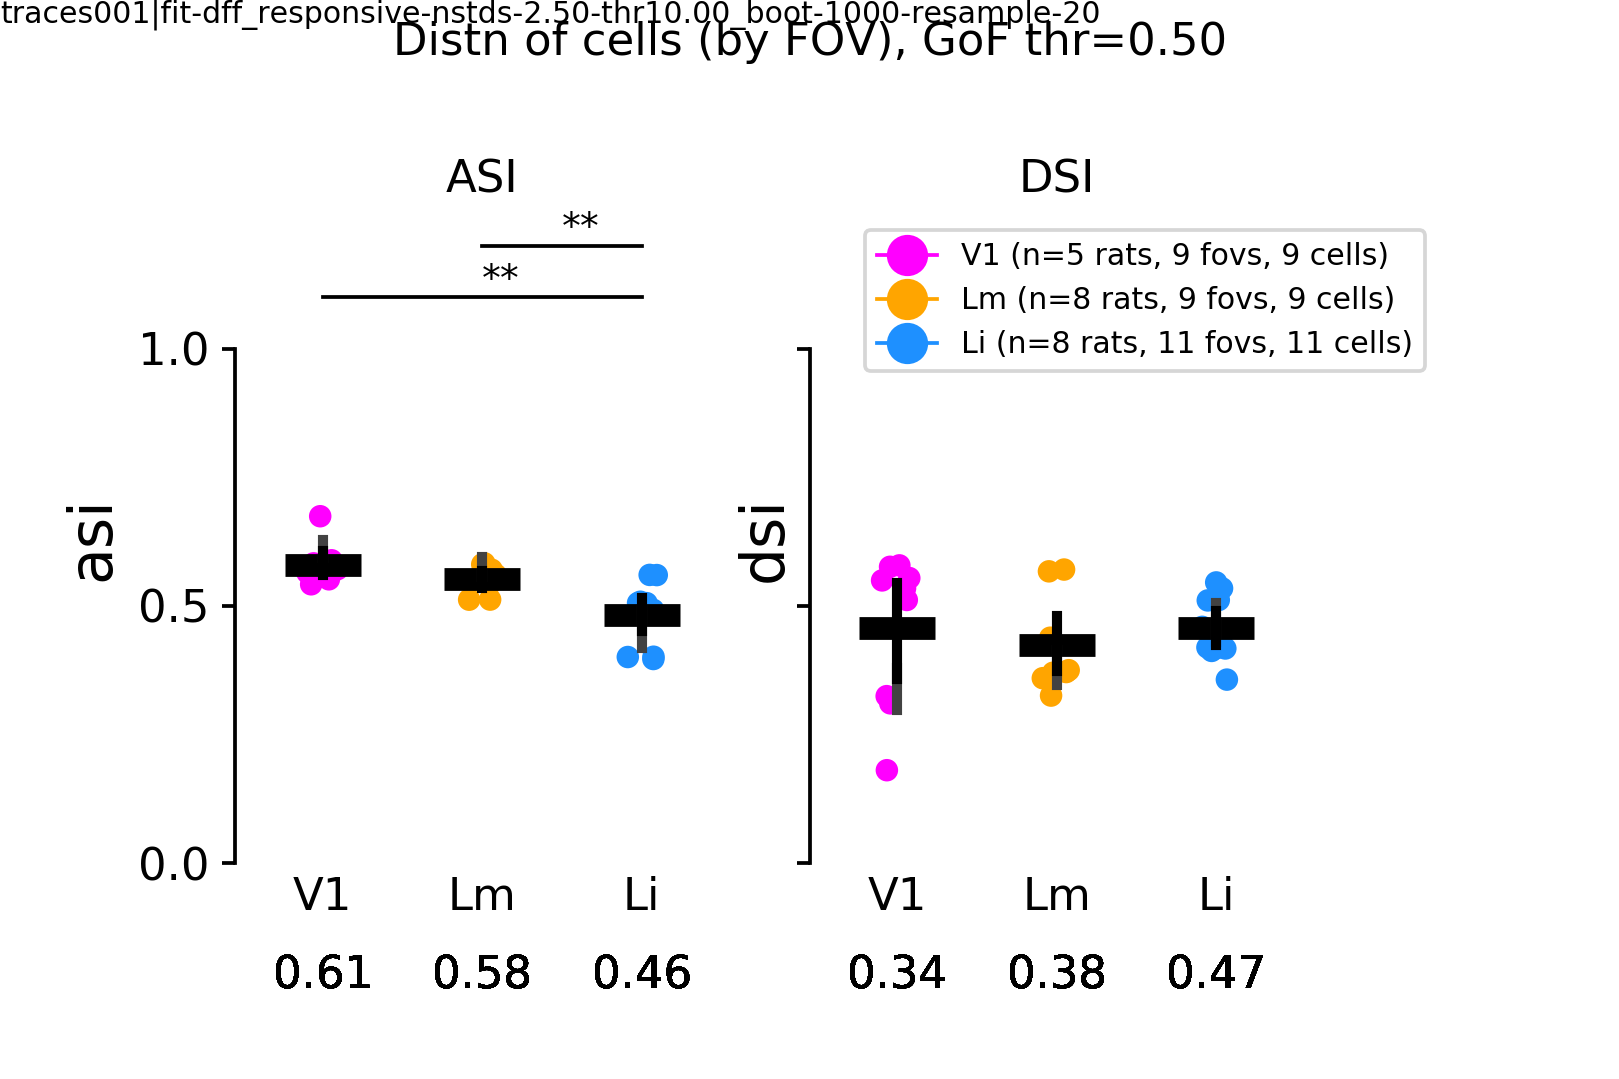

********* [asi] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.056 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.001 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.002 (fdr_bh), reject H0=True
****************************
********* [dsi] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.329 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.271 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.271 (fdr_bh), reject H0=False
****************************
asi_dsi_by_FOV__gof-0.50


In [303]:
use_gof=True
fit_thr=0.5

drop_repeats
xdata = gdata[gdata['datakey'].isin(unique_dkeys)].copy() if drop_repeats else gdata.copy() 
cellcounts = update_gof_cells(updated_counts, xdata, gof_thr=fit_thr)
if use_gof:
    currdata = xdata[xdata['gof'] >= fit_thr].copy()
    thr_str = 'gof-%.2f' % fit_thr 
else:
    currdata = xdata[xdata['r2comb'] >= fit_thr].copy()
    thr_str = 'r2comb-%.2f' % fit_thr 

means_by_fov = xdata.groupby(['visual_area', 'datakey']).mean().reset_index()


fig, axes = pl.subplots(1,2, sharex=True, sharey=True, figsize=(6,4), dpi=dpi)
fig.patch.set_alpha(1)

ax = axes[0]
ax.set_title('ASI')
ax = plot_strip_and_bar('asi', means_by_fov, use_median=False, use_bar=False, ax=ax,
                    area_colors=area_colors, point_size=6, marker='o', bar_scale=3,
                    annotate=True, fontsize=12, xytext=(0, -30))


# Stats
stats_dsi, ax = aggr.plot_mannwhitney(means_by_fov, metric='asi', ax=ax, multi_comp_test=multi_comp_test, 
                                    y_loc=1, offset=0.1)
ax = axes[1]
ax.set_title('DSI')
ax = plot_strip_and_bar('dsi', means_by_fov, use_median=False, use_bar=False, ax=ax,
                    area_colors=area_colors, point_size=6, marker='o', bar_scale=3,
                    annotate=True, fontsize=12, xytext=(0, -30))
# Stats
stats_dsi, ax = aggr.plot_mannwhitney(means_by_fov, metric='dsi', ax=ax, multi_comp_test=multi_comp_test, 
                                    y_loc=1, offset=0.1)


# formatting
pl.subplots_adjust(wspace=0.2, right=0.8, top=0.8, bottom=0.2, left=0.15)
for ax in axes:
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xlabel('')
    
    ax.set_yticks([0, 0.5, 1])
    sns.despine(ax=ax, trim=True, offset=2, bottom=True)
    
# Legend.
leg = aggr.get_counts_for_legend(means_by_fov, area_colors=area_colors, marker='o')
ax.legend(handles=leg, bbox_to_anchor=(1.3, 1), fontsize=8)


fig.suptitle("Distn of cells (by FOV), %s thr=%.2f" % ('GoF' if use_gof else 'combined R2', 
                                              fit_thr)) #curr_gof)

    
putils.label_figure(fig, data_id)
figname = 'asi_dsi_by_FOV__%s' % (thr_str)
pl.savefig(os.path.join(dstdir, '%s.svg' % figname))
print figname

## DistN ASI/DSI

<IPython.core.display.Javascript object>


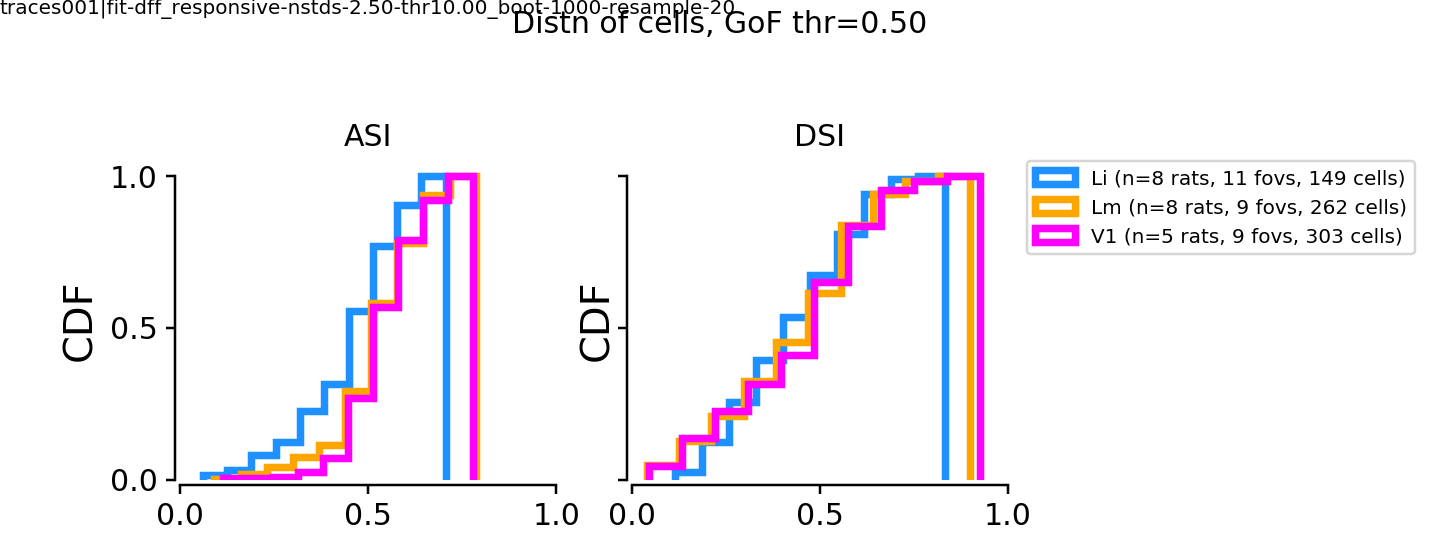

asi_dsi_allcells_CDF__gof-0.50_drop_repeats


In [305]:
use_gof=True
fit_thr=0.5


drop_repeats=True

xdata = gdata[gdata['datakey'].isin(unique_dkeys)].copy() if drop_repeats else gdata.copy() 
cellcounts = update_gof_cells(updated_counts, xdata, gof_thr=fit_thr)
if use_gof:
    currdata = xdata[xdata['gof'] >= fit_thr].copy()
    thr_str = 'gof-%.2f' % fit_thr 
else:
    currdata = xdata[xdata['r2comb'] >= fit_thr].copy()
    thr_str = 'r2comb-%.2f' % fit_thr 
thr_str = '%s_drop_repeats' % thr_str if drop_repeats else thr_str    


cdf = True
alpha = 1

fig, axes = pl.subplots(1,2, sharex=True, sharey=True, figsize=(8,3))
fig.patch.set_alpha(1)

ax = axes[0]
ax.set_title('ASI')
compare_tuning_metric(xdata, metric='asi', cdf=cdf, area_colors=area_colors, ax=ax, show_legend=False, alpha=alpha)
ax = axes[1]
compare_tuning_metric(xdata, metric='dsi', cdf=cdf, area_colors=area_colors, ax=ax, alpha=alpha)
ax.set_title('DSI')

pl.subplots_adjust(wspace=0.2, right=0.7, top=0.7)

fig.suptitle("Distn of cells, %s thr=%.2f" % ('GoF' if use_gof else 'combined R2', 
                                              fit_thr)) #curr_gof)

for ax in axes:
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    sns.despine(ax=ax, trim=True, offset=2)
    
    
putils.label_figure(fig, data_id)
figname = 'asi_dsi_allcells_CDF__%s' % (thr_str)
#pl.savefig(os.path.join(dstdir, '%s.svg' % figname))
print figname

In [51]:
currdata.groupby(['visual_area']).mean()

asi        cell       dsi       gof        r2    r2comb  \
visual_area                                                                 
Li           0.511383  141.536232  0.586095  0.590663  0.796518  0.814293   
Lm           0.565136  128.957219  0.551166  0.610860  0.801900  0.814219   
V1           0.557908  147.809091  0.548032  0.615619  0.804479  0.816979   

             response_null  response_offset  response_pref      sigma  \
visual_area                                                             
Li                0.017302        -0.001747       0.046966  42.768771   
Lm                0.015005         0.002921       0.038786  38.658663   
V1                0.017980         0.002937       0.044962  38.716021   

             theta_pref  
visual_area              
Li           163.831922  
Lm           147.050591  
V1           168.219002

In [52]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

<IPython.core.display.Javascript object>


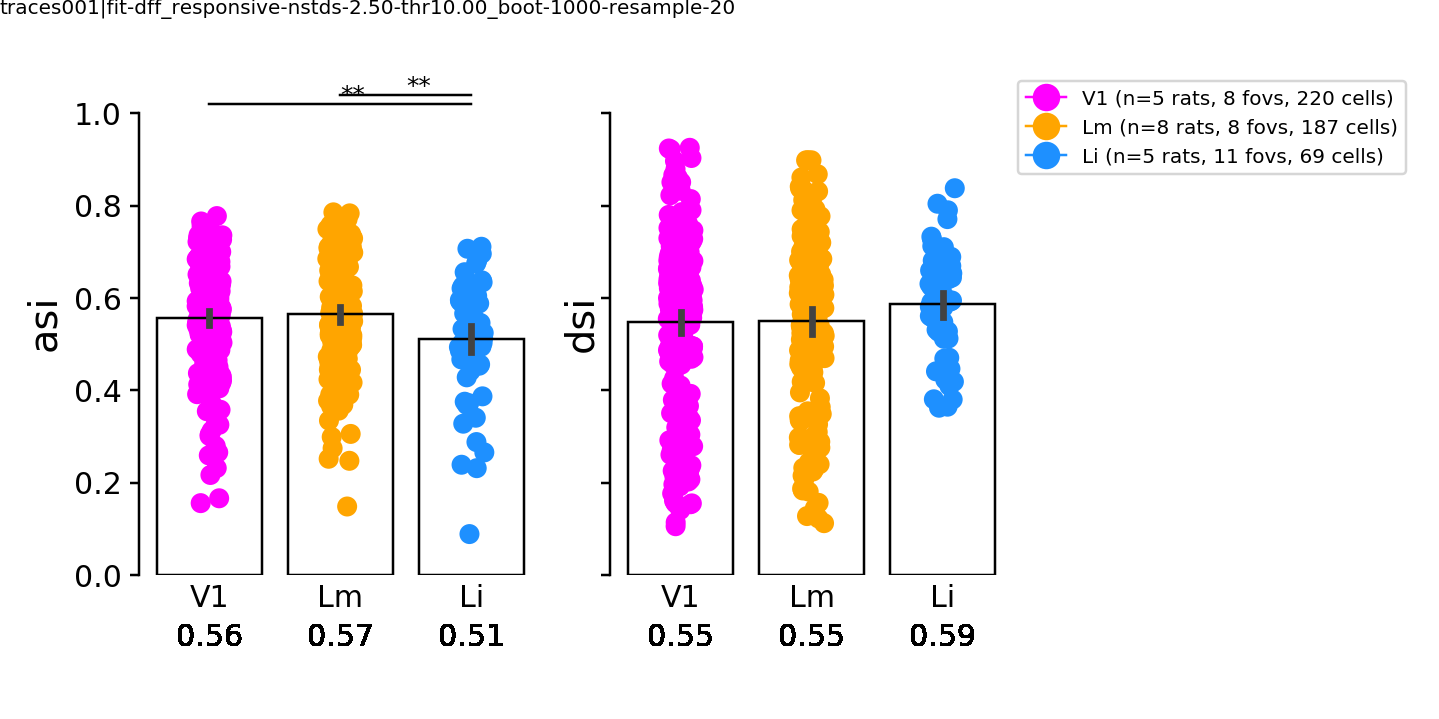

********* [asi] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.318 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.005 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.004 (fdr_bh), reject H0=True
****************************
********* [dsi] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.424 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.338 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.338 (fdr_bh), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'asi_dsi_allcells__gof-0.50')


In [53]:
use_gof=True
fit_thr=0.5

drop_repeats=True

xdata = gdata[gdata['datakey'].isin(unique_dkeys)].copy() if drop_repeats else gdata.copy() 
cellcounts = update_gof_cells(updated_counts, xdata, gof_thr=fit_thr)
if use_gof:
    currdata = xdata[xdata['gof'] >= fit_thr].copy()
    thr_str = 'gof-%.2f' % fit_thr 
else:
    currdata = xdata[xdata['r2comb'] >= fit_thr].copy()
    thr_str = 'r2comb-%.2f' % fit_thr 
thr_str = '%s_drop_repeats' % thr_str if drop_repeats else thr_str    


cdf = True
alpha = 1

fig, axes = pl.subplots(1,2, sharex=True, sharey=True, figsize=(8,4))
fig.patch.set_alpha(1)

# asi ---
ax=axes[0]
sns.stripplot(x='visual_area', y='asi', data=currdata, ax=ax, zorder=0, 
              color='k', s=8, marker='o',order=visual_areas, palette=area_colors)
sns.barplot(x="visual_area", y='asi', data=currdata, ax=ax, 
                 edgecolor=('k', 'k', 'k'), facecolor='none', order=visual_areas)
currdata.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k', xytext=(0, -25))
ax.tick_params(which='both', axis='x', length=0)
ax.set_xlabel('')
# Stats
stats_asi, ax = aggr.plot_mannwhitney(currdata, metric='asi', ax=ax, 
                                                multi_comp_test=multi_comp_test, 
                                                 y_loc=1, offset=0.02)

# dsi ----
ax=axes[1]
sns.stripplot(x='visual_area', y='dsi', data=currdata, ax=ax, zorder=0, 
              color='k', s=8, marker='o',order=visual_areas, palette=area_colors)
sns.barplot(x="visual_area", y='dsi', data=currdata, #fliersize=0,
                 edgecolor=('k', 'k', 'k'), facecolor='none', ax=ax, order=visual_areas) #, alpha=0.7) #,\
currdata.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k', xytext=(0, -25))

ax.tick_params(which='both', axis='x', length=0)
ax.set_xlabel('')

# Stats
stats_dsi, ax = aggr.plot_mannwhitney(currdata, metric='dsi', ax=ax, 
                                                multi_comp_test=multi_comp_test, 
                                                 y_loc=1, offset=0.02)


# Legend.
leg = aggr.get_counts_for_legend(currdata[currdata['datakey']\
                                          .isin(plotdf['datakey'].unique())],
                                          area_colors=area_colors, marker='o')
ax.legend(handles=leg, bbox_to_anchor=(1.,1), fontsize=8)


# Formatting
sns.despine(bottom=True, trim=True, offset=2)
ax.tick_params(which='both', axis='x', size=0)
pl.subplots_adjust(top=0.9, left=0.1, bottom=0.2, right=0.7)


# Save
putils.label_figure(fig, data_id)
figname = 'asi_dsi_allcells__%s' % (thr_str)
pl.savefig(os.path.join(dstdir, '%s.svg' % figname))
print(dstdir, figname)

# Set output dir for aggregate figures

## Preferred theta

In [306]:
import matplotlib.patches as mpatches

In [307]:
def make_polar_legend(fig, widths, radii, ylim=None, yticks=None):
    # Legends
    leg = fig.add_axes([0.6, 0.7, 0.5, .2], polar=True)
    leg.set_theta_zero_location("N")
    
    bars = leg.bar(widths, radii, width=.2, bottom=0.0, lw=2)
    for r,bar in zip(radii, bars):
        bar.set_alpha(0.7)
    leg.set_theta_zero_location("N")

    if ylim is not None:
        leg.set_ylim([0, ylim])
    else:
        ylim = leg.get_ylim()[-1]
    if yticks is not None:
        leg.set_yticks(yticks)
        leg.set_yticklabels(yticks)
    return leg

<IPython.core.display.Javascript object>


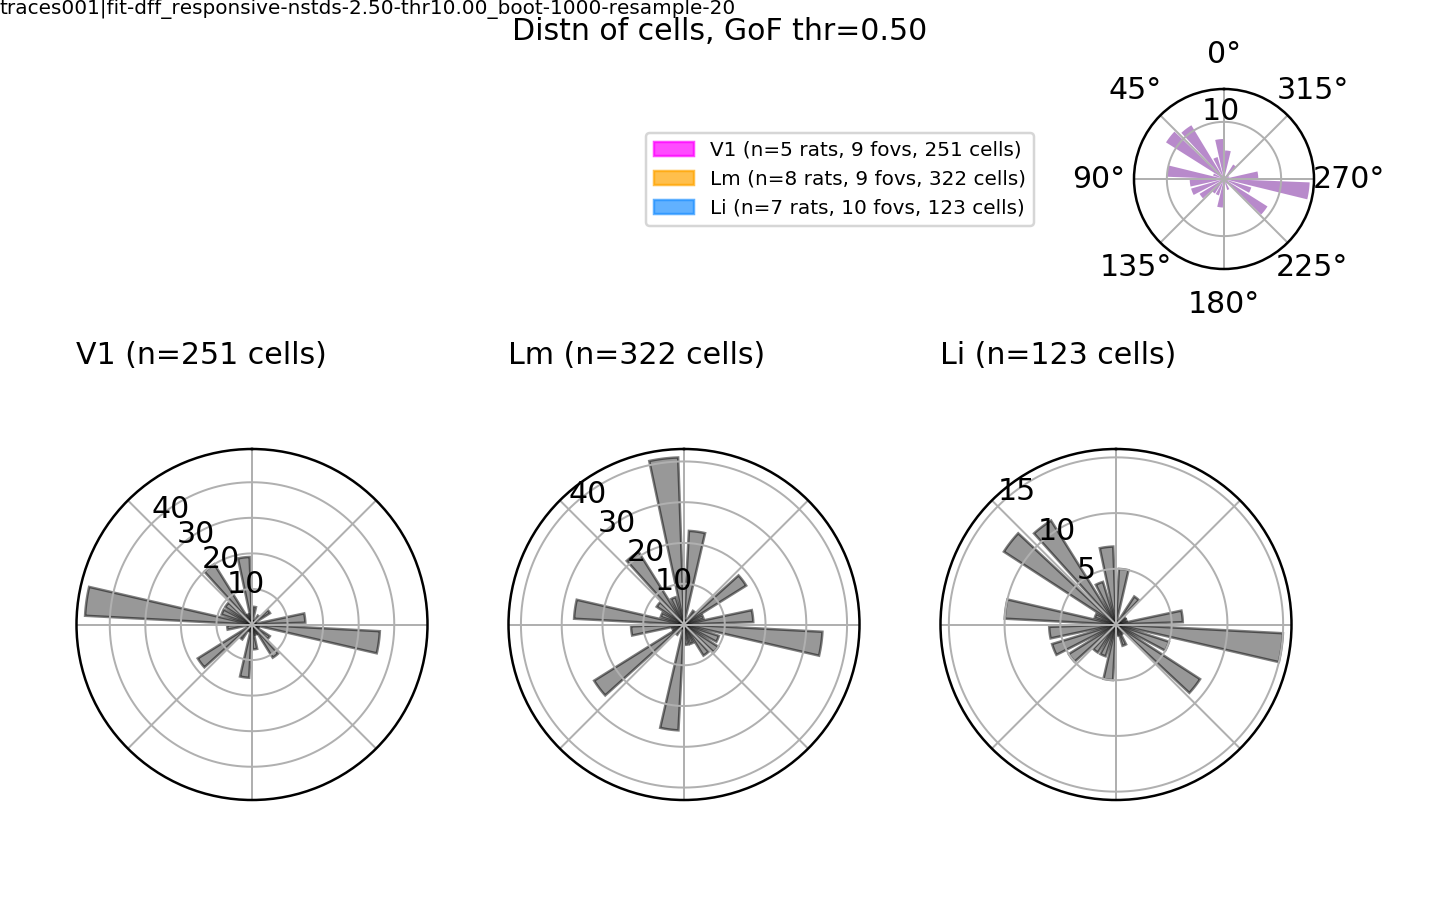

('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'polar_distn_preferred_thetas_gof-0.50_drop_repeats')


In [312]:
use_gof=True
fit_thr=0.5

filter_dsi=False
dsi_thr=0.5

drop_repeats=True
xdata = gdata[gdata['datakey'].isin(unique_dkeys)].copy() if drop_repeats else gdata.copy() 
cellcounts = update_gof_cells(updated_counts, xdata, gof_thr=fit_thr)
if use_gof:
    currdata = xdata[(xdata['gof'] >= fit_thr) | (xdata['r2comb']>=fit_thr)].copy()
    thr_str = 'gof-%.2f' % fit_thr 
else:
    currdata = xdata[xdata['r2comb'] >= fit_thr].copy()
    thr_str = 'r2comb-%.2f' % fit_thr 
thr_str = '%s_drop_repeats' % thr_str if drop_repeats else thr_str    


bin_size = 15
bins = np.arange(0, 360+bin_size, bin_size)

if filter_dsi:
    currdata = currdata[currdata['dsi']>=dsi_thr]
    thr_str = '%s_dsi-%.2f' % (thr_str, dsi_thr)
    
polar_legend=True
fig = pl.figure(figsize=(8,5))
fig.patch.set_alpha(1)
bar_width = 10
lbs=[]
#yticks = np.linspace(0, ylim, nradii)
#ymax = 1.5
for vi, visual_area in enumerate(visual_areas):
    tmpg = currdata.groupby(['visual_area']).get_group(visual_area).copy()
    
    degrees = tmpg['theta_pref'].values
    radians = np.rad2deg(degrees)
    
    ax = pl.subplot(1,3,vi+1, projection='polar')
    a, b = np.histogram(degrees, bins=bins)
    centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])

    ax = pl.subplot(1,3,vi+1, projection='polar')
    ax.bar(centers, a, width=np.deg2rad(bar_width), bottom=0.0, color='.2', alpha=0.5, edgecolor='k')
    ax.set_theta_zero_location("N")
    #ax.set_theta_direction(-1)

    ax.set_rlabel_position(45)
    ax.set_xticklabels([])
    #ax.set_ylim([0, 30])
    ax.set_title('%s (n=%i cells)' % (visual_area, tmpg.shape[0]), loc='left', fontsize=12, y=1.2)

    nrats = len(tmpg['animalid'].unique())
    nfovs = len(tmpg['session'].unique())
    ncells = tmpg.shape[0]
    lbs.append('%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells))

pl.subplots_adjust(wspace=0.2, top=0.8, left=0.05, right=0.9)


#for ax in fig.axes:
#ylim = max([ax.get_ylim() for ax in fig.axes])
    
if polar_legend:
    pl.subplots_adjust(wspace=0.2, top=0.5, left=0.05, right=0.9)
    ylim = None
    leg = make_polar_legend(fig, centers, a, ylim=ylim, yticks=None)


legend_handles = [mpatches.Patch(color=area_colors[visual_area], label=lb, alpha=0.7)\
                  for visual_area, lb in zip(visual_areas, lbs)]
leg.legend(bbox_to_anchor=(-0.5, .5), loc='right', ncol=1, handles=legend_handles, fontsize=8)


fig.suptitle("Distn of cells, %s thr=%.2f" % ('GoF' if use_gof else 'combined R2', 
                                              fit_thr)) #curr_gof)
putils.label_figure(fig, data_id)

figname = 'polar_distn_preferred_thetas_%s' % thr_str
print(dstdir, figname)
pl.savefig(os.path.join(dstdir, '%s.svg' % figname))

In [87]:
currdata[currdata['datakey']=='20190522_JC084_fov1'].sort_values(by='dsi')

asi   cell       dsi       gof        r2    r2comb  response_null  \
98   0.595570   98.0  0.112420  0.744269  0.867533  0.876976       0.026848   
135  0.735287  135.0  0.135509  0.820356  0.900279  0.921092       0.073031   
91   0.766686   91.0  0.191354  0.752994  0.872534  0.881872       0.030578   
206  0.722037  206.0  0.223453  0.621803  0.788113  0.816852       0.023210   
232  0.712673  232.0  0.299944  0.730319  0.855392  0.889561       0.027919   
75   0.514057   75.0  0.300033  0.666737  0.808680  0.821545       0.087740   
125  0.539109  125.0  0.315235  0.514993  0.733637  0.734085       0.038399   
93   0.727109   93.0  0.364414  0.685340  0.813818  0.844795       0.023528   
136  0.565690  136.0  0.389502  0.648690  0.816332  0.862682       0.024490   
137  0.408438  137.0  0.502290  0.508744  0.751168  0.802102       0.029640   
177  0.464044  177.0  0.505653  0.586959  0.777014  0.900609       0.013214   
65   0.549056   65.0  0.524932  0.651415  0.820993  0.870074       0.019825   
55   0.549696   55.0  0.543516  0.604463  0.791755  0.786589       0.018539   
242  0.481929  242.0  0.547682  0.510824  0.753779  0.813960       0.006941   
205  0.680853  205.0  0.553360  0.731685  0.849136  0.857172       0.013022   
134  0.399649  134.0  0.581321  0.588154  0.787946  0.899128       0.014735   
0    0.375743    0.0  0.581361  0.500770  0.731655  0.800259       0.003201   
132  0.633494  132.0  0.589284  0.557175  0.848906  0.621296       0.011742   
17   0.698706   17.0  0.599067  0.523341  0.708746  0.692823       0.012288   
166  0.410185  166.0  0.609504  0.536976  0.773928  0.697926       0.010923   
216  0.490926  216.0  0.611412  0.525532  0.755527  0.713599       0.031022   
215  0.671792  215.0  0.626650  0.734894  0.853596  0.900104       0.006971   
57   0.326129   57.0  0.627216  0.549860  0.757418  0.796701       0.006354   
231  0.366289  231.0  0.640142  0.515822  0.770248  0.714390       0.009488   
255  0.674017  255.0  0.640223  0.870902  0.932759  0.947120       0.009655   
235  0.449839  235.0  0.645072  0.522455  0.750392  0.791686       0.017431   
203  0.383484  203.0  0.653752  0.608057  0.785145  0.904263       0.015488   
51   0.587629   51.0  0.654553  0.651721  0.832557  0.843665       0.005986   
179  0.585395  179.0  0.664249  0.674831  0.841494  0.862959       0.009050   
67   0.545474   67.0  0.667648  0.523715  0.789483  0.741292       0.008642   
59   0.458451   59.0  0.680952  0.513765  0.763908  0.772450       0.005593   
148  0.555184  148.0  0.695578  0.723922  0.868979  0.919647       0.006257   
45   0.582571   45.0  0.734326  0.611626  0.805361  0.858436       0.006237   
33   0.560842   33.0  0.742678  0.559555  0.795610  0.723587       0.005422   
119  0.559457  119.0  0.748830  0.541447  0.782412  0.794892       0.004926   
168  0.654217  168.0  0.752601  0.639415  0.804322  0.825005       0.003596   
107  0.506528  107.0  0.762923  0.556172  0.788158  0.723308       0.003786   
44   0.689931   44.0  0.781766  0.526031  0.781455  0.797662       0.004712   
144  0.596014  144.0  0.793800  0.701802  0.854266  0.870855       0.003697   
106  0.673791  106.0  0.821842  0.718378  0.858495  0.867766       0.004345   
156  0.583559  156.0  0.843714  0.567575  0.755453  0.709547       0.000546   
147  0.692661  147.0  0.897972  0.825721  0.914480  0.925733       0.000584   
151  0.732046  151.0  0.921954  0.748559  0.855346  0.861370       0.000212   
30   0.734430   30.0  0.924078  0.849024  0.913927  0.920232       0.000076   
163  0.734152  163.0  0.925497  0.772097  0.868158  0.873148       0.000009   

     response_offset  response_pref      sigma  theta_pref   session  \
98          0.002857       0.031315  33.071669  211.872616  20190522   
135         0.040635       0.097718  22.558950  266.404236  20190522   
91          0.017531       0.043036  22.508458    1.313660  20190522   
206         0.014762       0.037351  22.531939   48.061589  20190522   
232         0.0

In [105]:
[ax.get_ylim() for ax in fig.axes]

[(0.0, 29.4), (0.0, 19.95), (0.0, 9.45), (0.0, 9.45)]

## Preferred theta, scale radius by response value(dff)

<IPython.core.display.Javascript object>


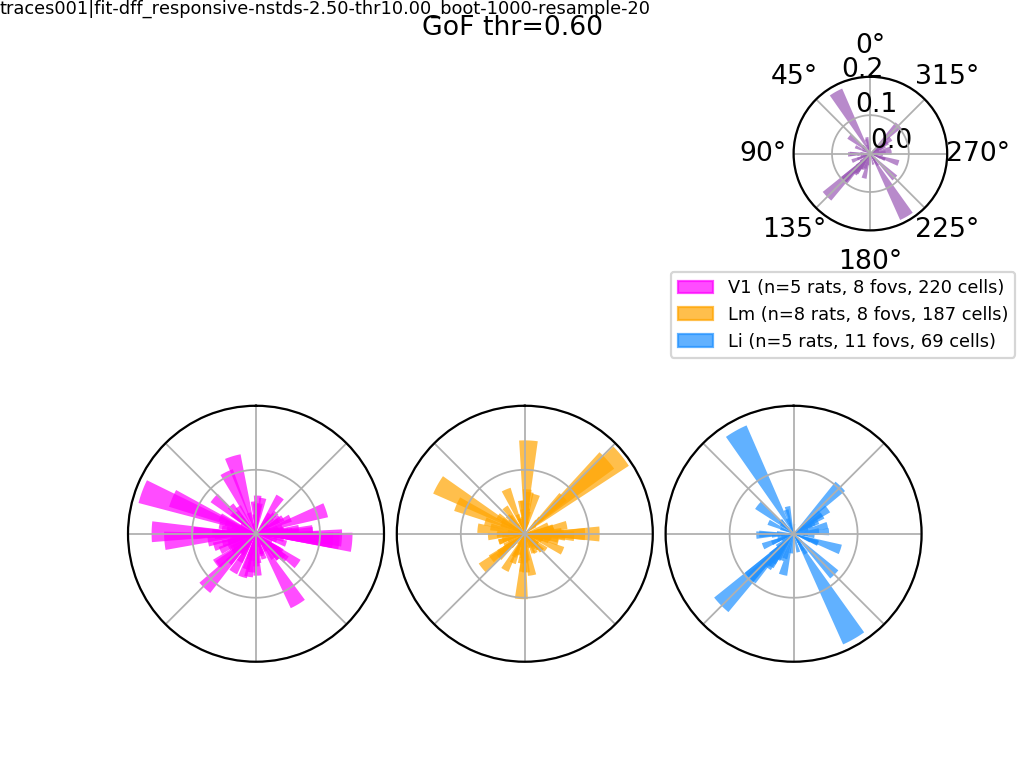

('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'polar_distn_preferred_thetas_scale-dff_gof-0.50')


In [102]:
fig = pl.figure()
fig.patch.set_alpha(1)
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
lbs = []
ylim = .2 #8 #.0

#ymax = 1.5
for vi, visual_area in enumerate(visual_areas):
    g = currdata.groupby(['visual_area']).get_group(visual_area) #enumerate(gdata.groupby(['visual_area'])):
    ax = pl.subplot(1,3,vi+1, projection='polar')
    tmpg = g.copy()
    radii = tmpg['response_pref'] #/tmpg['response_pref'].max()
    thetas = np.deg2rad( np.arange(0, 360, 45) )
    widths = np.deg2rad( tmpg['theta_pref'].values )


    bars = ax.bar(widths, radii, width=.2, bottom=0.0, color=area_colors[visual_area], lw=2)
    for r,bar in zip(radii, bars):
        bar.set_alpha(0.7)
        
    ax.set_theta_zero_location("N")
    ax.set_xticks(thetas)
    ax.set_xticklabels([''])
    
    ax.set_ylim([0, ylim])
    yticks = np.linspace(0, ylim, 3)
    ax.set_yticks(yticks)
    #ax.set_yticks([0, 1.0, 1.5, 2.0])
    ax.set_yticklabels(['', '', ''])
    #ax.set_ylabel('dff')
    

    nrats = len(tmpg['animalid'].unique())
    nfovs = len(tmpg['session'].unique())
    ncells = tmpg.shape[0]
    lbs.append('%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells))


pl.subplots_adjust(top=0.5, wspace=0.05)
leg = make_polar_legend(fig, widths, radii, ylim=ylim, yticks=yticks)


legend_handles = [mpatches.Patch(color=area_colors[visual_area], label=lb, alpha=0.7)\
                  for visual_area, lb in zip(visual_areas, lbs)]
leg.legend(bbox_to_anchor=(1.5, -0.55), loc='right', ncol=1, handles=legend_handles, fontsize=8)

putils.label_figure(fig, data_id)
fig.suptitle("GoF thr=%.2f" % curr_gof)
#ax.set_ylabel('dff')
figname = 'polar_distn_preferred_thetas_scale-%s_%s' % (response_type, thr_str)

#pl.savefig(os.path.join(dstdir, '%s.svg' % figname))
print(dstdir, figname)

## Distn of preferred theta if axis-selective

<IPython.core.display.Javascript object>


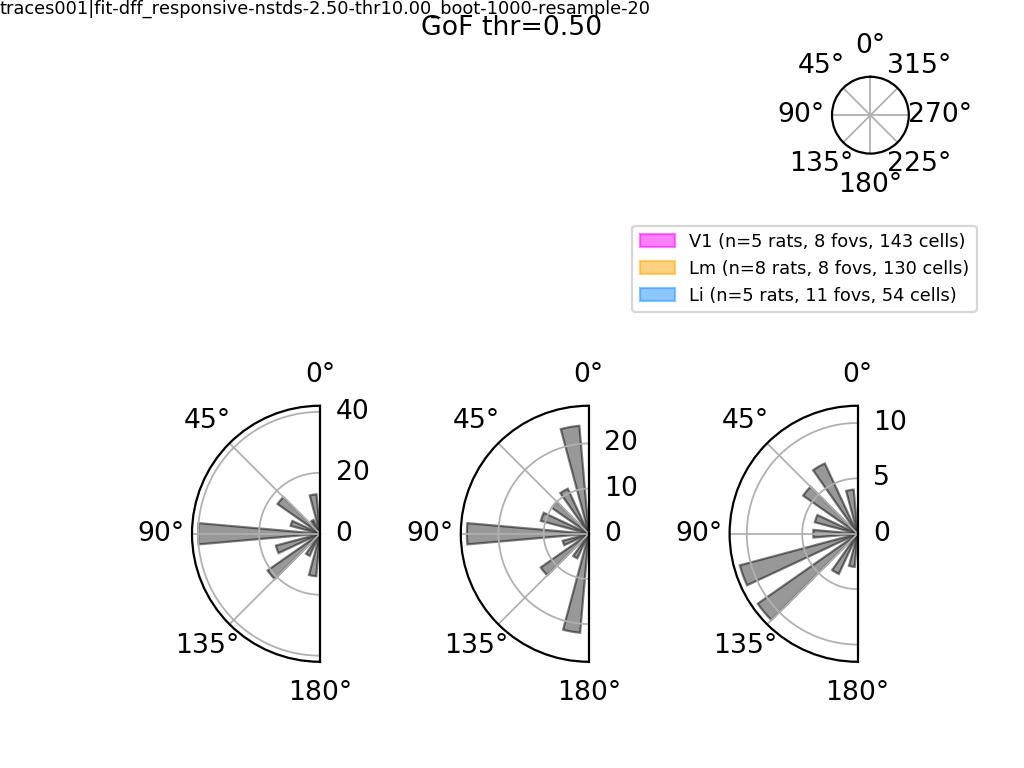

('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'polar_distn_ASI_preferred_thetas__gof-0.50_dsi-0.50')


In [103]:

use_gof=True


filter_dsi=True

dsi_thr=0.5
fit_thr=0.5 
cellcounts = update_gof_cells(updated_counts, gdata, gof_thr=curr_gof)

if use_gof:
    currdata = gdata[gdata['gof'] >= fit_thr].copy()
    thr_str = 'gof-%.2f' % fit_thr 
else:
    currdata = gdata[gdata['r2comb'] >= fit_thr].copy()
    thr_str = 'r2comb-%.2f' % fit_thr 


if filter_dsi:
    currdata = currdata[currdata['dsi']>=dsi_thr]
    thr_str = '%s_dsi-%.2f' % (thr_str, dsi_thr)
    
    
polar_legend=True
fig = pl.figure()
fig.patch.set_alpha(1)
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
lbs = []
for vi, visual_area in enumerate(visual_areas):
    g = currdata[currdata['visual_area']==visual_area].copy() #get_group(visual_area) #enumerate(gdata.groupby(['visual_area'])):
    ax = pl.subplot(1,3,vi+1, projection='polar')
    tmpg = g[g['asi']>=0.1]

    thetas = np.deg2rad(np.arange(0, 180+45, 45))
    ax.set_xticks(thetas)
    #ax.set_xticklabels([''])
    ax.set_xlim([thetas[0], thetas[-1]])

    degrees = tmpg['theta_pref'].values % 180.

    bin_size = 20. #45.
    a, b =np.histogram(degrees, bins=np.arange(0, 180+bin_size, bin_size))
    centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
    
    ax = pl.subplot(1,3,vi+1, projection='polar')
    ax.bar(centers, a, width=np.deg2rad(bar_width), bottom=0.0, color='.2', alpha=0.5, edgecolor='k')
    ax.set_theta_zero_location("N")
    
    nrats = len(tmpg['animalid'].unique())
    nfovs = len(tmpg['session'].unique())
    ncells = tmpg.shape[0]
    lbs.append('%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells))

pl.subplots_adjust(top=0.5, wspace=0.05)
# Legends
leg = fig.add_axes([0.8, 0.8, 0.1, 0.1], polar=True)
leg.set_yticks([])
leg.set_theta_zero_location("N")
legend_handles = [mpatches.Patch(color=area_colors[visual_area], label=lb, alpha=0.5)\
                  for visual_area, lb in zip(visual_areas, lbs)]
leg.legend(bbox_to_anchor=(2, -1.5), loc='right', ncol=1, 
           handles=legend_handles, fontsize=8)

# Label
putils.label_figure(fig, data_id)
fig.suptitle('%s thr=%.2f' % ('GoF' if use_gof else 'R2-comb', fit_thr)) #curr_gof))


figname = 'polar_distn_ASI_preferred_thetas__%s' % (thr_str)
#pl.savefig(os.path.join(dstdir, '%s.png' % figname))
print(dstdir, figname)

# Hist (non polar) of preferred theta, assign by tested value

In [314]:
tested_values = np.linspace(0, 360-45., 8)
print(tested_values)
tested_thetas = list(tested_values.copy())
tested_thetas.append(360)

tested_thetas = np.array(tested_thetas)

gdata['tested_theta'] = [tested_thetas[np.where(np.abs(t-tested_thetas)==np.min(np.abs(t-tested_thetas)))[0][0]] % 360. \
                            for t in gdata['theta_pref']]
tested_thetas = tested_thetas[0:-1]

[  0.  45.  90. 135. 180. 225. 270. 315.]


In [315]:
for t in gdata['theta_pref']:
    closest_match = int(tested_thetas[np.where(np.abs(t-tested_thetas)== np.min(np.abs(t-tested_thetas)))])
    #print round(t,2), closest_match

<IPython.core.display.Javascript object>


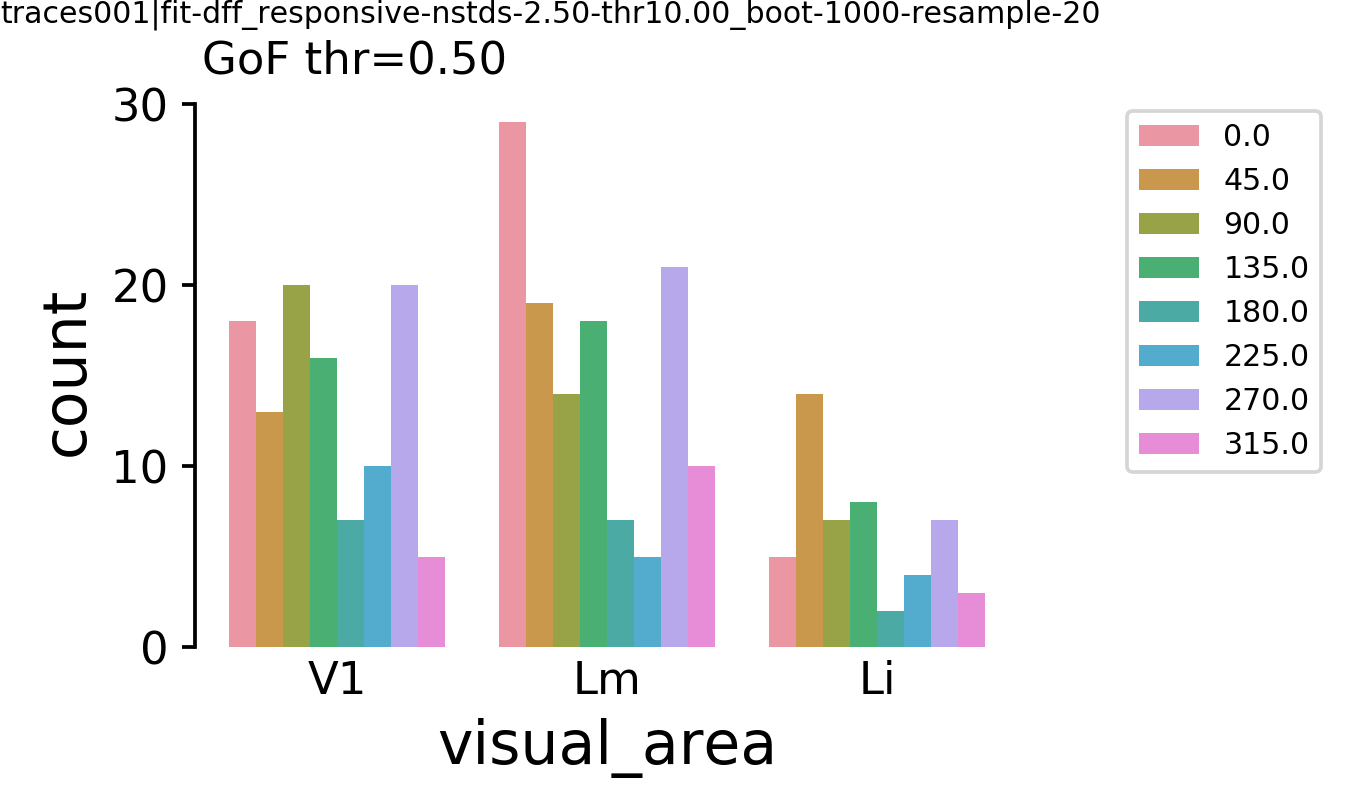

('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'hist_tested_thetas__gof-0.50_drop_repeats_dsi-0.50')


In [316]:
use_gof=True
fit_thr=0.5 

filter_dsi=True
dsi_thr=0.5

drop_repeats=True
xdata = gdata[gdata['datakey'].isin(unique_dkeys)].copy() if drop_repeats else gdata.copy() 
cellcounts = update_gof_cells(updated_counts, xdata, gof_thr=fit_thr)
if use_gof:
    currdata = xdata[(xdata['gof'] >= fit_thr) | (xdata['r2comb']>=fit_thr)].copy()
    thr_str = 'gof-%.2f' % fit_thr 
else:
    currdata = xdata[xdata['r2comb'] >= fit_thr].copy()
    thr_str = 'r2comb-%.2f' % fit_thr 
thr_str = '%s_drop_repeats' % thr_str if drop_repeats else thr_str    


    
if filter_dsi:
    currdata = currdata[currdata['dsi']>=dsi_thr]
    thr_str = '%s_dsi-%.2f' % (thr_str, dsi_thr)
    
    
polar_legend=True
fig, ax = pl.subplots(figsize=(5,3), dpi=dpi)
sns.countplot(x='visual_area',  hue='tested_theta', data=currdata,
             ax=ax, order=visual_areas)
ax.legend(bbox_to_anchor=(1.4, 1), fontsize=8)
sns.despine(bottom=True, offset=2, trim=True, ax=ax)
ax.tick_params(which='both', axis='x', size=0)
pl.subplots_adjust(left=0.15, right=0.75, bottom=0.2)

putils.label_figure(fig, data_id)
ax.set_title("%s thr=%.2f" % ('GoF' if use_gof else 'R2-comb', fit_thr), loc='left')

figname = 'hist_tested_thetas__%s' % (thr_str)
#pl.savefig(os.path.join(dstdir, '%s.png' % figname))
print(dstdir, figname)

In [330]:
currdata.shape

(436, 17)

## overlay hists


<IPython.core.display.Javascript object>


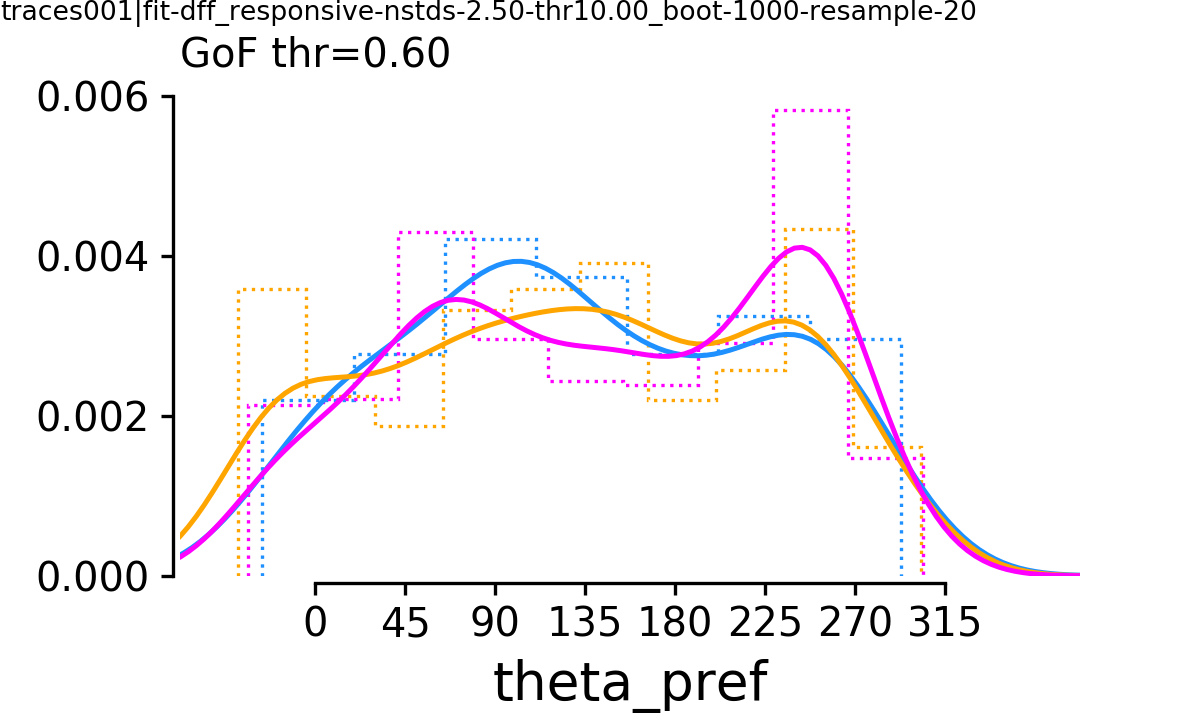

('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'hist-overlay_tested_thetas__gof-0.60')


In [106]:
fig, ax = pl.subplots(figsize=(5,3), dpi=dpi)
for visual_area, g in gdata.groupby(['visual_area']):
    
    sns.distplot(g['theta_pref'], ax=ax, color=area_colors[visual_area],
                 rug=False, hist=True,
                 hist_kws={"histtype": "step", "linewidth": 1, "alpha": 1, "linestyle": ':'})
    
ax.set_xticks(tested_thetas+(45/2.))
ax.set_xticklabels([int(x) for x in tested_thetas])
ax.set_xlim([-45, 360+45])
    
pl.subplots_adjust(left=0.15, right=0.9, bottom=0.2)
putils.label_figure(fig, data_id)
ax.set_title("GoF thr=%.2f" % curr_gof, loc='left')
sns.despine(trim=True, offset=2, ax=ax)

figname = 'hist-overlay_tested_thetas__gof-%.2f' % (curr_gof)
pl.savefig(os.path.join(dstdir, '%s.png' % figname))
print(dstdir, figname)

# Receptive fields?

In [317]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True, zero_location='N', edgecolor='k'):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if isinstance(bins, (int, float)):
        if not gaps:
            bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / float(x.size)
        # Calculate corresponding bin radius
        radii = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radii = n

    # Plot data on ax
    bars = ax.bar(bins[:-1], radii, zorder=1, align='edge', width=widths,
                     edgecolor=edgecolor, fill=True, linewidth=1)

    # Set the direction of the zero angle
    #ax.set_theta_offset(offset)
    ax.set_theta_zero_location(zero_location)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    # Use custom colors and opacity
    for r, bar in zip(radii, bars):
        bar.set_facecolor(pl.cm.jet(r / 10.))
        bar.set_alpha(0.8)


    return n, bins, bars

In [318]:
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from matplotlib.patches import Ellipse, Rectangle, Polygon

def get_icon(name, icon_type='ori'):
    src = '/n/coxfs01/julianarhee/legends/%s/%s%03d.png' % (icon_type, icon_type, name)
    #print(src)
    im = pl.imread(src)
    return im

def offset_image(coord, ax, name=None, pad=0, xybox=(0, 0), xycoords=('data'), yloc=None, zoom=1.0):
    img = get_icon(name)
    im = OffsetImage(img, zoom=zoom)
    im.image.axes = ax
    
    if yloc is None:
        yloc=ax.get_ylim()[-1]
    ab = AnnotationBbox(im, (coord, yloc), xybox=xybox, frameon=False,
                        xycoords=xycoords,
                        boxcoords="offset points", pad=pad, annotation_clip=False)
    ax.add_artist(ab)
    
    return yloc

def replace_ori_labels(ori_names, bin_centers=None, ax=None, xybox=(0, 0), yloc=None,
                       zoom=0.25, pad=0, polar=False):
    if polar:
        xycoords=("data")
        for i, c in enumerate(ori_names):
            yloc = offset_image(np.deg2rad(c), ax, name=c, xybox=xybox, xycoords=xycoords, 
                                yloc=yloc,  pad=pad, zoom=zoom)
            ax.set_xticklabels([])
        #if yloc is not None:
        #ax.set_ylim([0, yloc])
        ax.spines['polar'].set_visible(False)
    else:
        xycoords=("data", "axes fraction")
        if bin_centers is None:
            bin_centers = ori_names
        for i, (binloc, binval) in enumerate(zip(bin_centers, ori_names)):
            yloc = offset_image(binloc, ax, name=binval, xybox=xybox, xycoords=xycoords,
                                yloc=yloc, pad=pad, zoom=zoom)
            ax.set_xticklabels([])
    
    return ax

In [319]:
def split_by_angle(df_, bin_value, metric='theta_Mm_deg', boundary_value=180, bin_size=45, combine_zero=True):
    
    ori_bins = np.arange(-boundary_value, boundary_value+bin_size, bin_size)
        
    #angles = (degs + 180.) % (2*180.) - 180.
    half_bin = bin_size/2.

    if bin_value == -boundary_value:
        bmin = boundary_value - half_bin # 90 - 22.5
        bmax = -boundary_value + half_bin  # -90 + 22.5 
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric]<=bmax]
            #n_in_bin = len(angles[angles<=bmax])
    elif bin_value == boundary_value:
        bmin = boundary_value - half_bin
        bmax = -boundary_value + half_bin
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric] >= bmin]
            #n_in_bin = len(angles[angles>=bmin])
    else:
        bmin = bin_value - half_bin
        bmax = bin_value + half_bin
        curr_vs = df_[ (df_[metric] >= bmin) & (df_[metric] <= bmax) ]
        #n_in_bin = len(angles[(angles >= bmin) & (angles<=bmax)])

    #n_in_bin = np.where([angles<])
    #bin_counts.append(n_in_bin)

    return curr_vs #bin_counts, ori_bins


def wrap_values(degs, degrees=True):
    if degrees:
        return (degs + 180.) % (2*180.) - 180.
    else:
        return (degs + np.pi) % (2*np.pi) - np.pi

In [320]:

def get_angle_counts(degs, bin_size=45, ori_bins=None, combine_zero=True):
    if ori_bins is None:
        ori_bins = np.arange(-180, 180+bin_size, bin_size)
    #else:
    #   ori_bins = (ori_bins + 180.) % (2*180.) - 180.
        
    angles = (degs + 180.) % (2*180.) - 180.

    half_bin = bin_size/2.
    
    bin_counts=[]
    for a in ori_bins:
        
        if a==-180:
            bmin = 180-half_bin
            bmax = -180+half_bin 
            if combine_zero:
                n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
            else:
                n_in_bin = len(angles[angles<=bmax])
        elif a==180:
            bmin = 180-half_bin
            bmax = -180+half_bin
            if combine_zero:
                n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
            else:
                n_in_bin = len(angles[angles>=bmin])
        else:
            bmin = a-half_bin
            bmax = a+half_bin
            n_in_bin = len(angles[(angles >= bmin) & (angles<=bmax)])

        #n_in_bin = np.where([angles<])
        bin_counts.append(n_in_bin)

    return bin_counts, ori_bins

In [321]:
def add_subplot_axes(ax,rect,axisbg='w', axis_alpha=1):
    '''
    https://stackoverflow.com/questions/17458580/embedding-small-plots-inside-subplots-in-matplotlib
    '''
    fig = pl.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    subax.patch.set_alpha(axis_alpha)
    
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    
    return subax

In [322]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

In [323]:
#sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
rf_dsets = sdata[sdata['experiment'].isin(['rfs', 'rfs10'])]

#assigned_cells = seg.get_cells_by_area(rf_dsets)
#incl = aggr.get_dsets_with_max_rfs(rf_dsets, assigned_cells)
#incl[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()
#edata = pd.concat([g for (v, k), g in sdata.groupby(['visual_area', 'datakey']) if k in incl['datakey'].values])

In [324]:
rf_fit_desc = fitrf.get_fit_desc(response_type='dff', do_spherical_correction=False)

aggr_rf_dir =  os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, rf_fit_desc))
df_fpath = os.path.join(aggr_rf_dir, 'fits_and_coords_None_reliable.pkl') #% ( reliable_str))
print(df_fpath)

get_positions = False
if os.path.exists(df_fpath) or get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            r_df = pkl.load(f)
        if isinstance(r_df, dict):
            r_df = r_df['df']
    except Exception as e:
        get_positions = True
print(get_positions)

rf_cells = seg.get_cells_by_area(rf_dsets)
rf_df = aggr.get_rfdata(rf_cells, r_df, verbose=False, average_repeats=True)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl
Loading existing RF coord conversions...
False
Segmentation: missing 3 dsets


# Get Gratings + RF combo

In [325]:
filter_gratings=True
use_gof=False
gratings_fit_thr=0.5
# ########################

cellcounts = update_gof_cells(updated_counts, gdata, gof_thr=gratings_fit_thr)
if not filter_gratings:
    gratings_df = gdata.copy()
    thr_str = 'allmatches'
else:
    if use_gof:
        gratings_df = gdata[gdata['gof'] >= gratings_fit_thr].copy()
        thr_str = 'gof-%.2f' % gratings_fit_thr 
    else:
        gratings_df = gdata[gdata['r2comb'] >= gratings_fit_thr].copy()
        thr_str = 'r2comb-%.2f' % gratings_fit_thr 
   

In [326]:
gratings_datakeys = gratings_df['datakey'].unique()
rf_datakeys = r_df['datakey'].unique()
print(len(gratings_datakeys))
print(len(rf_datakeys))

both_datakeys = np.intersect1d(gratings_datakeys, rf_datakeys)
print(len(both_datakeys))

29
61
24


In [327]:
RFS=[]
GFS=[]
for (visual_area, datakey), g_df in gratings_df.groupby(['visual_area', 'datakey']):
    curr_rfdf = rf_df[(rf_df['visual_area']==visual_area) & (rf_df['datakey']==datakey)].copy()
    rf_cells = curr_rfdf['cell'].unique()
    g_cells = g_df['cell'].unique()
    
    common_cells = np.intersect1d(rf_cells, g_cells)
    print('%s: %i cells in common (%s)' % (visual_area, len(common_cells), datakey))
          
    RFS.append(curr_rfdf[curr_rfdf['cell'].isin(common_cells)])
    GFS.append(g_df[g_df['cell'].isin(common_cells)])

RFS = pd.concat(RFS, axis=0).reset_index(drop=True)
GFS = pd.concat(GFS, axis=0).reset_index(drop=True)

print(GFS.shape, RFS.shape)

cols_to_use = RFS.columns.difference(GFS.columns)
DF = pd.merge(GFS, RFS[cols_to_use], left_index=True, right_index=True, how='outer')

print(DF['theta'].min(), DF['theta'].max())
DF['theta_deg'] = np.rad2deg(DF['theta_Mm_c'])
print(DF['theta_deg'].min(), DF['theta_deg'].max())

Li: 0 cells in common (20190314_JC070_fov1)
Li: 0 cells in common (20190315_JC070_fov2)
Li: 0 cells in common (20190319_JC067_fov1)
Li: 2 cells in common (20190522_JC089_fov1)
Li: 20 cells in common (20190602_JC091_fov1)
Li: 3 cells in common (20190606_JC091_fov1)
Li: 7 cells in common (20190607_JC091_fov1)
Li: 1 cells in common (20190609_JC099_fov1)
Li: 2 cells in common (20190612_JC099_fov1)
Li: 10 cells in common (20190614_JC091_fov1)
Li: 0 cells in common (20190617_JC099_fov1)
Li: 3 cells in common (20191018_JC113_fov1)
Li: 0 cells in common (20191111_JC120_fov1)
Lm: 0 cells in common (20190306_JC061_fov2)
Lm: 0 cells in common (20190314_JC070_fov2)
Lm: 9 cells in common (20190512_JC083_fov1)
Lm: 6 cells in common (20190513_JC078_fov1)
Lm: 3 cells in common (20190517_JC083_fov1)
Lm: 18 cells in common (20190525_JC084_fov1)
Lm: 19 cells in common (20190603_JC080_fov1)
Lm: 6 cells in common (20190618_JC097_fov1)
Lm: 4 cells in common (20190627_JC091_fov1)
V1: 11 cells in common (2019

In [328]:
from matplotlib.offsetbox import (DrawingArea, OffsetImage,AnnotationBbox)

def replace_rf_labels(rf_bins, ax=None, width=20, height=10, yloc=None, polar=True,
                      box_alignment=(0.5, 1),xybox=(0,0), 
                      fill=False, color='k', lw=1):
    
    for rf_ang in rf_bins:
        # Annotate the 1st position with a circle patch
        da = DrawingArea(height, height, height, height)
        p = Ellipse((0, 0), width=width, height=height, angle=rf_ang, alpha=alpha, color=color,
                                    lw=lw, fill=fill, clip_on=False)
        da.add_artist(p)

        xloc = np.deg2rad(rf_ang) if polar else rf_ang
        
        ab = AnnotationBbox(da, (xloc, yloc),
                            xybox=xybox, 
                            xycoords=("data"),
                            box_alignment=box_alignment, #(.5, 0.5),
                            boxcoords="offset points",
                            bboxprops={"edgecolor" : "none", "facecolor": "none"},
                            annotation_clip=False)

        ax.add_artist(ab)
    
    ax.set_xticklabels([])
    ax.spines['polar'].set_visible(False)
    return ax

In [329]:
DF.shape

(257, 47)

<IPython.core.display.Javascript object>


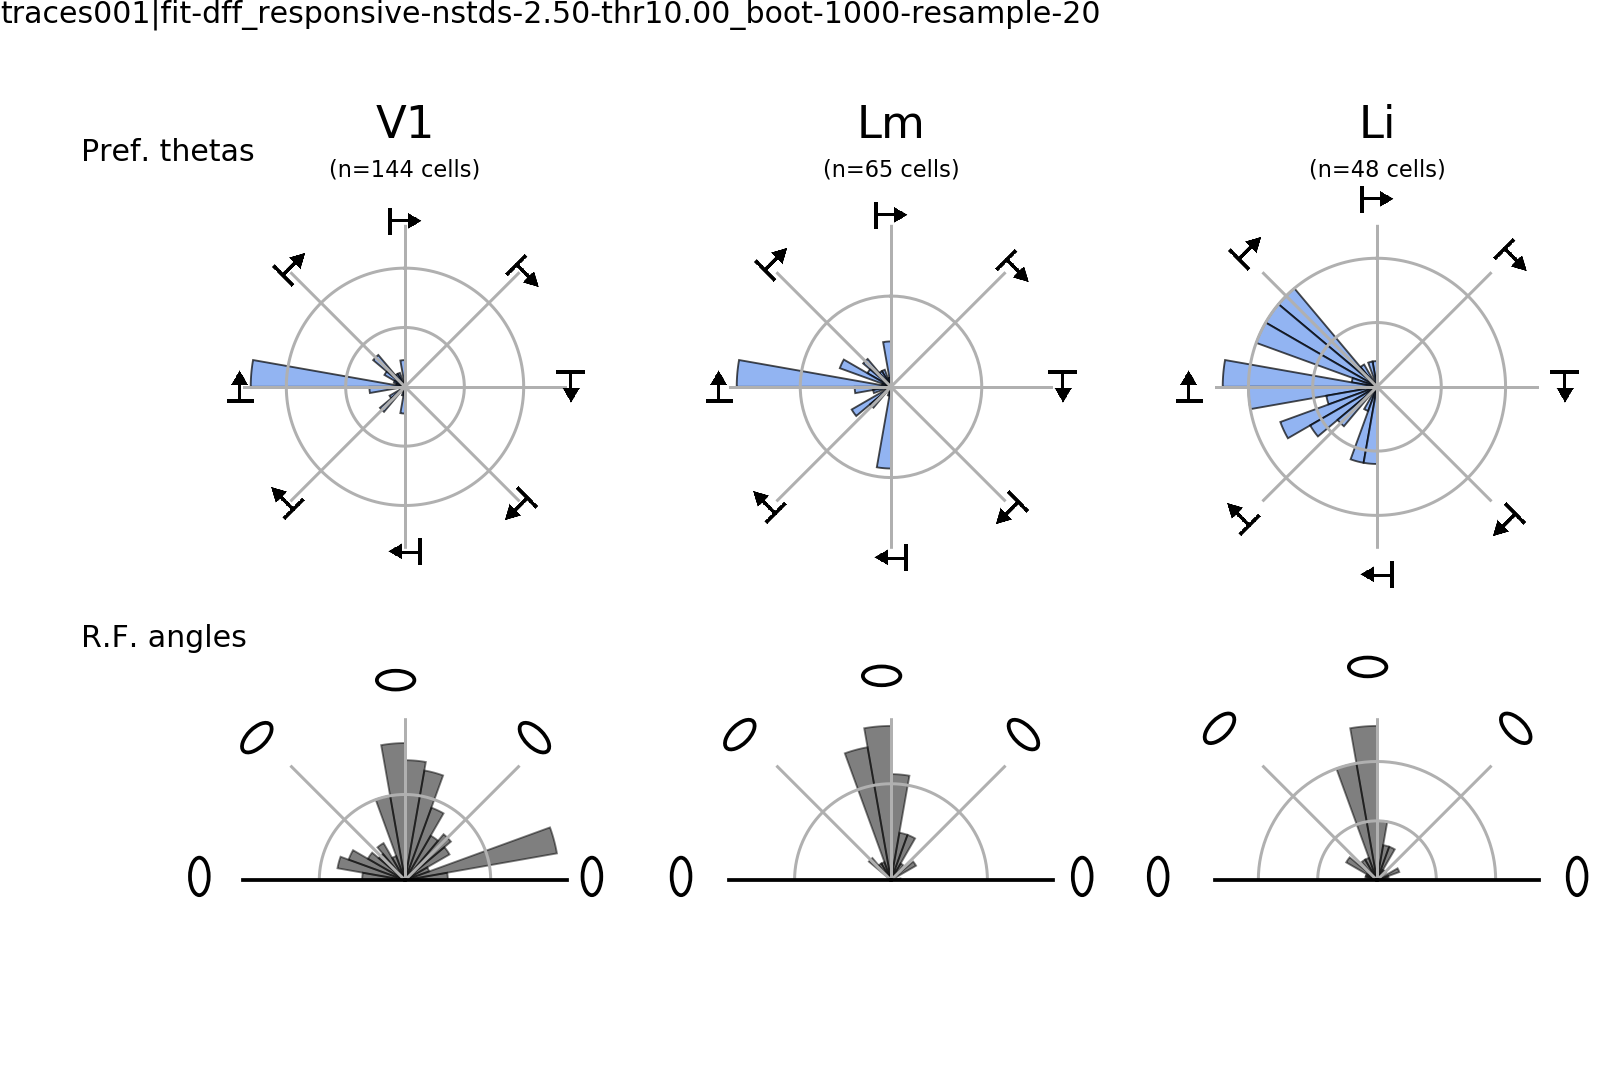

('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'polar_distns_prefthetas_RFangles__r2comb-0.50')


In [330]:
rf_color='k'
ori_color='cornflowerblue'
ell_icon_height = 5


bar_width=10.
bin_size = 10

max_ori = 180.
ori_bins = np.arange(0, max_ori+bin_size, bin_size)
rf_bins = np.arange(-90, 90+bin_size, bin_size)

rf_names = np.arange(-90, 90+45, 45)
ori_names = np.arange(0, max_ori+45, 45)

fig = pl.figure(figsize=(6,4), dpi=dpi)

vi=0
visual_area='V1'

i=0
for vi, visual_area in enumerate(visual_areas):

    # First, do PREFERRED THETA
    # --------------------------------------------------------------------
    g = DF[DF['visual_area']==visual_area].copy()

    degrees = g['theta_pref'].values % max_ori #% 180.
    radians = np.rad2deg(degrees)

    bin_counts, bin_vals = np.histogram(degrees, bins=ori_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])

    ax = pl.subplot(2, 3, vi+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
               facecolor=ori_color, alpha=0.7, edgecolor="none", color=ori_color, linewidth=0.5)
    
    ax.set_title('%s' % (visual_area), loc='center', fontsize=12, y=1.2)
    ax.text(ax.get_xlim()[0], ax.get_ylim()[-1]*1.3, 
            '(n=%i cells)' % g.shape[0], fontsize=6, horizontalalignment='center')
    # Set ticks
    # ---------------------------------------------------------------------
    ax.set_theta_zero_location("N")
    ax.set_rlabel_position(45)
    ori_names = np.arange(0, 360, 45) #np.rad2deg(xticks)
    replace_ori_labels(ori_names, ax=ax, xybox=(0, 0), yloc=ax.get_ylim()[-1]+1, zoom=0.12, polar=True)
    ax.set_yticklabels([])

    # Now, do RECEPTIVE FIELD angles
    # ---------------------------------------------------------------------
    degrees = np.rad2deg(g['theta_Mm_c'].values) #. #- 90.
    bin_counts, bin_vals = np.histogram(degrees, bins=rf_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    
    ax = pl.subplot(2, 3, vi+3+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
           color=rf_color, alpha=0.5, edgecolor=rf_color, lw=0.5)
    ax.set_theta_zero_location("N")
    
    # Set ticks
    # ---------------------------------------------------------------------
    ax.set_xlim([-np.pi/2., np.pi/2.])
    ax.set_xticks(np.arange(-np.pi/2., np.pi/2. + (np.pi/4.), np.pi/4.))
    ax.set_yticklabels([])
    yloc = ax.get_ylim()[-1] + 4
    
    replace_rf_labels(rf_names, ax=ax, width=ell_icon_height*2., height=ell_icon_height, color='k', 
                      yloc=yloc, lw=1, box_alignment=(1, 1), xybox=(-ell_icon_height/2., 1))

    i+=2

putils.label_figure(fig, data_id)
pl.subplots_adjust(left=0.15, wspace=0.5, hspace=0.2, top=0.8, right=0.95, bottom=0.1)

fig.text(0.05, 0.85, "Pref. thetas", horizontalalignment='left', fontsize=8)
fig.text(0.05, 0.4, "R.F. angles", horizontalalignment='left', fontsize=8)

figname = 'polar_distns_prefthetas_RFangles__%s' % thr_str
#pl.savefig(os.path.join(dstdir, '%s.svg' % figname))

print(dstdir, figname)


In [108]:
for i in np.arange(0, 360+45, 45):
    print(i, i%180.)

(0, 0.0)
(45, 45.0)
(90, 90.0)
(135, 135.0)
(180, 0.0)
(225, 45.0)
(270, 90.0)
(315, 135.0)
(360, 0.0)


<IPython.core.display.Javascript object>


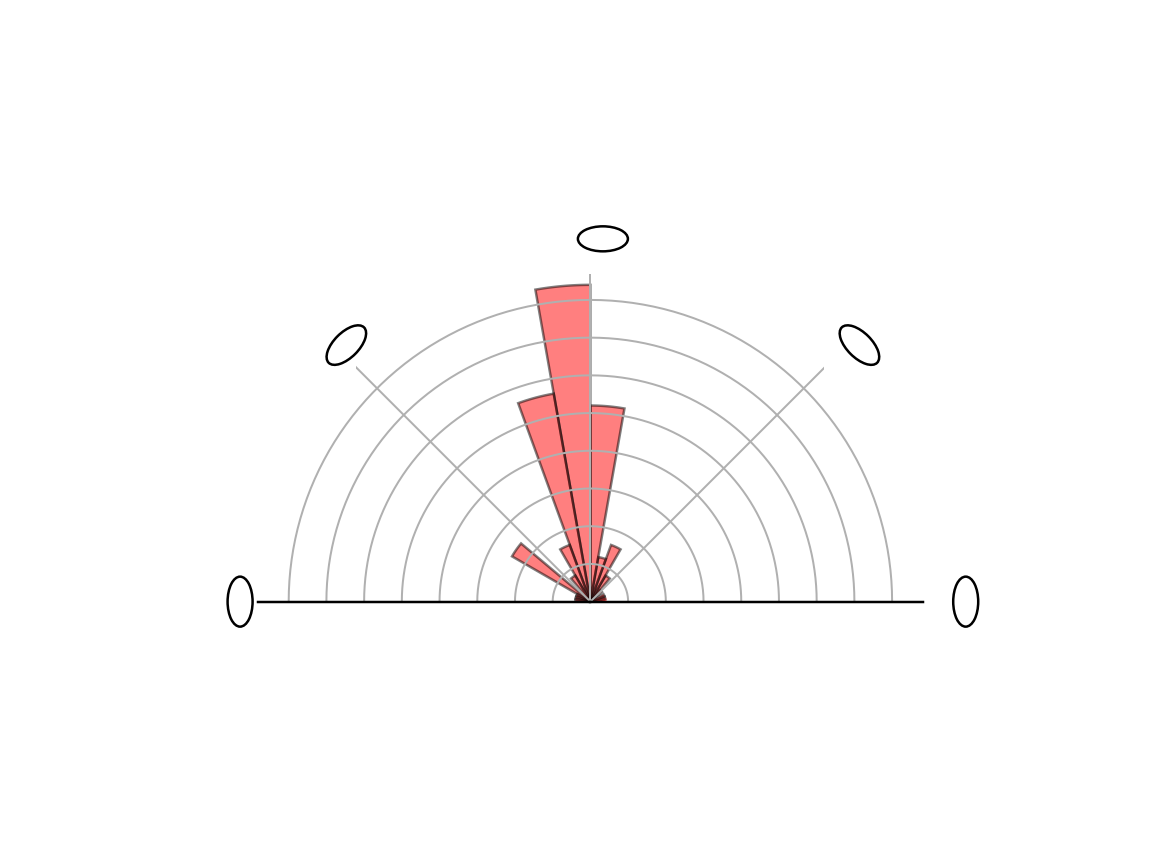

In [437]:

rf_names = np.arange(-90, 90+45, 45)

fig = pl.figure()
ax = pl.subplot(1, 1, 1, projection='polar')
ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, color='r', alpha=0.5, edgecolor='r')
ax.set_theta_zero_location("N")
    
ax.set_xlim([-np.pi/2., np.pi/2.])
ax.set_xticks(np.arange(-np.pi/2., np.pi/2. + (np.pi/4.), np.pi/4.))
ax.set_yticklabels([])
yloc = ax.get_ylim()[-1] + 0

replace_rf_labels(rf_names, ax=ax, width=20, height=10, color='k', yloc=yloc+2)

In [354]:
rf_bins

array([-90, -75, -60, -45, -30, -15,   0,  15,  30,  45,  60,  75,  90])

<IPython.core.display.Javascript object>


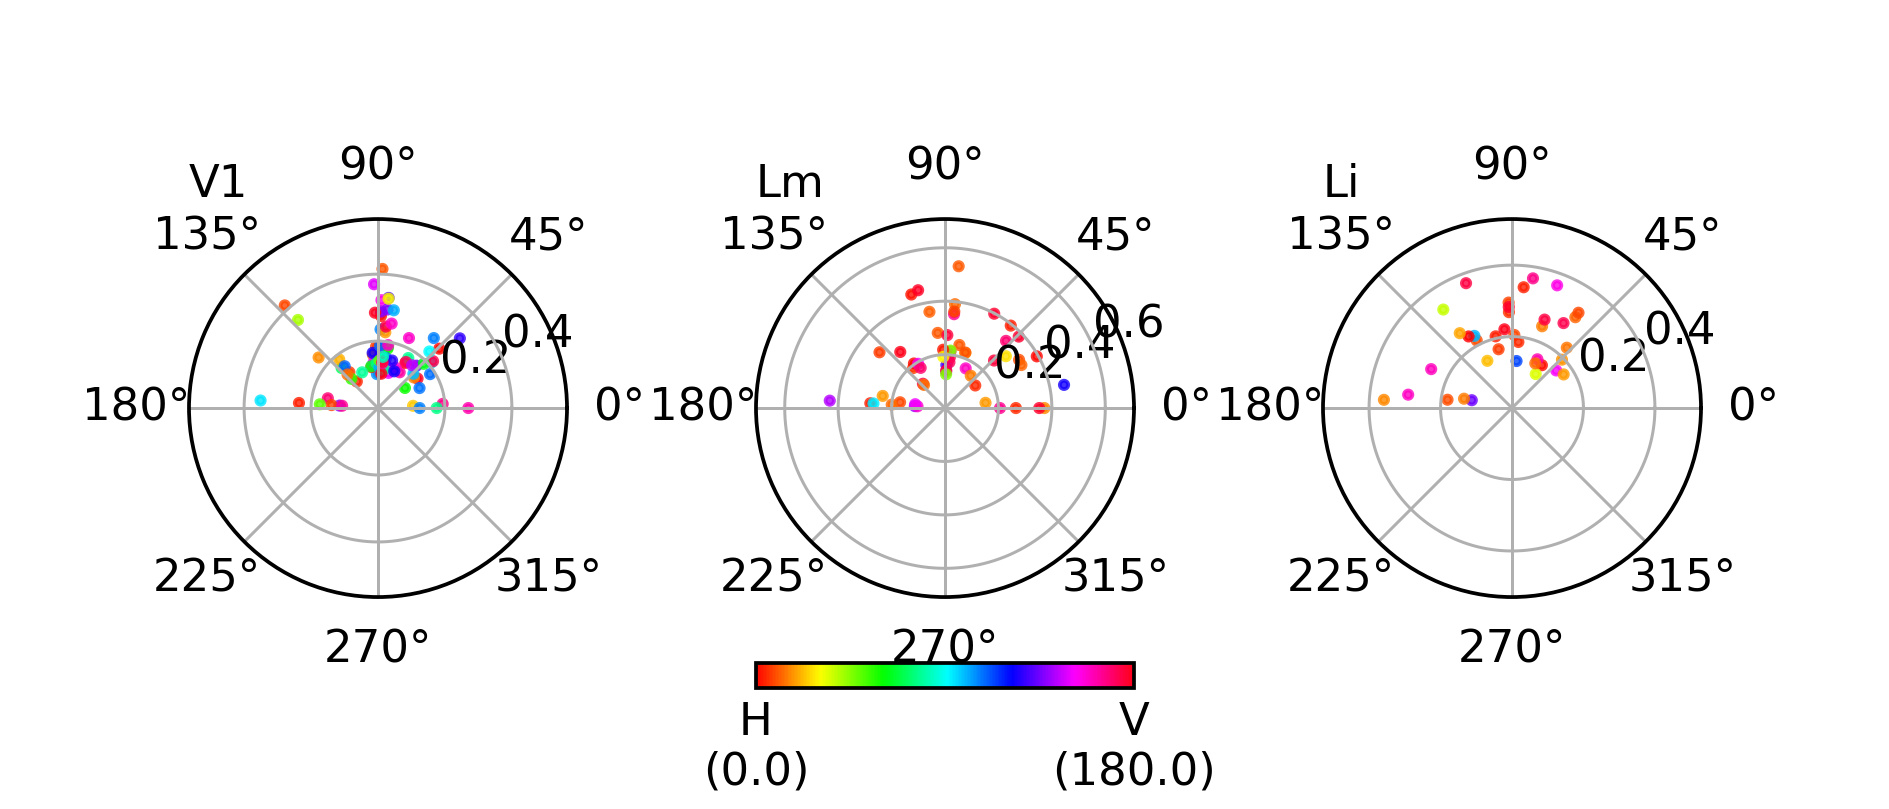

V1:: 93 cells
Lm:: 57 cells
Li:: 38 cells


In [331]:
import matplotlib as mpl
import matplotlib.cm as cm

vmin=0
vmax=180

cmap_name = cm.hsv
aniso_thr=0.1

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.ScalarMappable(norm=norm, cmap=cmap_name)

#if ax is None:
fig, axn = pl.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(7,3), dpi=dpi)

for ax, visual_area in zip(axn.flat, visual_areas):

    df_ = DF[(DF['visual_area']==visual_area) 
            & (DF['anisotropy']>=aniso_thr)].copy()
    print('%s:: %i cells' % (visual_area, df_.shape[0]))
    
    ori_deg = df_['theta_pref'].values
    pref_oris = np.deg2rad(ori_deg) % np.pi
    
    rf_angles = np.rad2deg(df_['theta_Mm_c'].values) % 180.
    vmin=0
    vmax=180
    
    aniso_levels = df_['anisotropy'].values
    aniso_indices = df_['aniso_index'].values
    

    im = ax.scatter(pref_oris, aniso_levels, s=5, c=rf_angles, cmap=cmap_name, 
                    alpha=0.8, vmin=vmin, vmax=vmax)
    ax.set_title(visual_area, loc='left', fontsize=12)


pl.subplots_adjust(wspace=0.5, left=0.1, right=0.9)

# Colorbar
cmap._A = []
cbar_ax = ax.figure.add_axes([0.4, 0.15, 0.2, 0.03])
cbar = ax.figure.colorbar(cmap, cax=cbar_ax, orientation='horizontal', ticks=[vmin, vmax])
xlabel_min = 'H\n(%.1f)' % (vmin) 
xlabel_max= 'V\n(%.1f)' % (vmax) 
cbar.ax.set_xticklabels([xlabel_min, xlabel_max])  # horizontal colorbar
cbar.ax.tick_params(which='both', size=0)


45
135


<IPython.core.display.Javascript object>


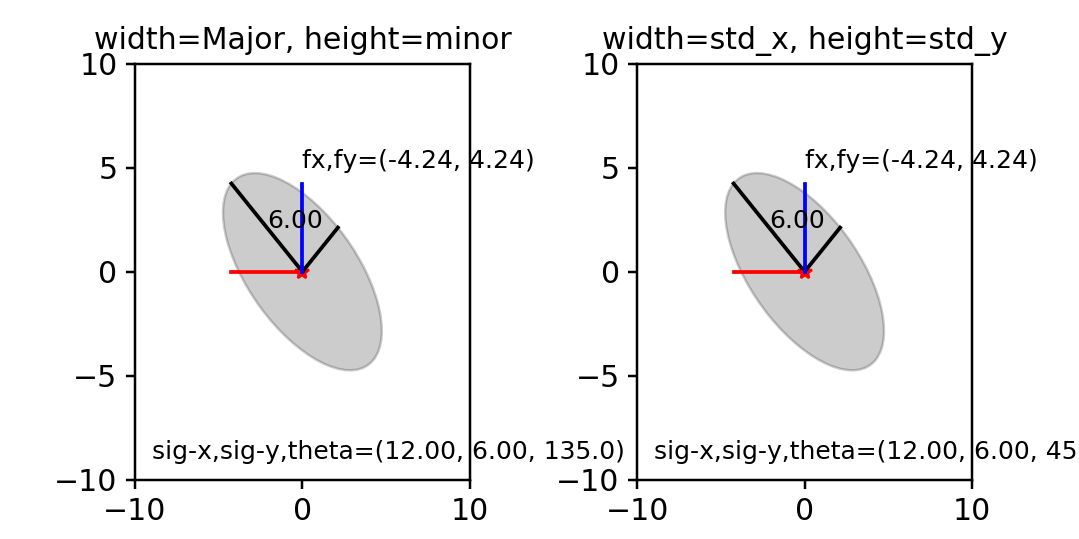

In [93]:
std_x = 6 #12
std_y = 12 #12 #4
theta = 45 #-45 #357.7 #np.rad2deg(6.243)
print(theta)


if std_x < std_y:
    if (90 <= theta < 360):
        angle = (theta + 90) % 360     
    else:
        angle = (((theta) % 90) + 90) % 360
else:
    angle = theta
    
print(angle)
M = max([std_x, std_y])
m = min([std_x, std_y])

x0, y0 = (0, 0)
fig, axn = pl.subplots(1, 2, figsize=(6,3)) #pl.figure()


ax=axn[0]
ax.plot(x0, y0, 'r*')
el = Ellipse((x0, y0), width=M, height=m, angle=angle, alpha=0.2, color='k')
ax.add_artist(el)
ax.set_xlim([-10, 10]); ax.set_ylim([-10, 10]);

F = M/2.
xe = F * np.cos(np.deg2rad(angle))
ye = F * np.sin(np.deg2rad(angle))
ax.plot([x0, xe], [y0, ye], 'k')
ax.text(xe/2., ye/2., '%.2f' % F)

xe2 = (m/2.) * np.sin(np.deg2rad(180-angle))
ye2 = (m/2.) * np.cos(np.deg2rad(180-angle))
ax.plot([x0, xe2], [y0, ye2], 'k')

fx = round(F * np.cos(np.deg2rad(angle)), 2)
fy = round(F * np.sin(np.deg2rad(angle)), 2)

ax.text(0, 5, 'fx,fy=(%.2f, %.2f)' % (fx, fy))
ax.text(-9, -9, 'sig-x,sig-y,theta=(%.2f, %.2f, %.1f)' % (M, m, angle))
ax.plot([x0, fx], [y0, y0], 'r')
ax.plot([x0, x0], [y0, fy], 'b')
ax.set_title('width=Major, height=minor')


ax=axn[1]
ax.plot(x0, y0, 'r*')
el = Ellipse((x0, y0), width=std_x, height=std_y, angle=theta, alpha=0.2, color='k')
ax.add_artist(el)
ax.set_xlim([-10, 10]); ax.set_ylim([-10, 10]);

F = M/2.
xe = F * np.cos(np.deg2rad(theta)) if std_x>std_y else -F * np.sin(np.deg2rad(theta))
ye = F * np.sin(np.deg2rad(theta)) if std_x>std_y else F * np.cos(np.deg2rad(theta))
ax.plot([x0, xe], [y0, ye], 'k')
ax.text(xe/2., ye/2., '%.2f' % F)

xe2 = (m/2.) * np.sin(np.deg2rad(theta)) if std_x>std_y else -(m/2.) * np.cos(np.deg2rad(180-theta))
ye2 = (m/2.) * np.cos(np.deg2rad(theta)) if std_x>std_y else (m/2.) * np.sin(np.deg2rad(180-theta))
ax.plot([x0, xe2], [y0, ye2], 'k')



fx = round(xe, 2)
fy = round(ye, 2)

ax.text(0, 5, 'fx,fy=(%.2f, %.2f)' % (fx, fy))
ax.text(-9, -9, 'sig-x,sig-y,theta=(%.2f, %.2f, %.1f)' % (M, m, theta))
ax.plot([x0, fx], [y0, y0], 'r')
ax.plot([x0, x0], [y0, fy], 'b')

ax.set_title('width=std_x, height=std_y')

pl.subplots_adjust(wspace=0.5)

In [92]:
DF['theta_Mm_deg'].min(), DF['theta_Mm_deg'].max()

(0.41846190365523084, 359.9034703641562)

<IPython.core.display.Javascript object>


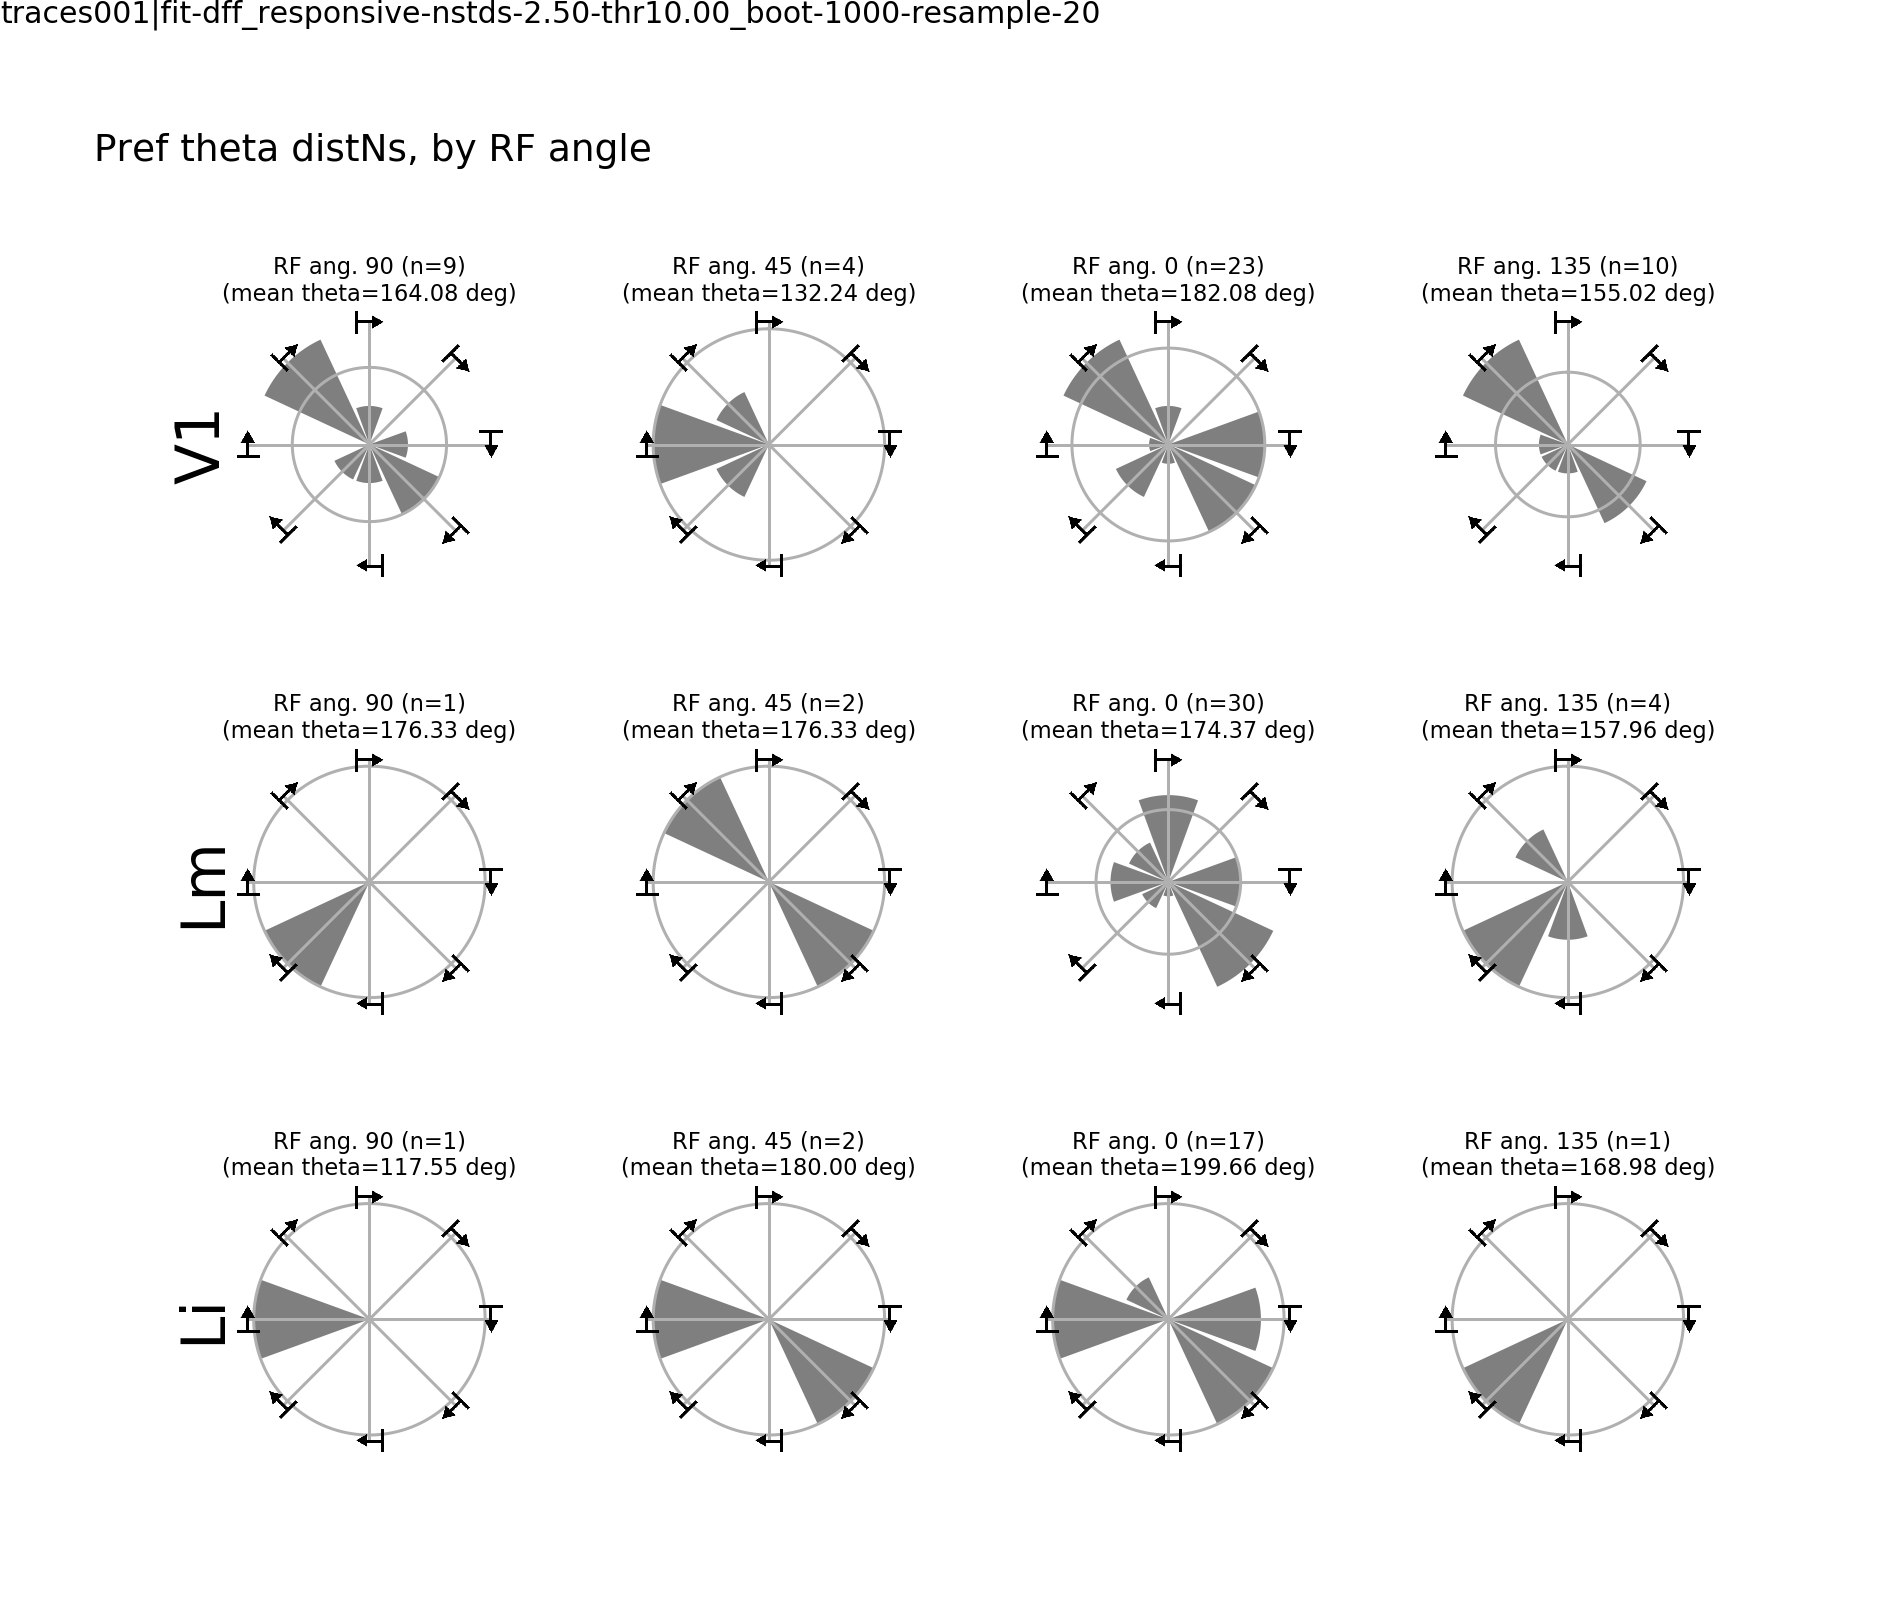

(-2.436337159926778, 3.077478517802247)
(1.5387392589011235, 3.077478517802247)
(-2.436337159926778, 3.077478517802247)
(-2.436337159926778, 3.077478517802247)
(3.077478517802247, 3.077478517802247)
(-1.6669675304762168, 1.5387392589011235)
(-2.5645654315018724, 3.077478517802247)
(-2.949250246227153, 3.077478517802247)
(2.0516523452014974, 2.0516523452014974)
(-2.1798806167765914, 2.1798806167765914)
(-2.1798806167765914, 2.0516523452014974)
(2.949250246227153, 2.949250246227153)
('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'RFangle_vs_preferredtheta_all_polarplots')


In [332]:

max_ori = 360.
ori_names = np.arange(0, max_ori+45, 45)

rf_bin_size = 45
rf_boundary_value = 90 #np.pi/2.
rf_bins = np.arange(-rf_boundary_value, rf_boundary_value + rf_bin_size, rf_bin_size) #% 180.
rf_bin_span=45/2.

rf_theta_param = 'theta_deg'

##### 
bar_width=40#5
bin_size = 10

ori_bin_span=22.5 #22.5 #22.5 #22.5
aniso_thr=0.1
filter_aniso=True

ori_bins = np.arange(-180, 180+45, 45)

# ---------------------------------

label_unit='degrees'

#if ax is None:
fig, axn = pl.subplots(3, len(rf_bins)-1, subplot_kw=dict(projection='polar'), figsize=(7,6), dpi=dpi)

for vi, visual_area in enumerate(visual_areas):
    df_ = DF[(DF['visual_area']==visual_area)].copy()
    
    if filter_aniso:
        df_ = df_[df_['anisotropy']>=aniso_thr] #.copy()
        
    for i, currbin in enumerate(rf_bins[::-1][0:-1]): #rf_bins[0:-1]):

        ax = axn[vi, i]
        if i==0:
            ax.set_ylabel(visual_area)


        ax.set_theta_zero_location("N")
        # Get all cells with RF angle CURRBIN
        # ---------------------------------------------------------------------
        curr_vs = split_by_angle(df_, currbin, metric=rf_theta_param, boundary_value=rf_boundary_value, 
                                 bin_size=rf_bin_span, combine_zero=True)
        if curr_vs.shape[0]==0:
            continue   
        ncells = curr_vs.shape[0]

    
        # Calculate distn of prefered OSI 
        # ---------------------------------------------------------------------
        pref_theta_deg = curr_vs['theta_pref'].values % max_ori
        bin_counts, bin_vals = get_angle_counts(pref_theta_deg, bin_size=ori_bin_span, 
                                                ori_bins=ori_bins, combine_zero=True)
        centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])

        # Plot polar distN
        # ---------------------------------------------------------------------

        bin_counts, bin_edges = np.histogram(pref_theta_deg, bins=ori_names)
        bin_centers = np.ediff1d(bin_edges)//2 + bin_edges[:-1]
        bars = ax.bar(np.deg2rad(bin_edges[0:-1]), bin_counts, width=np.deg2rad(bar_width), color='k', alpha=0.5)

    #     use_center=False # should be false if bin_span is not half of bin diff
    #     th_vals = centers if use_center else np.deg2rad(bin_vals) #[::-1]
    #     r_vals = bin_counts[0:-1] if use_center else bin_counts
    #     bars = ax.bar(th_vals, r_vals, zorder=1, align='center' if not use_center else 'edge', 
    #                   width=-np.deg2rad(bar_width), #np.deg2rad(np.diff(bin_vals)),
    #                      edgecolor='k', fill=True, linewidth=.5, alpha=0.5)
        # Plot outline
        #ax.plot(np.deg2rad(bin_edges[0:-1]), bin_counts)
        #ax.fill(np.deg2rad(bin_edges[0:-1]), bin_counts, 'b', alpha=0.1)

        # Set ticks
        # ---------------------------------------------------------------------
        ax.set_theta_zero_location("N")
        ori_names = np.arange(0, 360, 45) #np.rad2deg(xticks)
        replace_ori_labels(ori_names, ax=ax, xybox=(0, 0), yloc=None, zoom=0.1, polar=True)
        ax.set_yticklabels([])

        # Calculate average ORI
        # ---------------------------------------------------------------------
        oris = np.deg2rad(wrap_values(pref_theta_deg, degrees=True))
        print(oris.min(), oris.max())
        mean_theta = np.mean(np.deg2rad(pref_theta_deg))
#         ax.arrow(0, 0, mean_theta, np.max(bin_counts), width=.05, 
#                  head_starts_at_zero=True, length_includes_head=True, edgecolor='r',
#                 head_width=0.) # 'k*', lw=2, linestyle='-')

        ax.set_title('RF ang. %i (n=%i)\n(mean theta=%.2f deg)' \
                     % (currbin%180., ncells, np.rad2deg(mean_theta)), loc='center',y=1,  fontsize=6, ) #, pad=50)
        
    pl.subplots_adjust(wspace=0.5, hspace=0.8, top=0.8)
    
    
    

fig.text(0.05, 0.9, "Pref theta distNs, by RF angle")
putils.label_figure(fig, data_id)
    
figname = 'RFangle_vs_preferredtheta_all_polarplots'
#pl.savefig(os.path.join(dstdir, '%s.svg' % figname))

print(dstdir, figname)

## circular stats?

In [333]:
from numpy.fft import fft, ifft

def periodic_corr(x, y):
    """Periodic correlation, implemented using the FFT.

    x and y must be real sequences with the same length.
    """
    return ifft(fft(x) * fft(y).conj()).real

def periodic_corr_np(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return np.correlate(x, np.hstack((y[1:], y)), mode='valid')


# ------------------------------------
# circular stats
# https://gist.github.com/kn1cht/89dc4f877a90ab3de4ddef84ad91124e

import cmath
import numpy as np
import scipy.stats as stats

def circ_mean(angles, deg=True):
    '''Circular mean of angle data(default to degree)
    '''
    a = np.deg2rad(angles) if deg else np.array(angles)
    angles_complex = np.frompyfunc(cmath.exp, 1, 1)(a * 1j)
    mean = cmath.phase(angles_complex.sum()) % (2 * np.pi)
    return round(np.rad2deg(mean) if deg else mean, 7)

def circ_var(angles, deg=True):
    '''Circular variance of angle data(default to degree)
    0 <= var <= 1
    '''
    a = np.deg2rad(angles) if deg else np.array(angles)
    angles_complex = np.frompyfunc(cmath.exp, 1, 1)(a * 1j)
    r =abs(angles_complex.sum()) / len(angles)
    return round(1 - r, 7)

def circ_std(angles, deg=True):
    '''Circular standard deviation of angle data(default to degree)
    0 <= std
    '''
    a = np.deg2rad(angles) if deg else np.array(angles)
    angles_complex = np.frompyfunc(cmath.exp, 1, 1)(a * 1j)
    r = abs(angles_complex.sum()) / len(angles)
    std = np.sqrt(-2 * np.log(r))
    return round(np.rad2deg(std) if deg else std, 7)


def circ_corrcoef(x, y, deg=True, test=False):
    '''Circular correlation coefficient of two angle data(default to degree)
    Set `test=True` to perform a significance test.
    '''
    convert = np.pi / 180.0 if deg else 1
    sx = np.frompyfunc(np.sin, 1, 1)((x - circ_mean(x, deg)) * convert)
    sy = np.frompyfunc(np.sin, 1, 1)((y - circ_mean(y, deg)) * convert)
    r = (sx * sy).sum() / np.sqrt((sx ** 2).sum() * (sy ** 2).sum())

    if test:
        l20, l02, l22 = (sx ** 2).sum(),(sy ** 2).sum(), ((sx ** 2) * (sy ** 2)).sum()
        test_stat = r * np.sqrt(l20 * l02 / l22)
        p_value = 2 * (1 - stats.norm.cdf(abs(test_stat)))
        return tuple(round(v, 7) for v in (r, test_stat, p_value))
    return round(r, 7)

# ------------------------------------
# from astropy
# https://docs.astropy.org/en/stable/_modules/astropy/stats/circstats.html#circcorrcoef
# ------------------------------------
def circcorrcoef(alpha, beta, axis=None, weights_alpha=None,
                 weights_beta=None):
    """ Computes the circular correlation coefficient between two array of
    circular data.

    Parameters
    ----------
    alpha : numpy.ndarray or Quantity
        Array of circular (directional) data, which is assumed to be in
        radians whenever ``data`` is ``numpy.ndarray``.
    beta : numpy.ndarray or Quantity
        Array of circular (directional) data, which is assumed to be in
        radians whenever ``data`` is ``numpy.ndarray``.
    axis : int, optional
        Axis along which circular correlation coefficients are computed.
        The default is the compute the circular correlation coefficient of the
        flattened array.
    weights_alpha : numpy.ndarray, optional
        In case of grouped data, the i-th element of ``weights_alpha``
        represents a weighting factor for each group such that
        ``sum(weights_alpha, axis)`` equals the number of observations.
        See [1]_, remark 1.4, page 22, for detailed explanation.
    weights_beta : numpy.ndarray, optional
        See description of ``weights_alpha``.

    Returns
    -------
    rho : numpy.ndarray or dimensionless Quantity
        Circular correlation coefficient.

    Examples
    --------
    >>> import numpy as np
    >>> from astropy.stats import circcorrcoef
    >>> from astropy import units as u
    >>> alpha = np.array([356, 97, 211, 232, 343, 292, 157, 302, 335, 302,
    ...                   324, 85, 324, 340, 157, 238, 254, 146, 232, 122,
    ...                   329])*u.deg
    >>> beta = np.array([119, 162, 221, 259, 270, 29, 97, 292, 40, 313, 94,
    ...                  45, 47, 108, 221, 270, 119, 248, 270, 45, 23])*u.deg
    >>> circcorrcoef(alpha, beta) # doctest: +FLOAT_CMP
    <Quantity 0.2704648826748831>

    References
    ----------
    .. [1] S. R. Jammalamadaka, A. SenGupta. "Topics in Circular Statistics".
       Series on Multivariate Analysis, Vol. 5, 2001.
    .. [2] C. Agostinelli, U. Lund. "Circular Statistics from 'Topics in
       Circular Statistics (2001)'". 2015.
       <https://cran.r-project.org/web/packages/CircStats/CircStats.pdf>
    """
    if(np.size(alpha, axis) != np.size(beta, axis)):
        raise ValueError("alpha and beta must be arrays of the same size")

    mu_a = circmean(alpha, axis, weights_alpha)
    mu_b = circmean(beta, axis, weights_beta)

    sin_a = np.sin(alpha - mu_a)
    sin_b = np.sin(beta - mu_b)
    rho = np.sum(sin_a*sin_b)/np.sqrt(np.sum(sin_a*sin_a)*np.sum(sin_b*sin_b))

    return rho

def circmean(data, axis=None, weights=None):
    """ Computes the circular mean angle of an array of circular data.

    Parameters
    ----------
    data : numpy.ndarray or Quantity
        Array of circular (directional) data, which is assumed to be in
        radians whenever ``data`` is ``numpy.ndarray``.
    axis : int, optional
        Axis along which circular means are computed. The default is to compute
        the mean of the flattened array.
    weights : numpy.ndarray, optional
        In case of grouped data, the i-th element of ``weights`` represents a
        weighting factor for each group such that ``sum(weights, axis)``
        equals the number of observations. See [1]_, remark 1.4, page 22, for
        detailed explanation.

    Returns
    -------
    circmean : numpy.ndarray or Quantity
        Circular mean.

    Examples
    --------
    >>> import numpy as np
    >>> from astropy.stats import circmean
    >>> from astropy import units as u
    >>> data = np.array([51, 67, 40, 109, 31, 358])*u.deg
    >>> circmean(data) # doctest: +FLOAT_CMP
    <Quantity 48.62718088722989 deg>

    References
    ----------
    .. [1] S. R. Jammalamadaka, A. SenGupta. "Topics in Circular Statistics".
       Series on Multivariate Analysis, Vol. 5, 2001.
    .. [2] C. Agostinelli, U. Lund. "Circular Statistics from 'Topics in
       Circular Statistics (2001)'". 2015.
       <https://cran.r-project.org/web/packages/CircStats/CircStats.pdf>
    """
    return _angle(data, 1, 0.0, axis, weights)

def _components(data, p=1, phi=0.0, axis=None, weights=None):
    # Utility function for computing the generalized rectangular components
    # of the circular data.
    if weights is None:
        weights = np.ones((1,))
    try:
        weights = np.broadcast_to(weights, data.shape)
    except ValueError:
        raise ValueError('Weights and data have inconsistent shape.')

    C = np.sum(weights * np.cos(p * (data - phi)), axis)/np.sum(weights, axis)
    S = np.sum(weights * np.sin(p * (data - phi)), axis)/np.sum(weights, axis)

    return C, S

def _angle(data, p=1, phi=0.0, axis=None, weights=None):
    # Utility function for computing the generalized sample mean angle
    C, S = _components(data, p, phi, axis, weights)

    # theta will be an angle in the interval [-np.pi, np.pi)
    # [-180, 180)*u.deg in case data is a Quantity
    theta = np.arctan2(S, C)

    #if isinstance(data, Quantity):
    #    theta = theta.to(data.unit)

    return theta


<IPython.core.display.Javascript object>


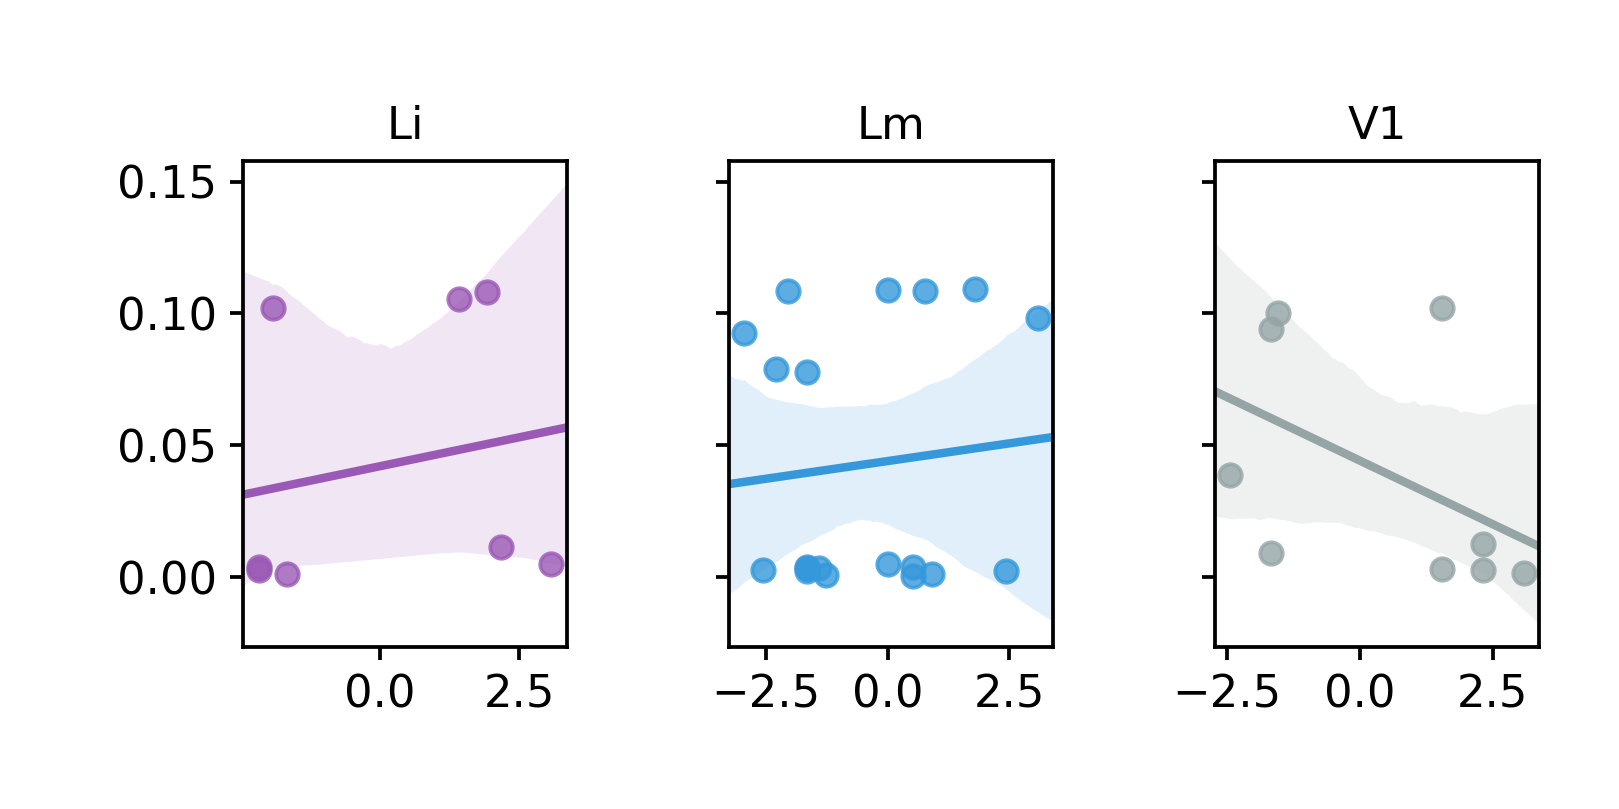

Li, , -0.3976, 0.1581
Lm, , -0.2198, 0.0483
V1, , 0.3385, 0.1146


In [334]:
df_ = DF[DF['visual_area']=='V1'].copy()
df_ = df_[df_['anisotropy']>=aniso_thr] #.copy()

aniso_thr=0.3
fig, axn = pl.subplots(1,3, figsize=(6,3), dpi=dpi, sharey=True)

for vi, (visual_area, df_) in enumerate(DF[DF['anisotropy']>=aniso_thr].groupby(['visual_area'])):
    
    ax=axn[vi]
    #df_ = df_[df_['anisotropy']>=aniso_thr] #.copy()

    #x = np.deg2rad(df_['theta_pref']) #% np.pi
    degs = df_['theta_pref'].values
    angles = (degs + 180.) % (2*180.) - 180.
    x = np.deg2rad(angles)
    
    degs2 = df_['theta'].values #% (np.pi) #np.deg2rad(df_['theta_deg']) # % 180.
    angles2 = (degs2 + 180.) % (2*180.) - 180.
    y = np.deg2rad(angles2)
    
    cc = circcorrcoef(x, y)
    print('%s, , %.4f, %.4f' % (visual_area,cc, cc**2))
    sns.regplot(x, y, ax=ax)
    
    ax.set_title(visual_area)
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.2, top=0.8, wspace=0.5)

<IPython.core.display.Javascript object>


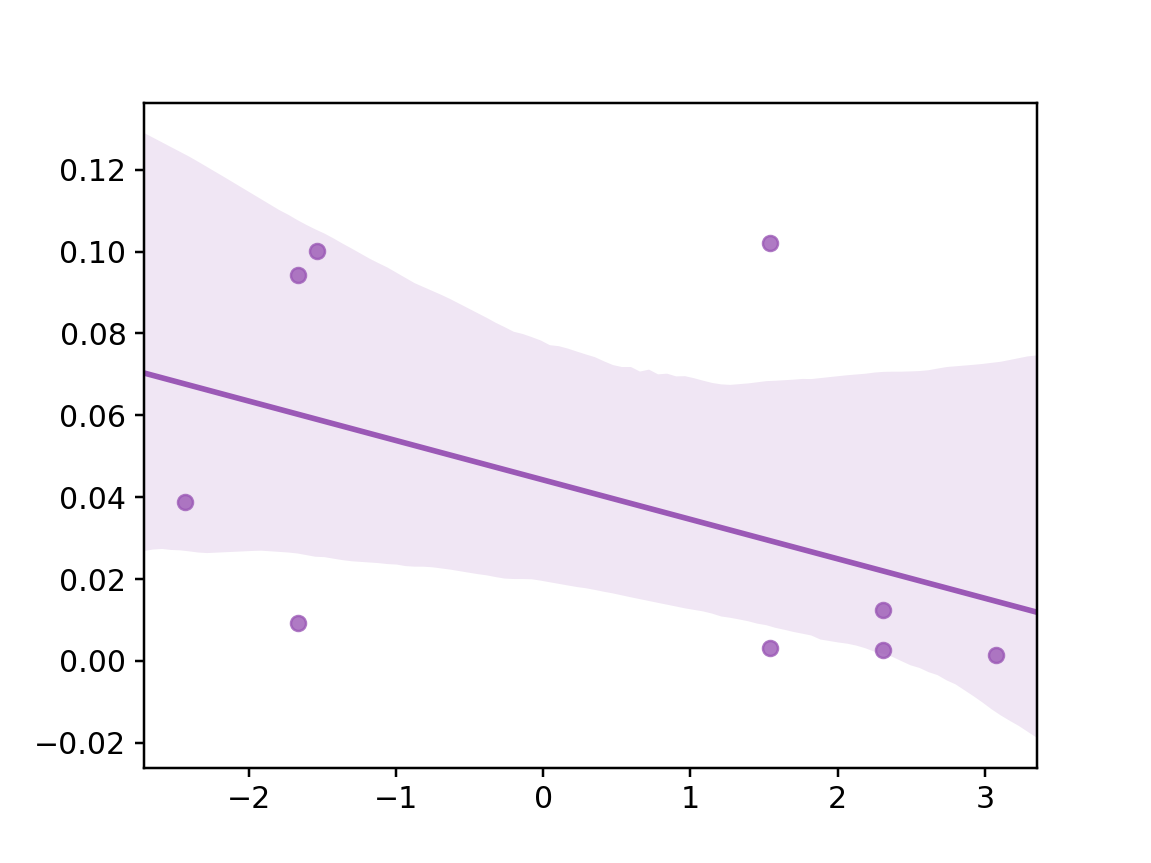

In [335]:
fig, ax = pl.subplots()
#ax.scatter(np.deg2rad(df_['theta_pref']), np.deg2rad(df_['theta_deg']))
sns.regplot(x, y)

In [251]:
xticks

array([  0.,  45.,  90., 135., 180., 225., 270., 315.])

<IPython.core.display.Javascript object>


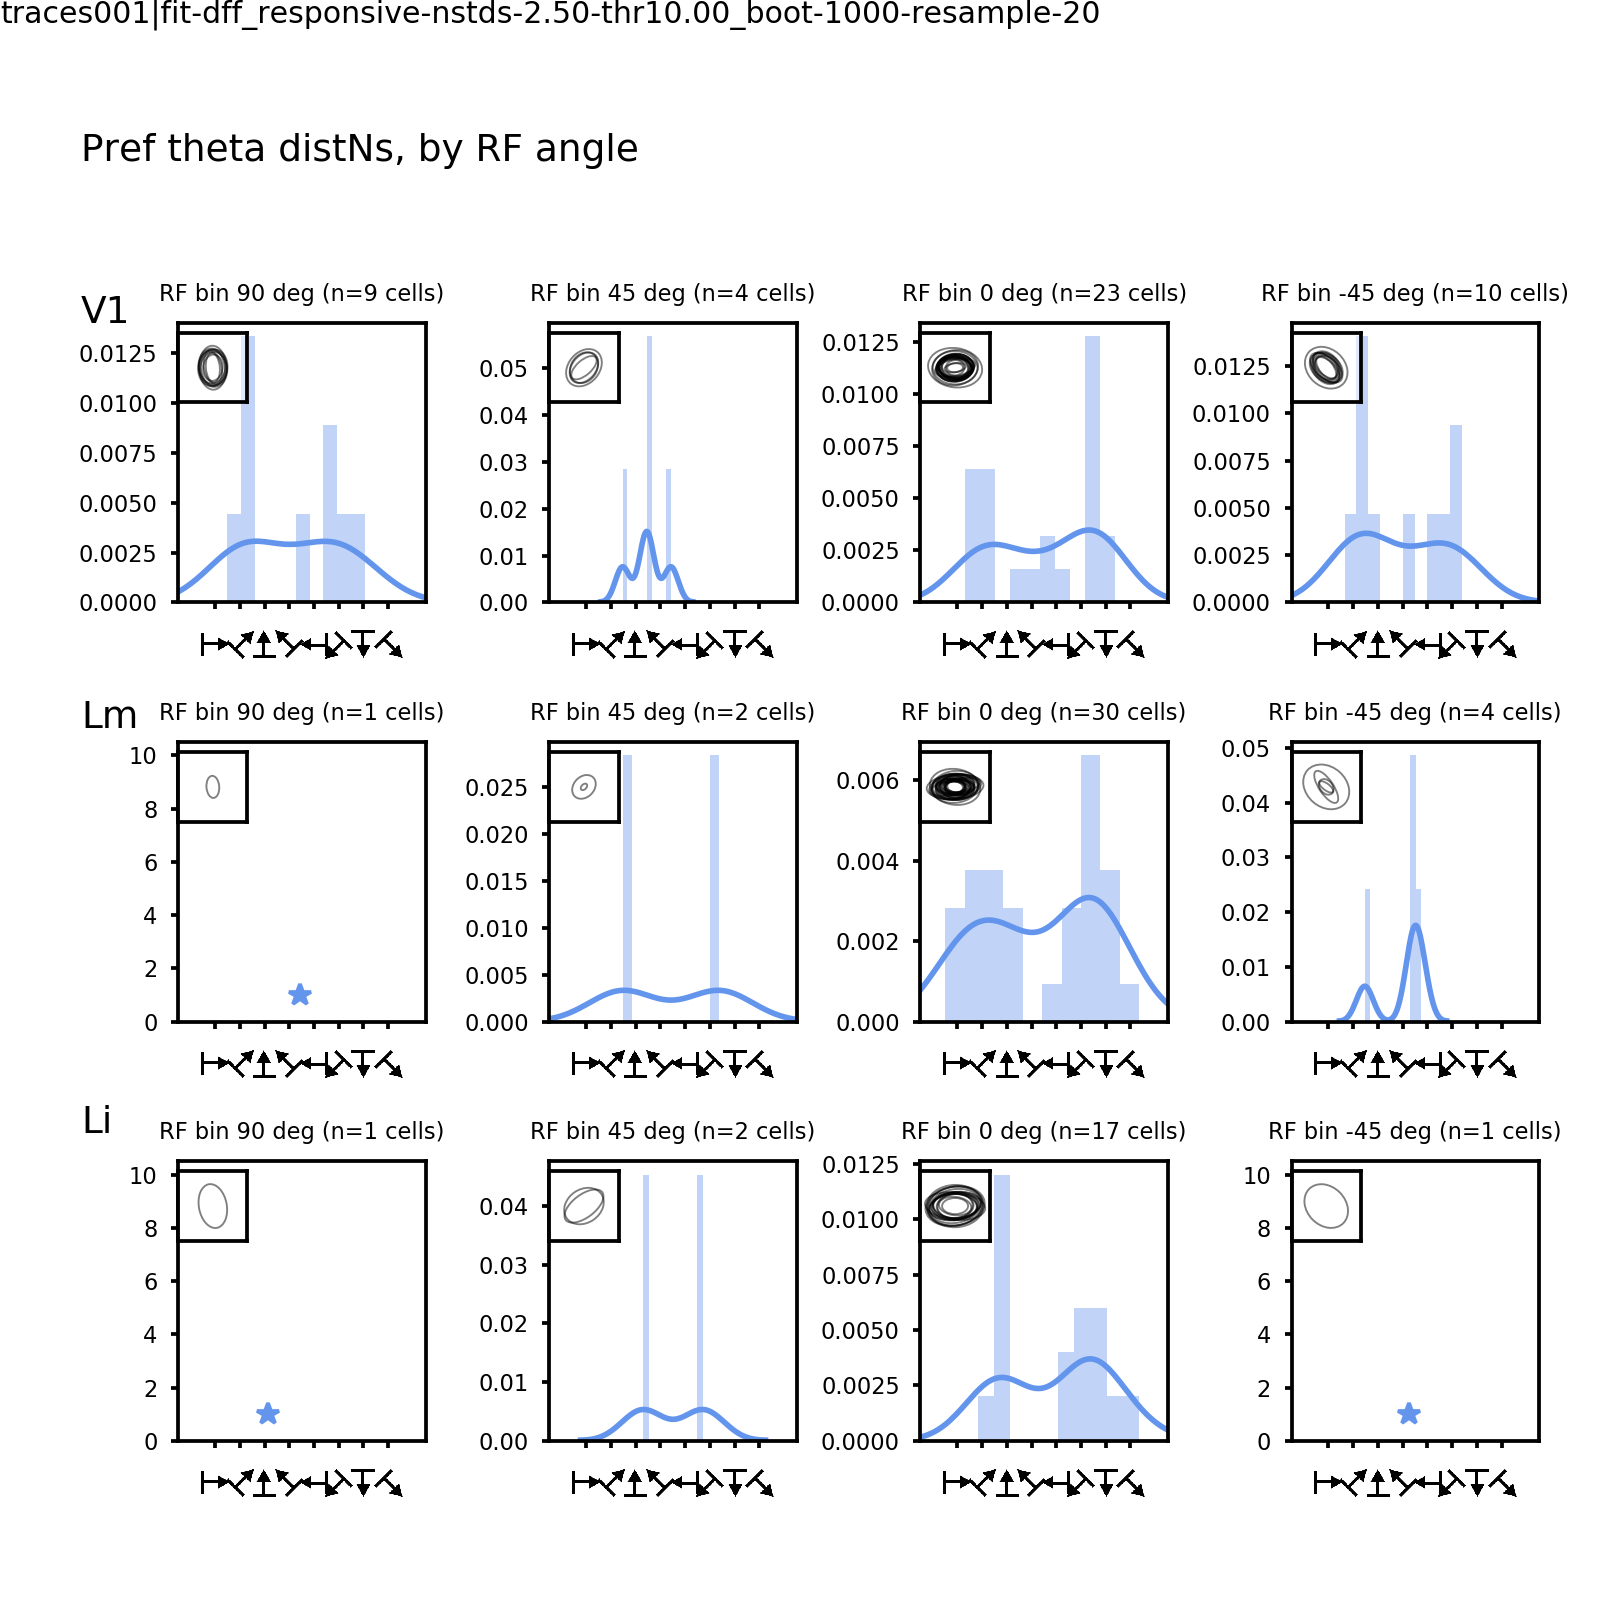

V1:: 144 cells
Lm:: 65 cells
Li:: 48 cells
('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'RFangle_vs_preferredtheta_allcells__aniso-0.10')


In [337]:
rf_color='k'
ori_color='cornflowerblue'

rf_bin_size = 45
rf_boundary_value = 90 #np.pi/2.
rf_bins = np.arange(-rf_boundary_value, rf_boundary_value + rf_bin_size, rf_bin_size) #% 180.
rf_bin_span=22.5 #22.5 #.5 #22.5

rf_theta_param = 'theta_deg'

##### 
bar_width=30
ori_bin_span=22.5 #2.5 #22.5 #22.5

####
aniso_thr=0.1
filter_aniso=True
 
max_ori=360.
mod_val=360.
n_bins_dist = 10 if max_ori==360. else 4

ori_bins = np.arange(-180, 180+45, 45)
ori_names = np.arange(0, max_ori+45, 45)

label_unit='degrees'

# =====================================================
# PLOT
# =====================================================

fig, axn = pl.subplots(3, len(rf_bins)-1, figsize=(6,6), dpi=dpi, sharex=True)
pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8, left=0.11, right=0.95)

offset=0.25
vi=0
visual_area='V1'

for vi, visual_area in enumerate(visual_areas):
    df_ = DF[(DF['visual_area']==visual_area)].copy()
    print('%s:: %i cells' % (visual_area, df_.shape[0]))

    if filter_aniso:
        df_ = df_[df_['anisotropy']>=aniso_thr] #.copy()

    for ci, currbin in enumerate(rf_bins[::-1][0:-1]):   

        # Get all cells with RF angle CURRBIN
        # ---------------------------------------------------------------------
        curr_vs = split_by_angle(df_, currbin, metric=rf_theta_param, boundary_value=rf_boundary_value, 
                                 bin_size=rf_bin_span, combine_zero=True)
        if curr_vs.shape[0]==0:
            continue   
        ncells = curr_vs.shape[0]

        # Calculate distn of prefered OSI 
        # ---------------------------------------------------------------------
        pref_theta_deg = curr_vs['theta_pref'].values % mod_val

        # RF hists of value
        # ---------------------------------------------------------------------
        ax=axn[vi, ci]
        xticks = np.arange(0, mod_val+45, 45)
        if len(pref_theta_deg)==1:
            ax.plot(pref_theta_deg, 1, color=ori_color, marker='*')
        #ax.hist(pref_theta_deg % mod_val, bins=xticks, align='mid', color='gray', alpha=0.5)
        sns.distplot(pref_theta_deg, ax=ax, bins=n_bins_dist, color=ori_color) #$, ax=ax)
        centers = np.ediff1d(xticks)//2 + xticks[:-1]
        ax.set_xticks(centers)
        #ax.set_xticklabels([int(i) for i in xticks], fontsize=4)
        replace_ori_labels(xticks, bin_centers=centers, ax=ax, xybox=(0, -0.1), 
                           yloc=-0.15, zoom=0.1, polar=False)

        ax.tick_params(which='both', axis='both', labelsize=6, size=2)

        # RF shapes
        # ---------------------------------------------------------------------
        rect = [0.0, 0.69, 0.28, 0.3]
        ax1 = add_subplot_axes(ax, rect, axisbg='white', axis_alpha=0.5)

        ax1.set_xlim([-12, 12])
        ax1.set_ylim([-12, 12])
        mean_rf_theta = np.rad2deg(np.mean(abs(curr_vs['theta_Mm_c'].values)))
        for ri in curr_vs.index.tolist():
            rv = curr_vs.loc[ri]
            (sz_x, sz_y, th) = rv[['major_axis', 'minor_axis', 'theta_Mm_c']].values
            #(sz_x, sz_y, th) = rv[['std_x', 'std_y', 'theta']].values
            ell = Ellipse((0, 0), abs(sz_x), abs(sz_y), angle=np.rad2deg(th), edgecolor=rf_color, 
                          facecolor='none', alpha=0.5, lw=0.5)
            ax1.add_patch(ell)
        ax1.set_aspect('equal')
        #ax1.set_title('avg. RF=%.1f deg' % (mean_rf_theta), loc='center', fontsize=6)
        putils.turn_off_axis_ticks(ax1, despine=False)

        ax.set_title('RF bin %i deg (n=%i cells)' % (currbin, ncells), fontsize=6)
    ax.set_xlim([-45, 360+45])
    
    fig.text(0.05, 0.8-(vi*offset), visual_area)

fig.text(0.05, 0.9, "Pref theta distNs, by RF angle")
putils.label_figure(fig, data_id)
    
figname = 'RFangle_vs_preferredtheta_allcells__aniso-%.2f' % aniso_thr
#pl.savefig(os.path.join(dstdir, '%s.svg' % figname))

print(dstdir, figname)

<IPython.core.display.Javascript object>


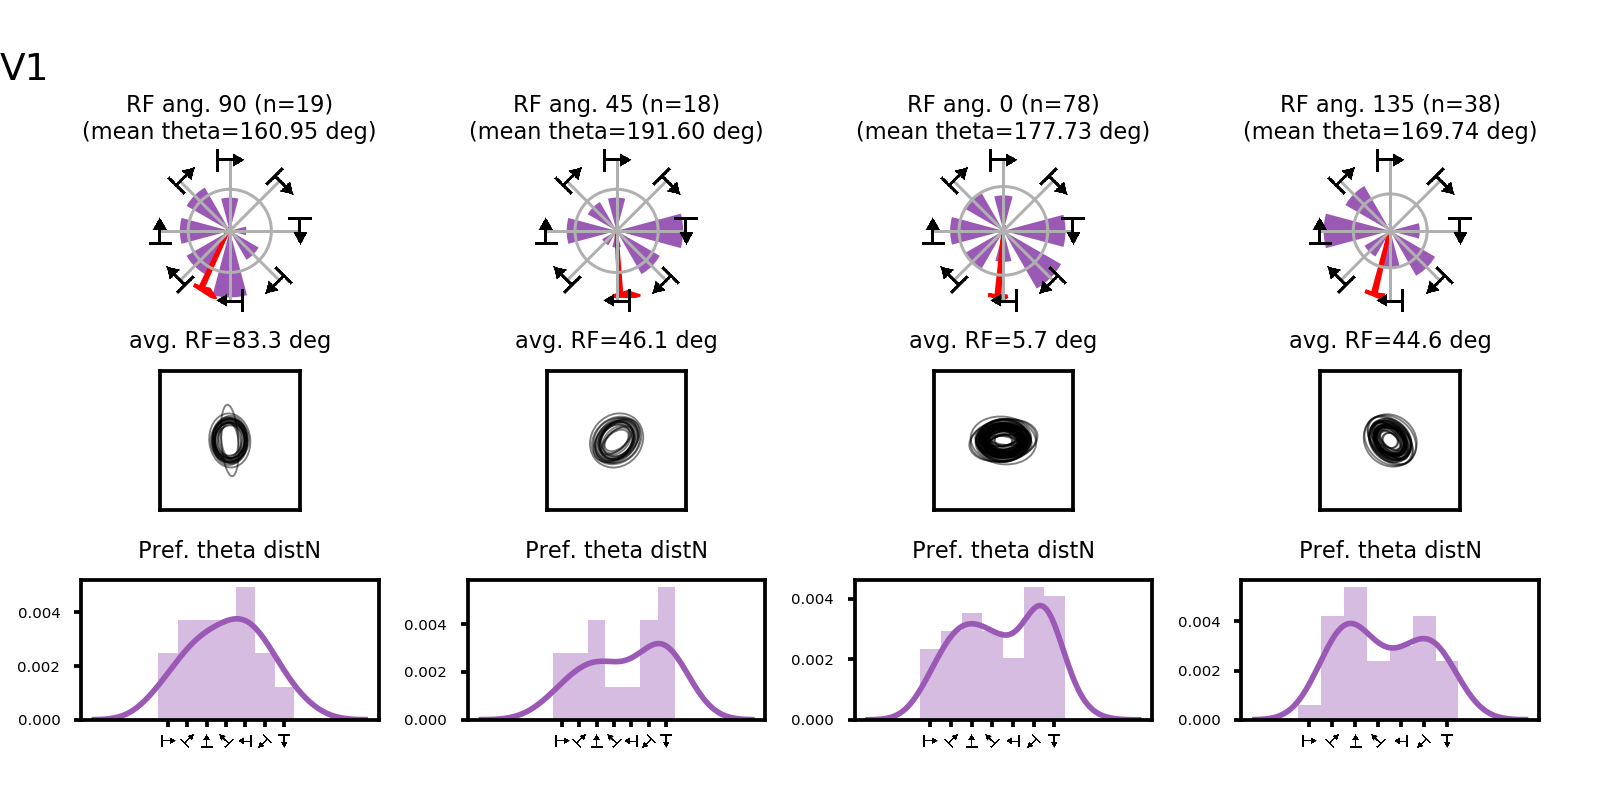

V1:: 344 cells
(-2.8572361709018, 3.0487538114926025)
(-3.084283119367713, 2.605464659398334)
(-3.1045498113940626, 3.134168752868577)
(-2.9955127905377497, 3.0176821756140066)
('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'RFangle_vs_preferredtheta_V1')


In [200]:
rf_bin_size = 45
rf_boundary_value = 90 #np.pi/2.
rf_bins = np.arange(-rf_boundary_value, rf_boundary_value + rf_bin_size, rf_bin_size) #% 180.
rf_bin_span=23 #22.5

rf_theta_param = 'theta_deg'

##### 
bar_width=30
ori_bin_span=22.5 #22.5

####
aniso_thr=0.05
filter_aniso=True
 
mod_val=360.
ori_bins = np.arange(-180, 180+45, 45)

label_unit='degrees'

# =====================================================
# PLOT
# =====================================================

fig = pl.figure(figsize=(6,3), dpi=dpi)

vi=0
visual_area='V1'
nc=len(rf_bins)-1
nr=3

df_ = DF[(DF['visual_area']==visual_area)].copy()
print('%s:: %i cells' % (visual_area, df_.shape[0]))

if filter_aniso:
    df_ = df_[df_['anisotropy']>=aniso_thr] #.copy()

for i, currbin in enumerate(rf_bins[::-1][0:-1]):   
    ax=pl.subplot(nr, nc,i+1, projection='polar') 
    ax.set_theta_zero_location("N")
    
    # Get all cells with RF angle CURRBIN
    # ---------------------------------------------------------------------
    curr_vs = split_by_angle(df_, currbin, metric=rf_theta_param, boundary_value=rf_boundary_value, 
                             bin_size=rf_bin_span, combine_zero=True)
    if curr_vs.shape[0]==0:
        continue   
    ncells = curr_vs.shape[0]
    
    # Calculate distn of prefered OSI 
    # ---------------------------------------------------------------------
    pref_theta_deg = curr_vs['theta_pref'].values % mod_val
    bin_counts, bin_vals = get_angle_counts(pref_theta_deg, bin_size=ori_bin_span, 
                                            ori_bins=ori_bins, combine_zero=True)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])

    # Plot polar distN
    # ---------------------------------------------------------------------
    bin_counts, bin_edges = np.histogram(pref_theta_deg, bins=ori_names)
    bin_centers = np.ediff1d(bin_edges)//2 + bin_edges[:-1]
    bars = ax.bar(np.deg2rad(bin_edges[0:-1]), bin_counts, width=np.deg2rad(bar_width))

#     use_center=False # should be false if bin_span is not half of bin diff
#     th_vals = centers if use_center else np.deg2rad(bin_vals) #[::-1]
#     r_vals = bin_counts[0:-1] if use_center else bin_counts
#     bars = ax.bar(th_vals, r_vals, zorder=1, align='center' if not use_center else 'edge', 
#                   width=-np.deg2rad(bar_width), #np.deg2rad(np.diff(bin_vals)),
#                      edgecolor='k', fill=True, linewidth=.5, alpha=0.5)
    # Plot outline
    #ax.plot(np.deg2rad(bin_vals), bin_counts)
    #ax.fill(np.deg2rad(bin_vals), bin_counts, 'b', alpha=0.1)

    # Set ticks
    # ---------------------------------------------------------------------
    ax.set_theta_zero_location("N")
    ori_names = np.arange(0, 360, 45) #np.rad2deg(xticks)
    #replace_ori_labels(ori_names, ax=ax, yloc=None, zoom=0.1, polar=True)
    replace_ori_labels(ori_names, ax=ax, xybox=(0, 0), yloc=None, zoom=0.1, polar=True)
    ax.set_yticklabels([])
    
    # Calculate average ORI
    # ---------------------------------------------------------------------
    oris = np.deg2rad(wrap_values(pref_theta_deg, degrees=True))
    print(oris.min(), oris.max())
    mean_theta = np.mean(np.deg2rad(pref_theta_deg))
    ax.arrow(0, 0, mean_theta, np.max(bin_counts), width=.05, 
             head_starts_at_zero=True, length_includes_head=True, edgecolor='r',
            head_width=0.3) # 'k*', lw=2, linestyle='-')

    ax.set_title('RF ang. %i (n=%i)\n(mean theta=%.2f deg)' \
                 % (currbin%180., ncells, np.rad2deg(mean_theta)), loc='center',y=1,  fontsize=6, ) #, pad=50)
    
    # RF shapes
    # ---------------------------------------------------------------------
    ax=pl.subplot(nr, nc, i+1+(nc*1)) #axn[0, i]
    ax.set_xlim([-20, 20])
    ax.set_ylim([-20, 20])
    mean_rf_theta = np.rad2deg(np.mean(abs(curr_vs['theta_Mm_c'].values)))
    for ri in curr_vs.index.tolist():
        rv = curr_vs.loc[ri]
        #(sz_x, sz_y, th) = rv[['major_axis', 'minor_axis', 'theta_Mm_c']].values
        (sz_x, sz_y, th) = rv[['std_x', 'std_y', 'theta']].values
        ell = Ellipse((0, 0), abs(sz_x), abs(sz_y), angle=np.rad2deg(th), edgecolor='k', 
                      facecolor='none', alpha=0.5, lw=0.5)
        ax.add_patch(ell)
    ax.set_aspect('equal')
    ax.set_title('avg. RF=%.1f deg' % (mean_rf_theta), loc='center', fontsize=6)
    putils.turn_off_axis_ticks(ax, despine=False)
    
    # RF hists of value
    # ---------------------------------------------------------------------
    ax=pl.subplot(nr, nc, i+1+(nc*2)) #axn[0, i]
#     ax.hist(np.rad2deg(curr_vs['theta_Mm_c'].values), bins=20)
#     ax.set_xlim([-90, 90.])
    xticks = np.arange(0, mod_val, 45)
    #ax.hist(pref_theta_deg % mod_val, bins=xticks, align='mid', color='gray', alpha=0.5)
    sns.distplot(pref_theta_deg, bins=ori_names, ax=ax)
    centers = np.ediff1d(xticks)//2 + xticks[:-1]
    ax.set_xticks(centers)
    #ax.set_xticklabels([int(i) for i in xticks], fontsize=4)
    replace_ori_labels(xticks, bin_centers=centers, ax=ax, xybox=(0, -0.1), yloc=-0.15, zoom=0.05, polar=False)

    ax.set_title('Pref. theta distN', fontsize=6)
    ax.tick_params(which='both', axis='both', labelsize=4, size=2)
    
fig.text(0, 0.9, visual_area)
pl.subplots_adjust(wspace=0.3, hspace=0.5, top=0.8, left=0.05, right=0.95)

figname = 'RFangle_vs_preferredtheta_%s' % visual_area
pl.savefig(os.path.join(dstdir, '%s.svg' % figname))

print(dstdir, figname)

In [147]:
ori_names

array([  0,  45,  90, 135, 180, 225, 270, 315, 360])

In [128]:
ax.get_ylim()

(0.0, 0.004912280701754385)

V1:: 344 cells
90


<IPython.core.display.Javascript object>


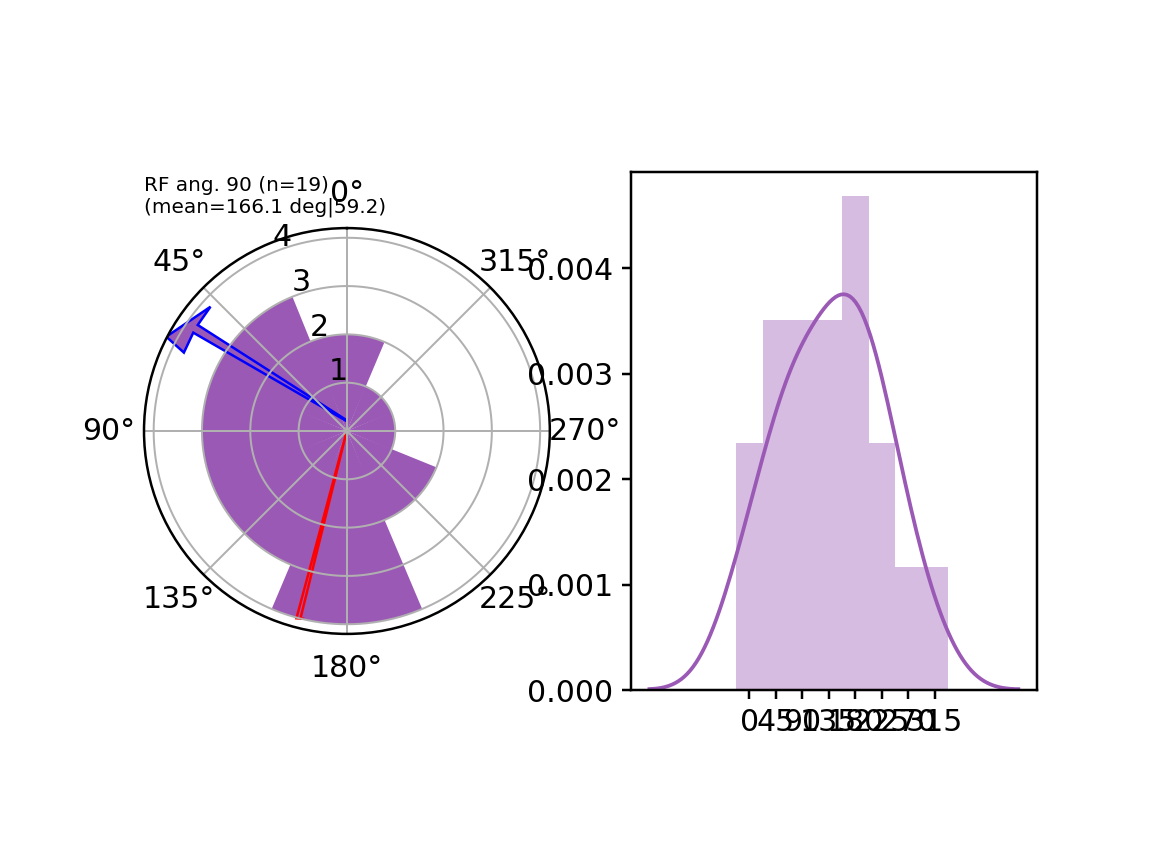

(1.1780972450961724, 1.9634954084936207)


In [165]:
#import matplotlib.image as mpimg
ori_names = np.arange(0, 360+45, 45) #np.rad2deg(xticks)

visual_area='V1'
df_ = DF[(DF['visual_area']==visual_area)].copy()
print('%s:: %i cells' % (visual_area, df_.shape[0]))

if filter_aniso:
    df_ = df_[df_['anisotropy']>aniso_thr] #.copy()
    
    
i=0
currbin = rf_bins[::-1][i]
print(currbin)
fig = pl.figure()

ax = pl.subplot(1,2, 1, projection='polar')
#, ax = pl.subplots( subplot_kw=dict(projection='polar'), figsize=(7,3), dpi=dpi)

bin_min = np.deg2rad(currbin-rf_bin_span) #%180.
bin_max = np.deg2rad(currbin+rf_bin_span) #%180.
print(bin_min, bin_max)

# Get all cells with RF angle CURRBIN
# ---------------------------------------------------------------------
curr_vs = split_by_angle(df_, currbin, metric=rf_theta_param, boundary_value=rf_boundary_value, 
                        bin_size=rf_bin_span, combine_zero=True)
ncells = curr_vs.shape[0]

# Calculate distn of prefered OSI 
# ---------------------------------------------------------------------
pref_theta_deg = curr_vs['theta_pref'].values #% 360.
bin_counts, bin_vals = get_angle_counts(pref_theta_deg, bin_size=ori_bin_span, 
                                        ori_bins=ori_bins, combine_zero=True)
centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])

# Plot polar distN
# ---------------------------------------------------------------------
use_center=False # should be false if bin_span is not half of bin diff
th_vals = centers if use_center else np.deg2rad(bin_vals) #[::-1]
r_vals = bin_counts[0:-1] if use_center else bin_counts

bin_counts, bin_edges = np.histogram(pref_theta_deg, bins=ori_names)
bin_centers = np.ediff1d(bin_edges)//2 + bin_edges[:-1]
bars = ax.bar(np.deg2rad(bin_edges[0:-1]), bin_counts)


# ticks
#replace_ori_labels(ori_names, ax=ax, yloc=5)
ax.set_theta_zero_location("N")
pl.subplots_adjust(top=0.8, bottom=0.2)


mean_theta = wrap_values(np.rad2deg(spstats.circmean(np.deg2rad(pref_theta_deg)% (2*np.pi))) % 360. ) % 360.
ax.arrow(0, 0, np.deg2rad(mean_theta), np.max(bin_counts), width=.05, 
         head_starts_at_zero=True, length_includes_head=True, edgecolor='r',
        head_width=0.) # 'k*', lw=2, linestyle='-')

hist_counts = np.array(list(itertools.chain(*[[val]*cnt for val, cnt in zip(bin_vals, bin_counts)]))) 
mean2 = np.mean(hist_counts % 180.)
ax.arrow(0, 0, np.deg2rad(mean2), np.max(bin_counts), width=.05, 
         head_starts_at_zero=True, length_includes_head=True, edgecolor='b',
        head_width=0.3) # 'k*', lw=2, linestyle='-')

ax.set_title('RF ang. %i (n=%i)\n(mean=%.1f deg|%.1f)' \
             % (currbin, ncells, mean_theta, mean2), loc='left',y=1,  fontsize=8, ) #, pad=50)


ax = pl.subplot(1,2, 2)
#ax.hist(pref_theta_deg, bins=ori_names)
ax.set_xticks(bin_centers)
ax.set_xticklabels(ori_names)
sns.distplot(pref_theta_deg, bins=ori_names, ax=ax)

In [402]:
np.deg2rad(bin_centers)

array([0.38397244, 1.1693706 , 1.95476876, 2.74016693, 3.52556509,
       4.31096325, 5.09636142])

In [401]:
bin_centers

array([ 22,  67, 112, 157, 202, 247, 292])

In [396]:
bin_counts

array([1, 1, 2, 3, 4, 2, 1])

In [244]:
spstats.circmean(pref_theta_deg% 360, low=0, high=360)

191.65201770800442

In [248]:
np.mean(pref_theta_deg)

170.8260249646832

<IPython.core.display.Javascript object>


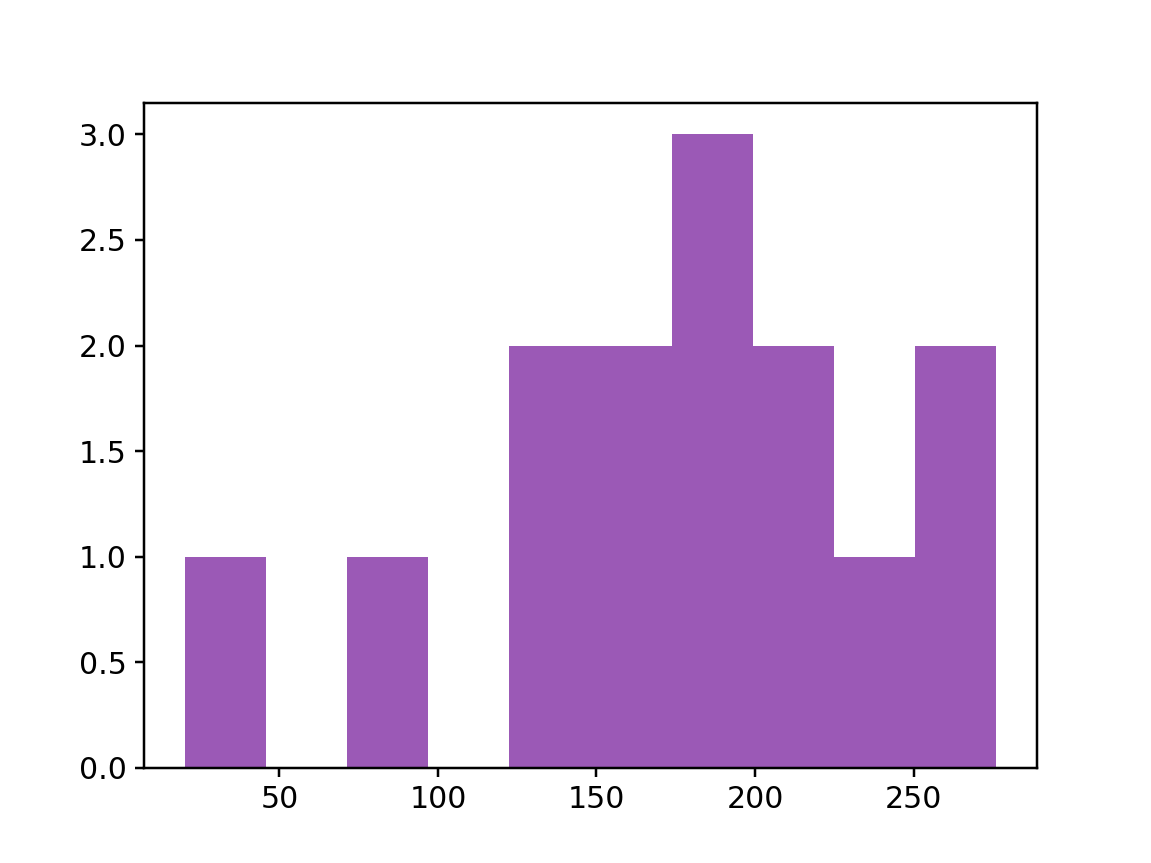

(array([1., 0., 1., 0., 2., 2., 3., 2., 1., 2.]),
 array([ 20.12936597,  45.71919452,  71.30902307,  96.89885162,
        122.48868017, 148.07850872, 173.66833727, 199.25816582,
        224.84799436, 250.43782291, 276.02765146]),
 <a list of 10 Patch objects>)

In [376]:
pl.figure()
pl.hist(pref_theta_deg, bins=10)

In [230]:
hist_counts = np.array(list(itertools.chain(*[[val]*cnt for val, cnt in zip(bin_vals, bin_counts)]))) 

np.rad2deg(spstats.circmean(np.deg2rad(hist_counts % np.pi)))
hist_counts % 180.

array([  0.,   0.,  45.,  45.,  45.,   0.,  90.,  90., 135.,   0.,   0.])

In [214]:
np.mean(hist_counts % 180.)


40.90909090909091

In [215]:
hist_counts = np.array(list(itertools.chain(*[[val]*cnt for val, cnt in zip(bin_vals, bin_counts)]))) 
meanv = np.mean(hist_counts % 180.)
print(meanv)

40.90909090909091


In [131]:
[bin_vals[0]]*2

[-180, -180]

<IPython.core.display.Javascript object>


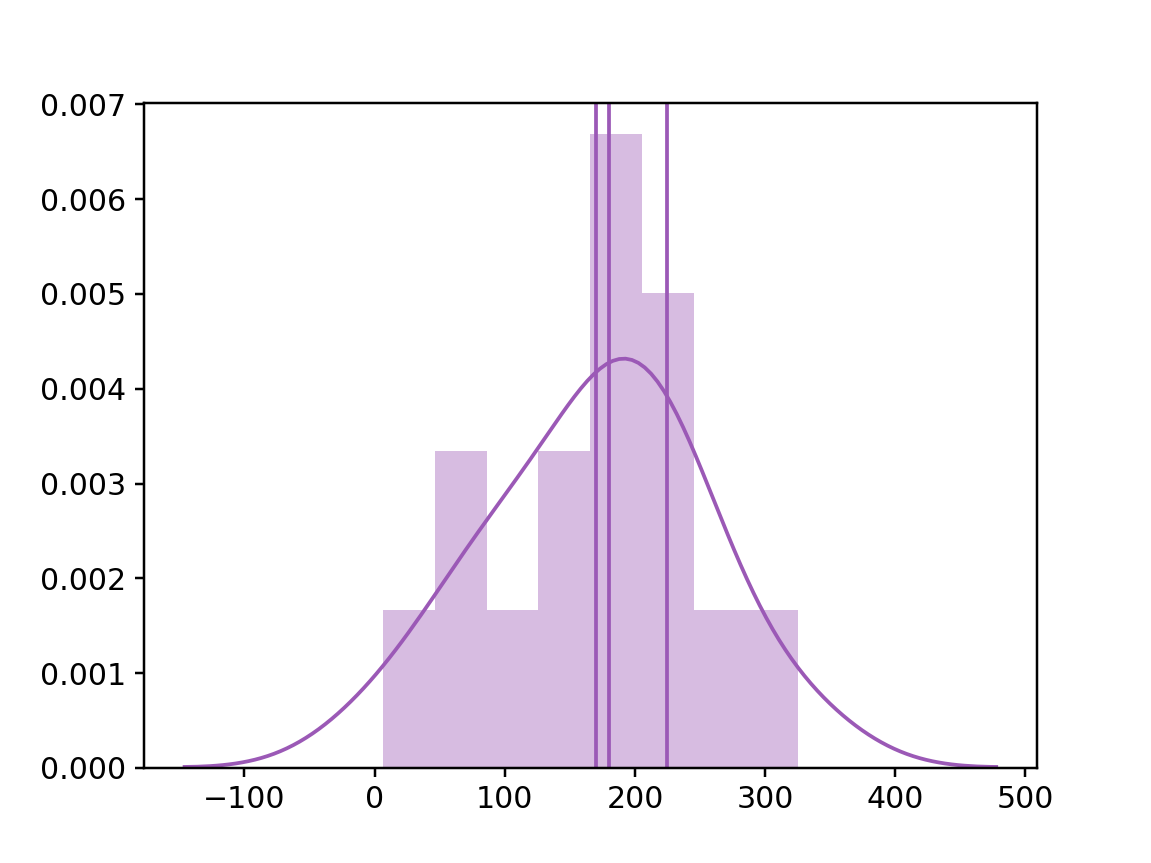

In [123]:
fig, ax = pl.subplots() #pl.figure()
sns.distplot(pref_theta_deg%360., ax=ax, bins=8)
meanv = np.mean(pref_theta_deg%360.)
ax.axvline(x=meanv)
ax.axvline(x=180)
ax.axvline(x=225)

In [116]:
np.deg2rad(meanv)


2.9683022743976144

In [921]:
degrees.min(), degrees.max()

(1.6050148974213596, 354.75640323669666)

In [922]:
rads = np.deg2rad(degrees)
rads.min(), rads.max()

(0.028012794503561773, 6.191667279013025)

In [905]:
np.mean(degrees % 180)


92.64274761314911

In [1079]:
np.rad2deg(centers)


array([-158., -113.,  -68.,  -23.,   22.,   67.,  112.,  157.])

<IPython.core.display.Javascript object>


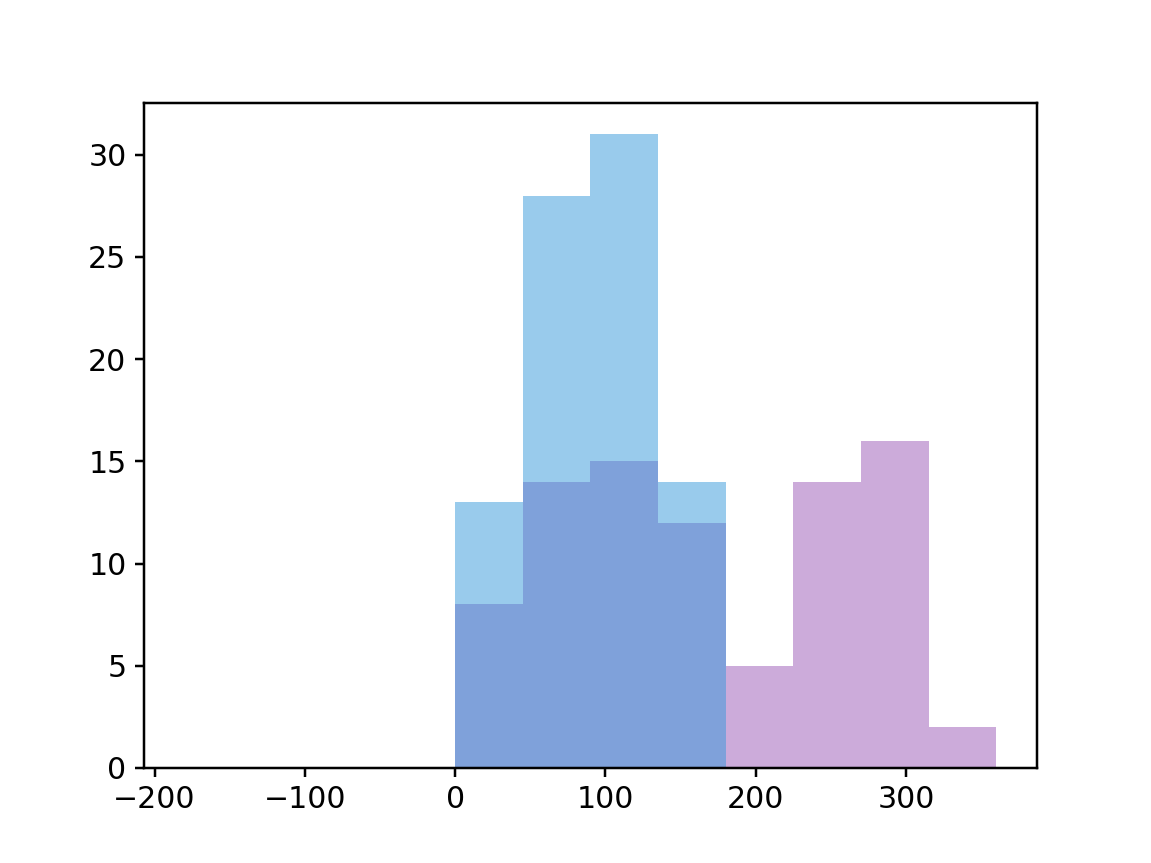

(array([ 0.,  0.,  0.,  0., 13., 28., 31., 14.]),
 array([-180, -135,  -90,  -45,    0,   45,   90,  135,  180]),
 <a list of 8 Patch objects>)

In [914]:
pl.figure()
pl.hist(degrees, bins=np.arange(0, 360+45, 45), alpha=0.5)

pl.hist(np.rad2deg(oris) % 180., bins=np.arange(-180, 180+45, 45), alpha=0.5)

In [672]:
currbin = 0

bin_min = np.deg2rad(currbin-bin_span) #%180.
bin_max = np.deg2rad(currbin+bin_span) #%180.

if currbin==90:
    bin_max = np.deg2rad(-90+ bin_span)
    bin_min = np.deg2rad(90-bin_span)
    curr_vs = df_[ ( df_['theta_Mm_c'] >= bin_min)
                     | ( df_['theta_Mm_c'] <= bin_max) ]
else:
    curr_vs = df_[ ( df_['theta_Mm_c'] >= bin_min )
                     & ( df_['theta_Mm_c'] <= bin_max ) ]

ncells = curr_vs.shape[0]


degrees = curr_vs['theta_pref'].values % 360.
rads = np.deg2rad(degrees) #% 2*np.pi



In [253]:
np.rad2deg(spstats.circmean(np.deg2rad(degrees)))

180.2687970352713

In [256]:
np.median(degrees)

175.0530766673429

<IPython.core.display.Javascript object>


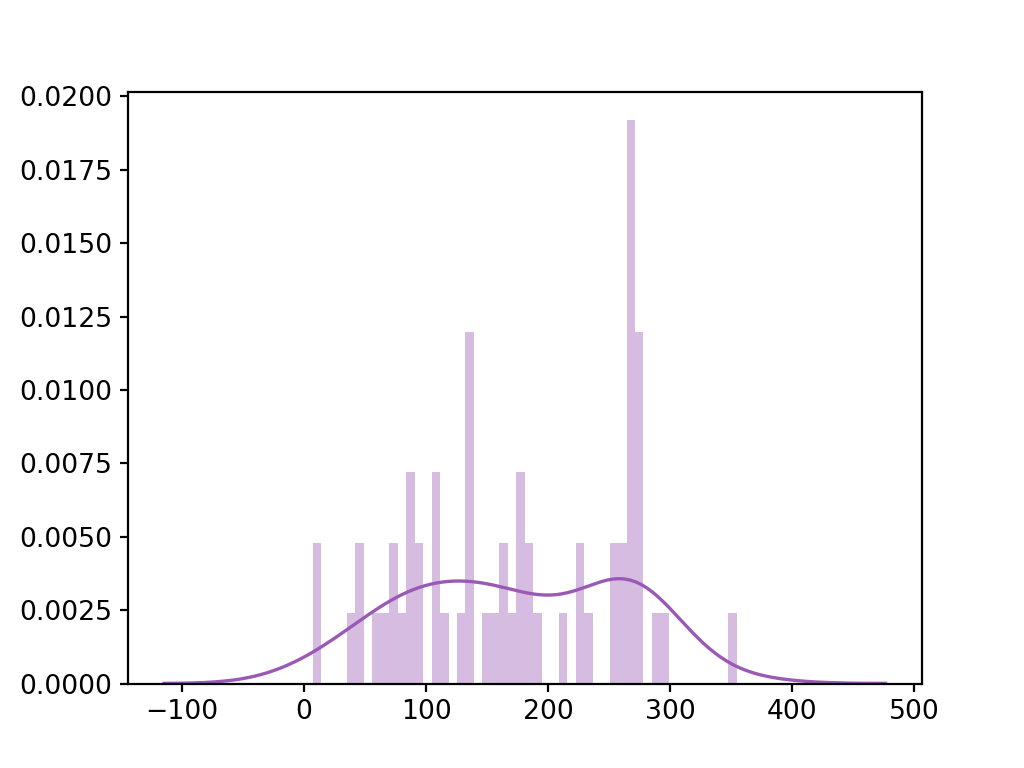

In [255]:
pl.figure()
sns.distplot(degrees, bins=50, kde=True)

In [216]:
bin_counts, bin_vals = np.histogram(degrees, bins=ori_bins)


In [219]:
max_ix = np.where(bin_counts==max(bin_counts))[0][0]
bin_vals[max_ix]
bin_vals

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180,
       195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360])

In [223]:
rf_bins

array([-90, -45,   0,  45,  90])

In [226]:
ori_bins

array([  0,  45,  90, 135, 180, 225, 270, 315])

<IPython.core.display.Javascript object>


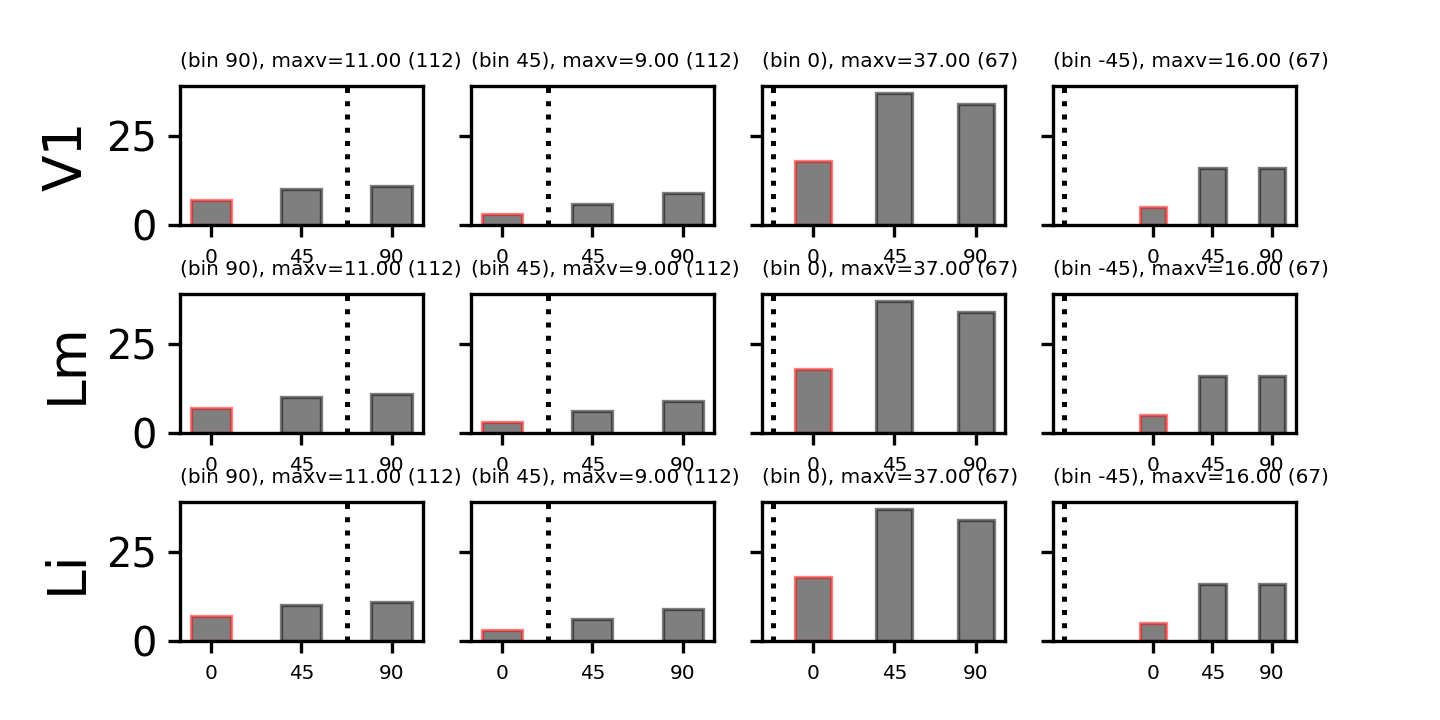

(90, 1.2217304763960306, -1.2217304763960306)
(45, 0.4363323129985824, 1.1344640137963142)
(0, -0.3490658503988659, 0.3490658503988659)
(-45, -1.1344640137963142, -0.4363323129985824)
(90, 1.2217304763960306, -1.2217304763960306)
(45, 0.4363323129985824, 1.1344640137963142)
(0, -0.3490658503988659, 0.3490658503988659)
(-45, -1.1344640137963142, -0.4363323129985824)
(90, 1.2217304763960306, -1.2217304763960306)
(45, 0.4363323129985824, 1.1344640137963142)
(0, -0.3490658503988659, 0.3490658503988659)
(-45, -1.1344640137963142, -0.4363323129985824)


In [229]:
fig, axn = pl.subplots(3, 4, figsize=(6,3), dpi=dpi, sharey=True, sharex=False)
#fig, axn = pl.subplots(2, 3, subplot_kw=dict(projection='polar'), figsize=(7,3), dpi=dpi)

visual_area='V1'

g = GFS[GFS['visual_area']==visual_area].copy()
r = RFS[RFS['visual_area']==visual_area].copy()


for vi, visual_area in enumerate(visual_areas):
    
    g = GFS[GFS['visual_area']==visual_area].copy()
    r = RFS[RFS['visual_area']==visual_area].copy()

    cols_to_use = r.columns.difference(g.columns)
    combodf = pd.merge(g, r[cols_to_use], left_index=True, right_index=True, how='outer')

    
    for i, currbin in enumerate(rf_bins[::-1][0:-1]):
        #if currbin not in [0, 90]:
        #    continue
        
        ax = axn[vi, i]
        #ax.set_title('RF angle=%i' % currbin, fontsize=6)
        if i==0:
            ax.set_ylabel(visual_area)
    
        bin_min = np.deg2rad(currbin-bin_span) #%180.
        bin_max = np.deg2rad(currbin+bin_span) #%180.

        if currbin==90:
            bin_max = np.deg2rad(-90+ bin_span)
            bin_min = np.deg2rad(90-bin_span)
            curr_vs = df_[ ( df_['theta_Mm_c'] >= bin_min)
                             | ( df_['theta_Mm_c'] <= bin_max) ]
        else:
            curr_vs = df_[ ( df_['theta_Mm_c'] >= bin_min )
                             & ( df_['theta_Mm_c'] <= bin_max ) ]

        ncells = curr_vs.shape[0]
        print(currbin, bin_min, bin_max)
        
        degrees = curr_vs['theta_pref'].values % 180.
        ori_bins = np.arange(0, 180, 45)
        
        bcounts, bvals = np.histogram(degrees, bins=ori_bins)
        #bcenters = np.deg2rad(np.ediff1d(bvals)//2 + bvals[:-1])
        #print(currbin, np.median(degrees))
        bcenters = np.ediff1d(bvals)//2 + bvals[:-1]

        #ax.hist(degrees, label='%s, RFs=%i' % (visual_area, currbin), lw=2, 
        #     histtype='step', color=col_dict[currbin], bins=bcenters, alpha=0.5)
        ax.bar(bcenters, bcounts, width=20, bottom=0.0, color='k', alpha=0.5, edgecolor='r')
        #ax.set_theta_zero_location("N")
        
        #ax.set_xticks(np.arange(0, 360, 45))
        ax.set_xticks(bcenters)
        ax.set_xticklabels(bvals, fontsize=6)
        #ax.set_xticklabels([b if bi%2==0 else '' for bi, b in enumerate(bvals)], fontsize=6)

        ax.axvline(x=currbin, ls=':', color='k')
        max_bin = np.where(bcounts==max(bcounts))[0][0]
        max_val = max(bcounts)
        max_str = '(bin %i), maxv=%.2f (%i)' % (currbin, max_val, bcenters[max_bin])
        ax.set_title(max_str, fontsize=6, loc='left') #(currbin, ax.get_ylim()[-1], , fontsize=6)
        
pl.legend()
pl.subplots_adjust(hspace=0.5, wspace=0.2)

In [605]:
270.%180.

90.0

In [612]:
np.where(bcounts==max(bcounts))[0][0]

4

<IPython.core.display.Javascript object>


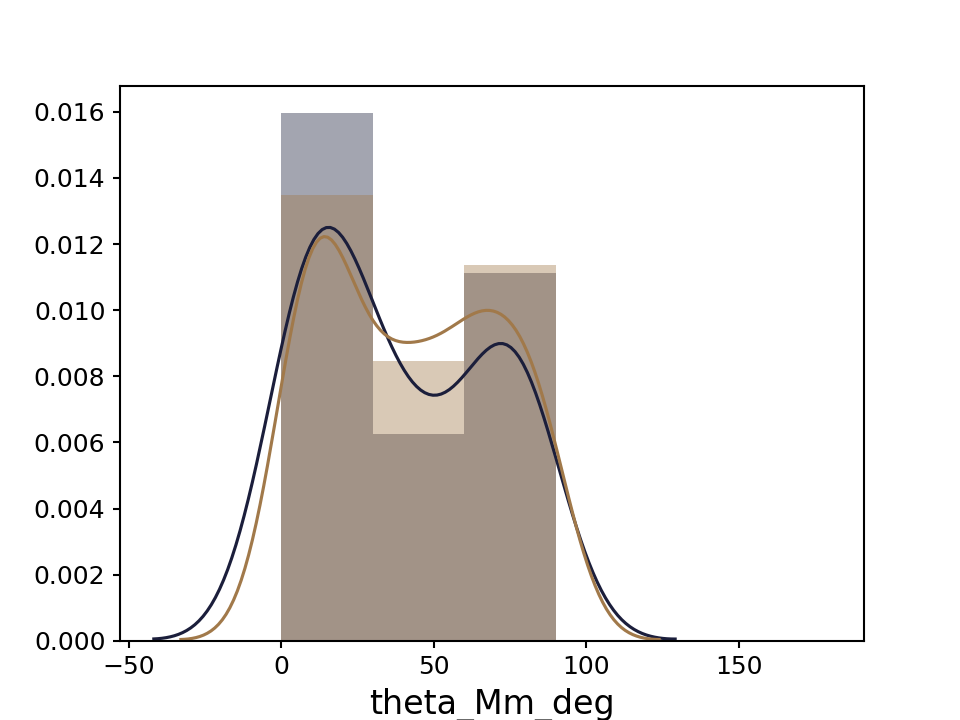

In [265]:
i = 0
f, ax = pl.subplots()
curr_bin_oris = g[ ((g['theta_pref'] % 180.) > bin_vals[i]) 
                 & ((g['theta_pref'] % 180.) < bin_vals[i+1]) ]
curr_bin_rfs = r[r['cell'].isin(curr_bin_oris['cell'].unique())].copy()


sns.distplot(curr_bin_rfs['theta_Mm_deg'] % 90., kde=True, bins=bins, ax=ax, 
             color=col_dict[bin_vals[i]])

i=3
curr_bin_oris = g[ ((g['theta_pref'] % 180.) > bin_vals[i]) 
                 & ((g['theta_pref'] % 180.) < bin_vals[i+1]) ]
curr_bin_rfs = r[r['cell'].isin(curr_bin_oris['cell'].unique())].copy()


sns.distplot(curr_bin_rfs['theta_Mm_deg'] % 90., kde=True, bins=bins, ax=ax, 
             color=col_dict[bin_vals[i]])

    

In [128]:
curr_bin_rfs['theta_Mm_deg']

Series([], Name: theta_Mm_deg, dtype: float64)

In [129]:
bin_counts

array([14, 10, 21, 20, 17, 39, 46, 20, 15, 15,  9, 13,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])

In [102]:
rf_angle.min(), rf_angle.max()

(3.2688107655715015, 179.8988497524265)

<IPython.core.display.Javascript object>


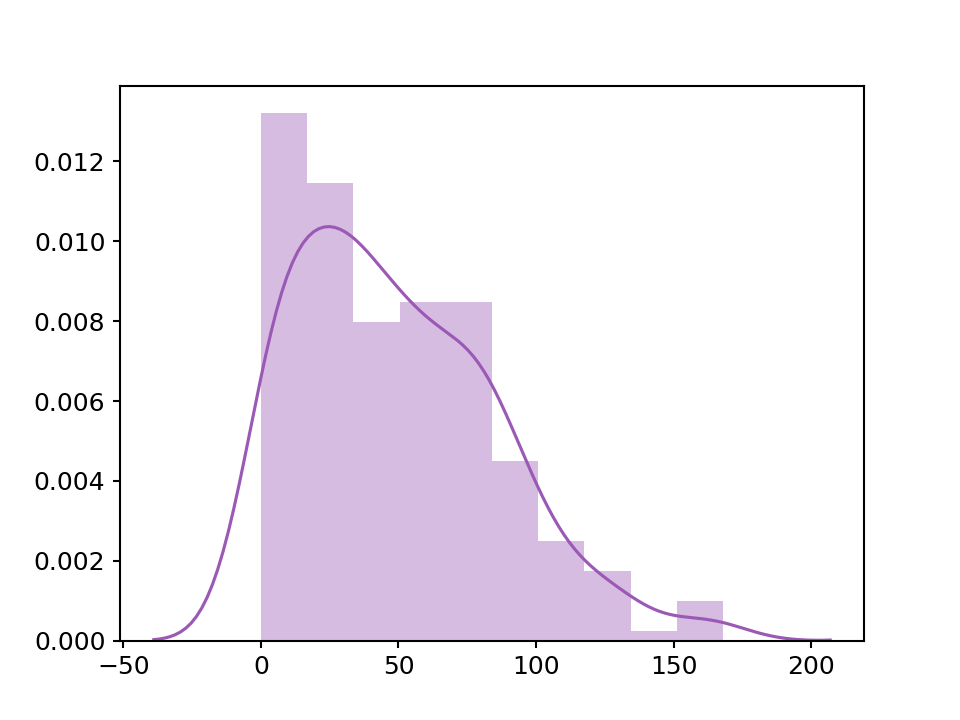

In [99]:
fig, ax = pl.subplots()
angle_diffs = abs(pref_ori - rf_angle)
sns.distplot(angle_diffs, ax=ax)


In [261]:
# for x, y in zip(g.sort_values(by=['cell'])['theta_pref'].values % 180., r.sort_values(by=['cell'])['theta_Mm_deg'].values):
#     print(x,y)

In [225]:
r.shape, g.shape

((237, 35), (237, 17))

In [235]:
r['theta_Mm_deg'].values.max() % 180.

179.50074654511474

In [90]:
r.columns

Index([u'animalid', u'datakey', u'session', u'fov_xpos', u'fov_ypos',
       u'ml_pos', u'ap_pos', u'cell', u'r2', u'fwhm_x', u'fwhm_y', u'theta',
       u'x0', u'y0', u'fovnum', u'std_x', u'std_y', u'fwhm_avg', u'std_avg',
       u'area', u'datakey_ix', u'fov_xpos_pix', u'fov_ypos_pix',
       u'visual_area', u'experiment', u'fx', u'fy', u'ratio_xy', u'theta_c',
       u'theta_Mm_deg', u'major_axis', u'minor_axis', u'anisotropy',
       u'theta_Mm_c', u'aniso_index'],
      dtype='object')

In [ ]:
rfdf['ml_proj'] = ''
rfdf['ap_proj'] = ''

rfdf = rfdf.reset_index(drop=True)
n_dsets = len(rfdf.groupby(['datakey', 'experiment']).groups)

for di, ((visual_area, datakey, exp), rd) in enumerate(rfdf.groupby(['visual_area', 'datakey', 'experiment'])):
    if di % 10 == 0 or di==(n_dsets-1):
        print("%i of %i gradient result files loaded." % (int(di+1), n_dsets))

    p_df = projdf[(projdf['datakey']==datakey) & (projdf['visual_area']==visual_area)]
    if  len(p_df['fpath'].unique())==0:
        print("...missing: [%s] %s, %s" % (visual_area, datakey, exp))
        continue
    assert len(p_df['fpath'].unique())==1, "No unique retino path found: %s" % str(p_df['fpath'].unique())
    fpath = p_df['fpath'].unique()[0]
    gpath = os.path.join(os.path.split(fpath)[0], 'vectors_%s.pkl' % visual_area)
    with open(gpath, 'rb') as f:
        gresults = pkl.load(f)

    # Project FOV coordinates
    rfdf['ml_proj'][rd.index] = np.array([np.dot(np.array((ml, ap)), gresults['az']) \
                                          for ap, ml in rd[['ap_pos', 'ml_pos']].values])
    rfdf['ap_proj'][rd.index] = np.array([np.dot(np.array((ml, ap)), gresults['el']) \
                                          for ap, ml in rd[['ap_pos', 'ml_pos']].values])